# Prerequisites

In [1]:
import pandas as pd
import pymc3 as pm
import bambi as bmb
from bambi import Prior
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib
import numpy as np
import scipy as sp

RANDOM_SEED = 3301

In [2]:
#Change the path if necessary
df = pd.read_csv("data_all.csv")

#Tidy up data frame
df.drop(['VP','FPSmax','FPSmin','FPSmean','FPSsd'], axis=1, inplace=True)
df = df.astype({"Condition": 'category',"ID": 'category',"Speed": 'category'})
df['Condition'] = df['Condition'].cat.reorder_categories(['REAL','CAVE','HMD','AR','CBLab','CBRemote'], ordered=True)

#Center gap sizes from [1,5] to [-2,2]
df['GapC'] = df['Gap'] - 3 

#Exclude the one remote participant with many treated data points (c.f. Section Data Exclusion)
#df = df.drop(df[df.ID == '27_CBRemote'].index) 

In [3]:
#Figure aesthetics
fontcolor = "black"
whiskercolor = "black"
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 0.0),  # rgba
    "axes.facecolor":    (1.0, 1.0, 1.0, 0.0),  
    "savefig.facecolor": (1.0, 1.0, 1.0, 0.0),
    "legend.framealpha": 0.0,
    "text.color": fontcolor,
    "axes.labelcolor": fontcolor,
    "xtick.color": fontcolor,
    "ytick.color": fontcolor,
    "axes.edgecolor": fontcolor,
    "boxplot.notch":  True
})
sns.set_palette("viridis",6)

In [4]:
#transformation of the coefficients from log odds to probabilities
def plogis(x):
    return np.exp(x) / (1+np.exp(x))

# Exploratory Data Analysis

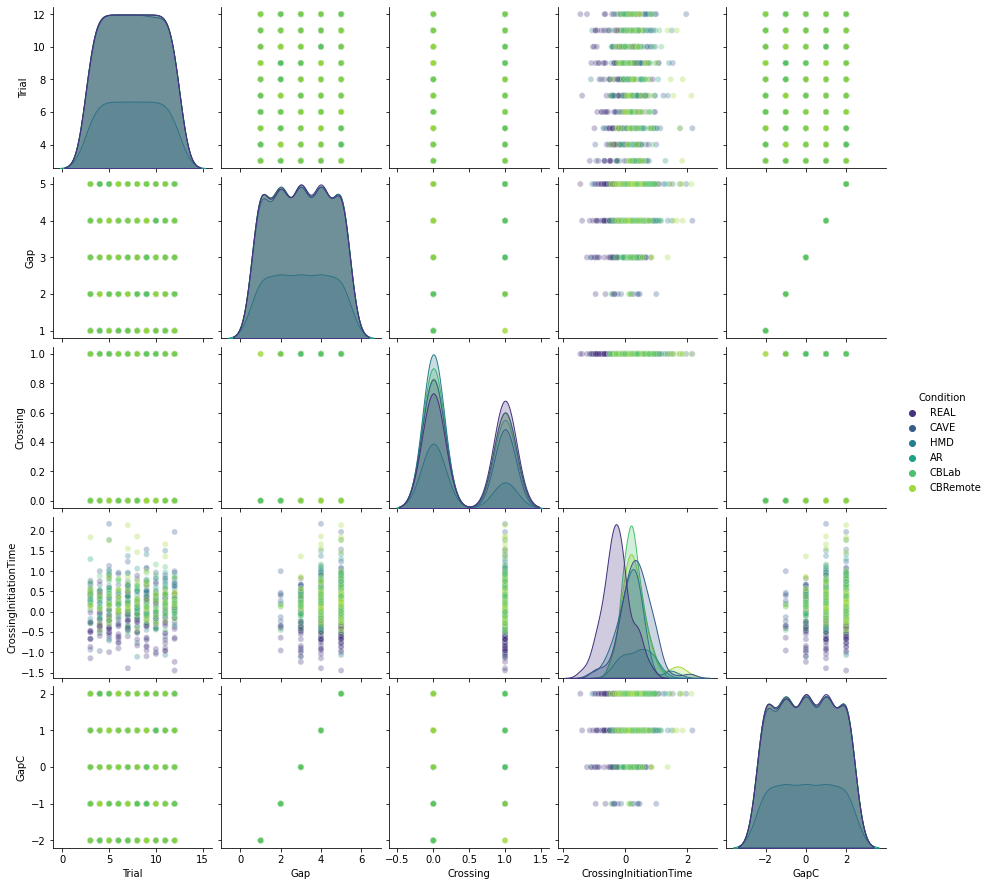

In [5]:
sns.pairplot(df, hue="Condition",plot_kws=dict(alpha=0.3));

## Gap Acceptance

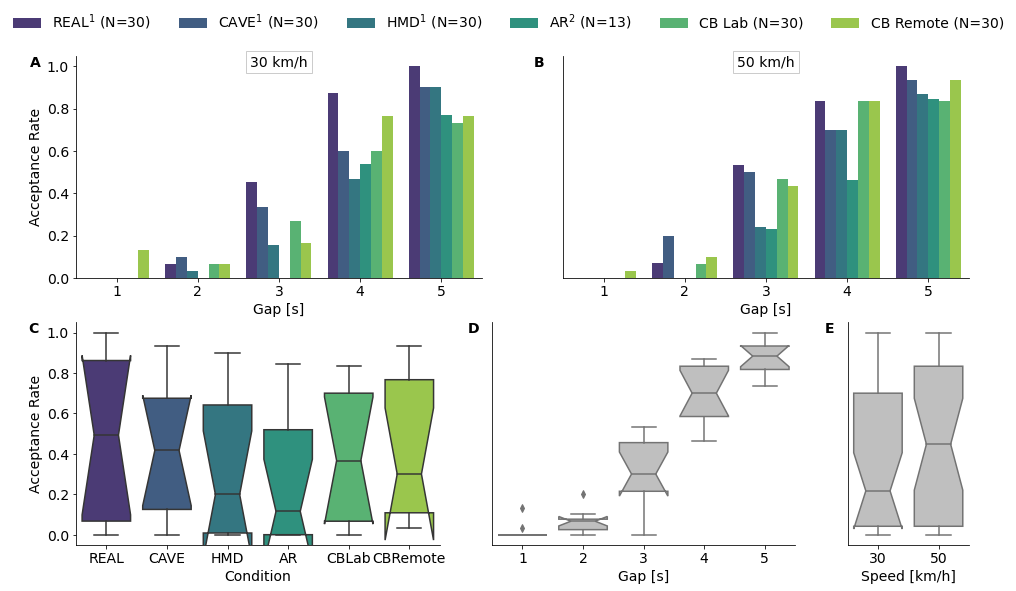

In [6]:
#Creating dataframe with acceptance rates for combinations of speed, condition and gap size
columns = ['Condition','Speed','Gap [s]','Acceptance Rate']
df_gap_acceptance = pd.DataFrame(columns = columns)
for Speed in [30,50]:
    for Condition in ['REAL','CAVE','HMD','AR','CBLab', 'CBRemote']:
        for Gap in range(1,6):
            df_gap_acceptance.loc[len(df_gap_acceptance)] = [Condition,Speed,Gap, df.loc[(df['Condition'] == Condition) & (df['Speed'] == Speed) & (df['Gap'] == Gap)]
                                                             .Crossing.value_counts(normalize=True,sort=False, dropna=False).get(1, 0)]

#Plot
fig = plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 14})
gs0 = gridspec.GridSpec(2, 1, figure=fig)
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[0, 0])
ax2 = fig.add_subplot(gs00[0, 1])

gs01 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1], width_ratios = [6,5,2])
ax3 = fig.add_subplot(gs01[0, 0])
ax4 = fig.add_subplot(gs01[0, 1])
ax5 = fig.add_subplot(gs01[0, 2])


sns.barplot(x='Gap [s]', y='Acceptance Rate', ax = ax1,hue='Condition',
            data=df_gap_acceptance.loc[df_gap_acceptance['Speed'] == 30]);
ax1.get_legend().remove()
ax1.text(2, 1, '30 km/h', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.2))

sns.barplot(x='Gap [s]', y='Acceptance Rate', ax = ax2,hue='Condition',
            data=df_gap_acceptance.loc[df_gap_acceptance['Speed'] == 50]);
ax2.get_legend().remove()
ax2.yaxis.set_visible(False)
ax2.text(2, 1, '50 km/h', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.2))

sns.boxplot(ax = ax3,x='Condition', y='Acceptance Rate', data=df_gap_acceptance);

sns.boxplot(ax = ax4,x='Gap [s]', y='Acceptance Rate', data=df_gap_acceptance, color = '#bfbfbf');
ax4.yaxis.set_visible(False)

sns.boxplot(ax = ax5,x='Speed', y='Acceptance Rate', data=df_gap_acceptance, color = '#bfbfbf');
ax5.yaxis.set_visible(False)
ax5.set_xlabel('Speed [km/h]')

plt.legend(bbox_to_anchor=(-2.8, 2.35), loc='center', prop={'size': 14},
           ncol=6,handles = ax1.get_legend_handles_labels()[0], 
           labels=['REAL$^{1}$ (N=30)', 'CAVE$^{1}$ (N=30)', 'HMD$^{1}$ (N=30)', 
                   'AR$^{2}$ (N=13)', 'CB Lab (N=30)', 'CB Remote (N=30)'])

#Labels for subfigures
ax1.text(-1, 1, 'A', horizontalalignment='center',weight="bold")
ax2.text(-0.8, 1, 'B', horizontalalignment='center',weight="bold")
ax3.text(-1.2, 1, 'C', horizontalalignment='center',weight="bold")
ax4.text(-0.8, 1, 'D', horizontalalignment='center',weight="bold")
ax5.text(-0.8, 1, 'E', horizontalalignment='center',weight="bold")

sns.despine()

In [7]:
#Acceptance rates for each condition
df_gap_acceptance.iloc[:,3] = pd.to_numeric(df_gap_acceptance.iloc[:,3], errors='coerce')
df_gap_acceptance.groupby('Condition')['Acceptance Rate'].describe()

count      mean       std       min       25%       50%       75%  \
Condition                                                                      
AR          10.0  0.284615  0.342190  0.000000  0.000000  0.115385  0.519231   
CAVE        10.0  0.426667  0.353047  0.000000  0.125000  0.416667  0.675000   
CBLab       10.0  0.386667  0.347904  0.000000  0.066667  0.366667  0.700000   
CBRemote    10.0  0.423333  0.364827  0.033333  0.108333  0.300000  0.766667   
HMD         10.0  0.336430  0.368304  0.000000  0.008333  0.198815  0.641667   
REAL        10.0  0.482488  0.424615  0.000000  0.067241  0.492473  0.861559   

                max  
Condition            
AR         0.846154  
CAVE       0.933333  
CBLab      0.833333  
CBRemote   0.933333  
HMD        0.900000  
REAL       1.000000

## Crossing Initiation Time

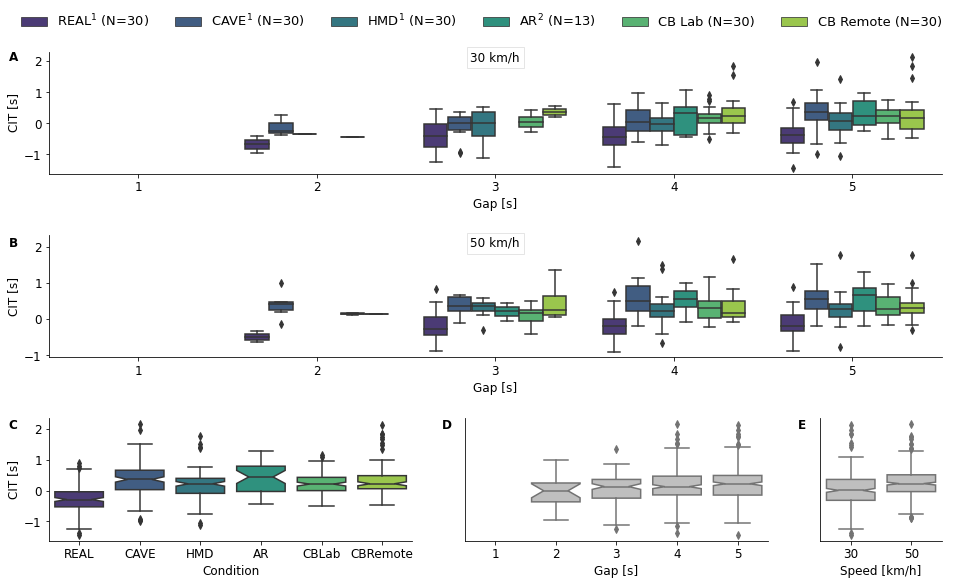

In [8]:
#Plot
fig = plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 12})
gs0 = gridspec.GridSpec(3, 1, figure=fig,hspace=0.5)
gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[0, 0])

gs01 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1])
ax2 = fig.add_subplot(gs01[0, 0])

gs02 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[2], width_ratios = [6,5,2])
ax3 = fig.add_subplot(gs02[0, 0])
ax4 = fig.add_subplot(gs02[0, 1])
ax5 = fig.add_subplot(gs02[0, 2])

sns.boxplot(x='Gap', y='CrossingInitiationTime', ax = ax1,hue='Condition',
            data=df.loc[df['Speed'] == 30],notch = False);
ax1.set_xlabel('Gap [s]')
ax1.get_legend().remove()
ax1.text(2, 2, '30 km/h', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.1))
ax1.set_ylabel('CIT [s]')

sns.boxplot(x='Gap', y='CrossingInitiationTime', ax = ax2,hue='Condition',
            data=df.loc[df['Speed'] == 50],notch = False);
ax2.get_legend().remove()
ax2.text(2, 2, '50 km/h', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.1))
#ax2.yaxis.set_visible(False)
ax2.set_xlabel('Gap [s]')
ax2.set_ylabel('CIT [s]')

sns.boxplot(ax = ax3,x='Condition', y='CrossingInitiationTime', data=df, order=['REAL','CAVE','HMD','AR','CBLab', 'CBRemote']);
ax3.set_ylabel('CIT [s]')

sns.boxplot(ax = ax4,x='Gap', y='CrossingInitiationTime', data=df, color = '#bfbfbf');
ax4.yaxis.set_visible(False)
ax4.set_xlabel('Gap [s]')

sns.boxplot(ax = ax5,x='Speed', y='CrossingInitiationTime', data=df, color = '#bfbfbf');
ax5.yaxis.set_visible(False)
ax5.set_xlabel('Speed [km/h]')

plt.legend(bbox_to_anchor=(-2.8, 4.25), loc='center', prop={'size': 13},
           ncol=6,handles = ax1.get_legend_handles_labels()[0], 
           labels=['REAL$^{1}$ (N=30)', 'CAVE$^{1}$ (N=30)', 'HMD$^{1}$ (N=30)', 
                   'AR$^{2}$ (N=13)', 'CB Lab (N=30)', 'CB Remote (N=30)'])
#Labels for subfigures
ax1.text(-0.7, 2, 'A', horizontalalignment='center',weight="bold")
ax2.text(-0.7, 2, 'B', horizontalalignment='center',weight="bold")
ax3.text(-1.1, 2, 'C', horizontalalignment='center',weight="bold")
ax4.text(-0.8, 2, 'D', horizontalalignment='center',weight="bold")
ax5.text(-0.8, 2, 'E', horizontalalignment='center',weight="bold")

sns.despine()

## Subjective Data

Q1: How safe would it have been to cross the street?

Q2: How likely would a collision have been?

Q3: How dangerous would a collision have been?

Q4: How similar to real world traffic was your behavior in cases when you crossed the street?

Q5: How similar to real world traffic was your behavior in cases when you did not cross the street?

Q6: Compared to usual, my choices were safe / unsafe

Q7: Compared to usual, deciding to cross the street was easy / difficult

Q8: Compared to usual, making a decision took longer / shorter

In [9]:
#Load data and tidy up dataframe
df_subjectives = pd.read_csv("questionnaires_all.csv", encoding="cp1252")
df_subjectives = df_subjectives.astype({"Condition": 'category',"ID": 'category'})
df_subjectives['Condition'] = df_subjectives['Condition'].cat.reorder_categories(['REAL','CAVE','HMD','AR','CBLab','CBRemote'], ordered=True)
df_subjectives

VP Condition   Q4                                                4aY  \
0     1     CBLab  0.9                           reales Verhalten möglich   
1     2  CBRemote  0.8  es würde auch vom augenkontakt mit dem Fahrer(...   
2     3  CBRemote  0.7  wenn danach kein Auto mehr gekommen wäre, hätt...   
3     4     CBLab  0.6                       etwas risikofreudiger bei VR   
4     5  CBRemote  0.7  mir fiel zu Beginn dir Abschötzung schwer,  da...   
..   ..       ...  ...                                                ...   
158  59       HMD  0.9  in VR i felt almost like in real world an di b...   
159  60       HMD  0.3  je sius quelque'un de tres prudent en situatio...   
160  61       HMD  0.9  dans la vie relle j'etude de la meme facon que...   
161  62       HMD  0.3  Comme? dans la vie reele je traverse la rue me...   
162  63       HMD  0.8                                                NaN   

      Q5                                                4bY  Age  EyeLevel  \
0    0.8                           reales Verhalten möglich   30     194.0   
1    1.0                        Wäre mir zu riskant gewesen   23     175.0   
2    1.0                                      zu gefährlich   24     183.0   
3    0.9                  so würde ich es auch sonst machen   26     170.0   
4    0.7                                               s.o.   30     163.0   
..   ...                                                ...  ...       ...   
158  0.8  I believe that in the real world i am taking i...   27       NaN   
159  1.0           je suis tres prudent en situation reelle   23       NaN   
160  0.9  les voitures, dans ces cas la, allaient bien t...   29       NaN   
161  0.1                                                NaN   26       NaN   
162  0.8                                                NaN   23       NaN   

     Gender   Q7  ...                               Sonstige Anmerkungen   Q3  \
0      male  1.0  ...                                                NaN  3.0   
1    female  1.0  ...  bei mir gabs in der brille einen leichten "rec...  2.0   
2    female  1.0  ...                                                NaN  4.0   
3    female  1.0  ...                                                NaN  3.0   
4    female  1.0  ...                                                NaN  2.0   
..      ...  ...  ...                                                ...  ...   
158       m -1.0  ...  I would use the audio signals to learn about t...  3.0   
159       m  1.0  ...                                                NaN  3.0   
160       f  0.0  ...                                                NaN  3.0   
161       m  0.0  ...                         tres bonne experimentation  4.0   
162       m  1.0  ...                                                NaN  3.0   

     Q1 Q2                     Date  CIT Warnings  Button Warnings  \
0     3  2  2020-10-06T15:39:26:607           0.0              1.0   
1     3  4  2020-12-05T13:30:16:604           1.0              0.0   
2     3  2  2020-12-17T11:15:45:207           2.0              1.0   
3     3  1  2020-10-05T16:04:10:076           0.0              0.0   
4     1  1  2020-11-04T13:31:47:671           0.0              0.0   
..   .. ..                      ...           ...              ...   
158   3  2                      NaN           NaN              NaN   
159   3  3                      NaN           NaN              NaN   
160   3  2                      NaN           NaN              NaN   
161   4  3                      NaN           NaN              NaN   
162   3  2                      NaN           NaN              NaN   

     Button Deletes Resolution          ID  
0               0.0      0.922     1_CBLab  
1               0.0      2.333  2_CBRemote  
2               0.0      2.074  3_CBRemote  
3               0.0      1.349     4_CBLab  
4               0.0      1.349  5_CBRemote  
..              ...        ...         ...  
158           

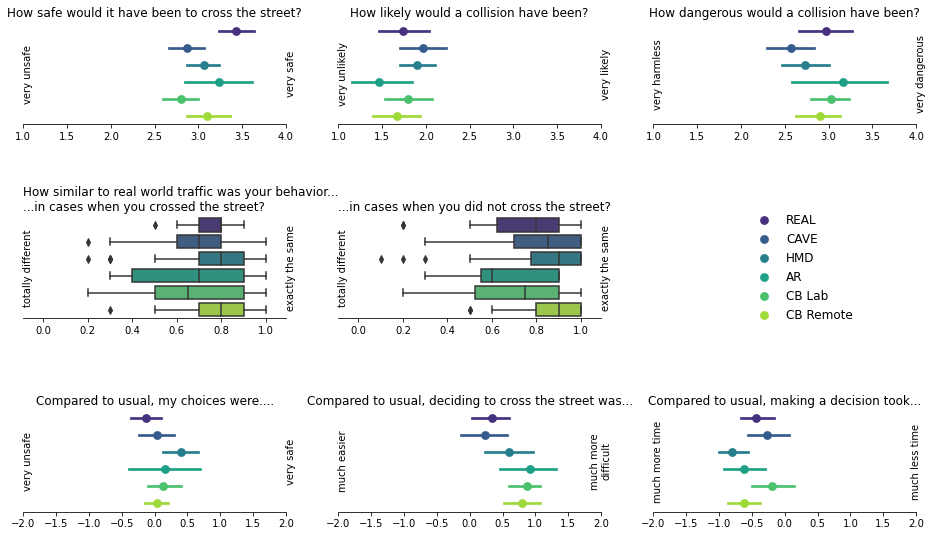

In [10]:
#Plot
order = ['REAL','CAVE','HMD','AR','CBLab', 'CBRemote']
fig = plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 10})

ax1 = plt.subplot(3, 3, 1)
ax1.set_title("How safe would it have been to cross the street?")
sns.pointplot(y='Condition', x='Q1',join=False, data = df_subjectives,
             hue='Condition',hue_order=order,order=order, ax=ax1);
ax1.text(0, 0.5, "very unsafe",transform=ax1.transAxes, rotation = 90,verticalalignment='center')
ax1.text(1, 0.5, "very safe",transform=ax1.transAxes, rotation = 90,verticalalignment='center')
ax1.set(xlim=(1, 4))

ax2 = plt.subplot(3, 3, 2)
ax2.set_title("How likely would a collision have been?")
sns.pointplot(y='Condition', x='Q2',join=False, data = df_subjectives,
             hue='Condition',hue_order=order,order=order, ax=ax2);
ax2.text(0, 0.5, "very unlikely",transform=ax2.transAxes, rotation = 90,verticalalignment='center')
ax2.text(1, 0.5, "very likely",transform=ax2.transAxes, rotation = 90,verticalalignment='center')
ax2.set(xlim=(1, 4))

ax3 = plt.subplot(3, 3, 3)
ax3.set_title("How dangerous would a collision have been?")
sns.pointplot(y='Condition', x='Q3',join=False, data = df_subjectives,
             hue='Condition',hue_order=order,order=order, ax=ax3);
ax3.text(0, 0.5, "very harmless",transform=ax3.transAxes, rotation = 90,verticalalignment='center')
ax3.text(1, 0.5, "very dangerous",transform=ax3.transAxes, rotation = 90,verticalalignment='center')
ax3.set(xlim=(1, 4))


ax4 = plt.subplot(3, 3, 4)
ax4.set_title("How similar to real world traffic was your behavior... \n...in cases when you crossed the street?" , loc='left')
sns.boxplot(y="Condition", x='Q4', orient = "h", notch = False,
                data = df_subjectives, hue_order=order, order=order);
ax4.text(0, 0.5, "totally different",transform=ax4.transAxes, rotation = 90,verticalalignment='center')
ax4.text(1, 0.5, "exactly the same",transform=ax4.transAxes, rotation = 90,verticalalignment='center')
ax4.set(xlim=(-0.09, 1.09))
    
ax5 = plt.subplot(3, 3, 5)
ax5.set_title("\n...in cases when you did not cross the street?", loc='left')
sns.boxplot(y="Condition", x='Q5', orient = "h", notch = False,
                data = df_subjectives, hue_order=order, order=order);
ax5.text(0, 0.5, "totally different",transform=ax5.transAxes, rotation = 90,verticalalignment='center')
ax5.text(1, 0.5, "exactly the same",transform=ax5.transAxes, rotation = 90,verticalalignment='center')
ax5.set(xlim=(-0.09, 1.09))

ax6 = plt.subplot(3, 3, 7)
ax6.set_title("Compared to usual, my choices were....")
sns.pointplot(y='Condition', x='Q6',join=False, data = df_subjectives,
             hue='Condition',hue_order=order,order=order, ax=ax6);
ax6.text(0, 0.5, "very unsafe",transform=ax6.transAxes, rotation = 90,verticalalignment='center')
ax6.text(1, 0.5, "very safe",transform=ax6.transAxes, rotation = 90,verticalalignment='center')
ax6.set(xlim=(-2, 2))
    
ax7 = plt.subplot(3, 3, 8)
ax7.set_title("Compared to usual, deciding to cross the street was...")
sns.pointplot(y='Condition', x='Q7',join=False, data = df_subjectives,
             hue='Condition',hue_order=order,order=order, ax=ax7);
ax7.text(0, 0.5, "much easier",transform=ax7.transAxes, rotation = 90,verticalalignment='center')
ax7.text(1, 0.5, "much more\ndifficult",transform=ax7.transAxes, rotation = 90,verticalalignment='center',horizontalalignment='center')
ax7.set(xlim=(-2, 2))
    
ax8 = plt.subplot(3, 3, 9)
ax8.set_title("Compared to usual, making a decision took...")
sns.pointplot(y='Condition', x='Q8',join=False, data = df_subjectives,
             hue='Condition',hue_order=order,order=order, ax=ax8);
ax8.text(0, 0.5, "much more time",transform=ax8.transAxes, rotation = 90,verticalalignment='center')
ax8.text(1, 0.5, "much less time",transform=ax8.transAxes, rotation = 90,verticalalignment='center',horizontalalignment='center')
ax8.set(xlim=(-2, 2))

#Remove labels and create custom legend
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.spines['left'].set_color('white')
    ax.legend([],[], frameon=False)

ax5.legend(bbox_to_anchor=(2, 0.5), loc='right',prop={'size': 12},
           handles = ax1.get_legend_handles_labels()[0],ncol=1, 
           labels=['REAL', 'CAVE', 'HMD', 'AR', 'CB Lab ', 'CB Remote']);

fig.subplots_adjust(hspace=0.9, wspace=0.2)
sns.despine()

# Bayes Analysis

## Gap Acceptance

### Models
https://mc-stan.org/misc/warnings.html recommends requiring that the bulk-ESS is greater than 100 times the number of chains and running at least four chains by default and only using the sample if R-hat is less than 1.01

In [11]:
crossing_model = bmb.Model("Crossing ~ 0 + Condition + Speed + GapC + (1|ID)", df,
                           categorical=["Condition","Speed"],family="bernoulli")
crossing_fitted = crossing_model.fit(draws=4000, target_accept=0.99, random_seed=RANDOM_SEED)
az.summary(crossing_fitted,var_names=["~ID"], filter_vars="regex")

Modeling the probability that Crossing==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 250 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0] -0.548  0.358  -1.223    0.118      0.004    0.003    6926.0   
Condition[1] -1.186  0.364  -1.878   -0.517      0.004    0.003    6642.0   
Condition[2] -2.179  0.374  -2.890   -1.490      0.004    0.003    6969.0   
Condition[3] -2.761  0.557  -3.825   -1.734      0.007    0.005    7079.0   
Condition[4] -1.621  0.366  -2.313   -0.941      0.004    0.003    6913.0   
Condition[5] -1.211  0.366  -1.896   -0.522      0.004    0.003    6913.0   
Speed         0.724  0.170   0.400    1.037      0.001    0.001   14459.0   
GapC          2.198  0.120   1.974    2.426      0.001    0.001    9217.0   

              ess_tail  r_hat  
Condition[0]    9281.0    1.0  
Condition[1]    8056.0    1.0  
Condition[2]    9063.0    1.0  
Condition[3]    8793.0    1.0  
Condition[4]    8544.0    1.0  
Condition[5]    9137.0    1.0  
Speed          11667.0    1.0  
GapC           10017.0    1.0

In [12]:
crossing_model_interactions = bmb.Model("Crossing ~ 0 + Condition + Speed + GapC + Condition:Speed + Condition:GapC + (1|ID)",
                                        df,categorical=["Condition","Speed"],family="bernoulli")
crossing_fitted_interactions = crossing_model.fit(draws=4000, target_accept=0.99, random_seed=RANDOM_SEED)
az.summary(crossing_fitted_interactions,var_names=["~ID"], filter_vars="regex")

Modeling the probability that Crossing==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 256 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0] -0.548  0.358  -1.223    0.118      0.004    0.003    6926.0   
Condition[1] -1.186  0.364  -1.878   -0.517      0.004    0.003    6642.0   
Condition[2] -2.179  0.374  -2.890   -1.490      0.004    0.003    6969.0   
Condition[3] -2.761  0.557  -3.825   -1.734      0.007    0.005    7079.0   
Condition[4] -1.621  0.366  -2.313   -0.941      0.004    0.003    6913.0   
Condition[5] -1.211  0.366  -1.896   -0.522      0.004    0.003    6913.0   
Speed         0.724  0.170   0.400    1.037      0.001    0.001   14459.0   
GapC          2.198  0.120   1.974    2.426      0.001    0.001    9217.0   

              ess_tail  r_hat  
Condition[0]    9281.0    1.0  
Condition[1]    8056.0    1.0  
Condition[2]    9063.0    1.0  
Condition[3]    8793.0    1.0  
Condition[4]    8544.0    1.0  
Condition[5]    9137.0    1.0  
Speed          11667.0    1.0  
GapC           10017.0    1.0

In [13]:
crossing_model_slope_gap = bmb.Model("Crossing ~ 0 + Condition + Speed + GapC + (GapC|ID)",df,
                                     categorical=["Condition","Speed"],family="bernoulli")
crossing_fitted_slope_gap = crossing_model_slope_gap.fit(draws=4000, target_accept=0.99, random_seed=RANDOM_SEED)
az.summary(crossing_fitted_slope_gap,var_names=["~ID"], filter_vars="regex")

Modeling the probability that Crossing==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GapC|ID_offset, GapC|ID_sigma, 1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 301 seconds.
The number of effective samples is smaller than 25% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0] -0.581  0.368  -1.268    0.110      0.004    0.003   10508.0   
Condition[1] -1.186  0.375  -1.897   -0.479      0.004    0.003   10713.0   
Condition[2] -2.286  0.396  -3.016   -1.533      0.004    0.003   10788.0   
Condition[3] -2.887  0.589  -3.980   -1.776      0.005    0.004   11712.0   
Condition[4] -1.624  0.374  -2.336   -0.937      0.004    0.003   10523.0   
Condition[5] -1.258  0.372  -1.972   -0.578      0.004    0.003   10597.0   
Speed         0.750  0.173   0.433    1.087      0.001    0.001   24275.0   
GapC          2.361  0.162   2.067    2.665      0.002    0.001    7198.0   

              ess_tail  r_hat  
Condition[0]   11660.0    1.0  
Condition[1]   11469.0    1.0  
Condition[2]   11304.0    1.0  
Condition[3]   12588.0    1.0  
Condition[4]   10981.0    1.0  
Condition[5]   11937.0    1.0  
Speed          12863.0    1.0  
GapC           10575.0    1.0

In [14]:
crossing_model_slope_speed = bmb.Model("Crossing ~ 0 + Condition + Speed + GapC + (Speed|ID)",df,
                                       categorical=["Condition","Speed"],family="bernoulli"
                                      )
crossing_fitted_slope_speed = crossing_model_slope_speed.fit(draws=4000, tune=1000, target_accept=0.99, random_seed=RANDOM_SEED)
az.summary(crossing_fitted_slope_speed,var_names=["~ID"], filter_vars="regex")

Modeling the probability that Crossing==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Speed[50]|ID_offset, Speed[50]|ID_sigma, 1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 299 seconds.
The number of effective samples is smaller than 25% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0] -0.544  0.364  -1.235    0.123      0.003    0.003   11220.0   
Condition[1] -1.190  0.371  -1.853   -0.453      0.004    0.003   11115.0   
Condition[2] -2.196  0.383  -2.932   -1.486      0.004    0.003   11096.0   
Condition[3] -2.784  0.567  -3.846   -1.712      0.005    0.004   11357.0   
Condition[4] -1.643  0.372  -2.344   -0.954      0.004    0.003   10551.0   
Condition[5] -1.229  0.371  -1.916   -0.520      0.004    0.003   10127.0   
Speed         0.730  0.173   0.412    1.060      0.001    0.001   24732.0   
GapC          2.217  0.122   1.996    2.454      0.001    0.001   14588.0   

              ess_tail  r_hat  
Condition[0]   12563.0    1.0  
Condition[1]   11486.0    1.0  
Condition[2]   12103.0    1.0  
Condition[3]   12783.0    1.0  
Condition[4]   10674.0    1.0  
Condition[5]   12074.0    1.0  
Speed          13375.0    1.0  
GapC           12920.0    1.0

In [15]:
#Model comparison
compare_dict = {"Base Model": crossing_fitted,
                "Interactions": crossing_fitted_interactions,
                "Random Slope Gap": crossing_fitted_slope_gap,
                "Random Slope Speed":crossing_fitted_slope_speed}
compare_gap = az.compare(compare_dict, ic="loo", seed = RANDOM_SEED).round(2)
compare_gap
#az.compare(compare_dict, ic="loo", seed = RANDOM_SEED).round(2).to_latex("crossing_model_compare.tex")

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank     loo   p_loo  d_loo  weight     se   dse  warning  \
Random Slope Gap       0 -525.56  134.17   0.00    0.53  23.45  0.00    False   
Base Model             1 -526.35  110.52   0.78    0.23  23.60  3.25    False   
Interactions           2 -526.35  110.52   0.78    0.23  23.60  3.25    False   
Random Slope Speed     3 -526.87  115.77   1.30    0.00  23.65  3.34    False   

                   loo_scale  
Random Slope Gap         log  
Base Model               log  
Interactions             log  
Random Slope Speed       log

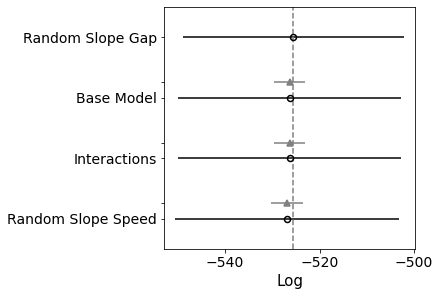

In [16]:
#Model comparison plot
az.plot_compare(compare_gap, insample_dev=False);

In [17]:
#Select model for further analysis
crossing_model = crossing_model
crossing_fitted = crossing_fitted

### Diagnostics

#### Priors

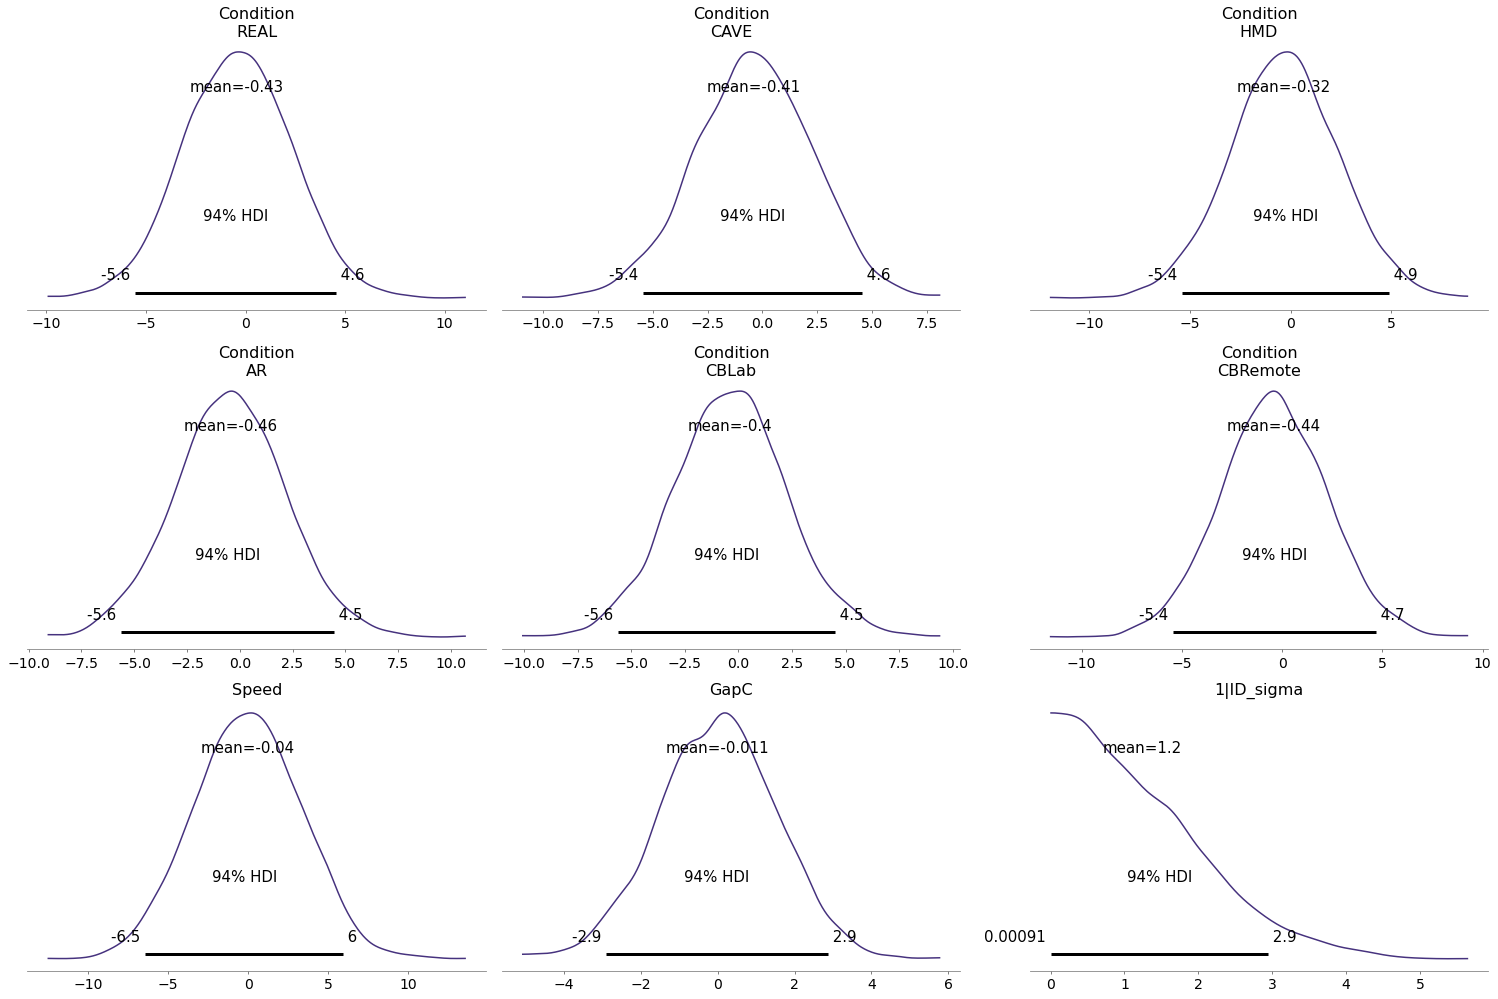

In [18]:
crossing_model.plot_priors();

In [19]:
crossing_model

Formula: Crossing ~ 0 + Condition + Speed + GapC + (1|ID)
Family name: Bernoulli
Link: logit
Observations: 1628
Priors:
  Condition ~ Normal(mu: -0.39830395, sigma: 2.64776732)
  Speed ~ Normal(mu: 0, sigma: 3.38464192)
  GapC ~ Normal(mu: 0, sigma: 1.56969468)
  1|ID ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1.52868918))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

#### Fitting

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


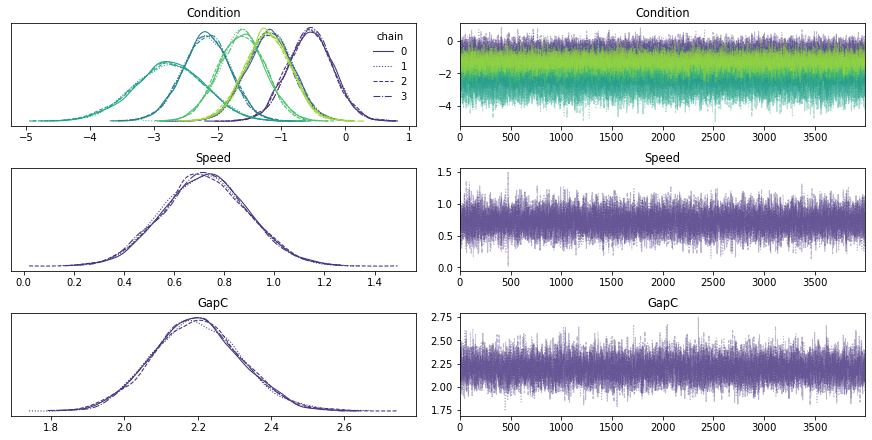

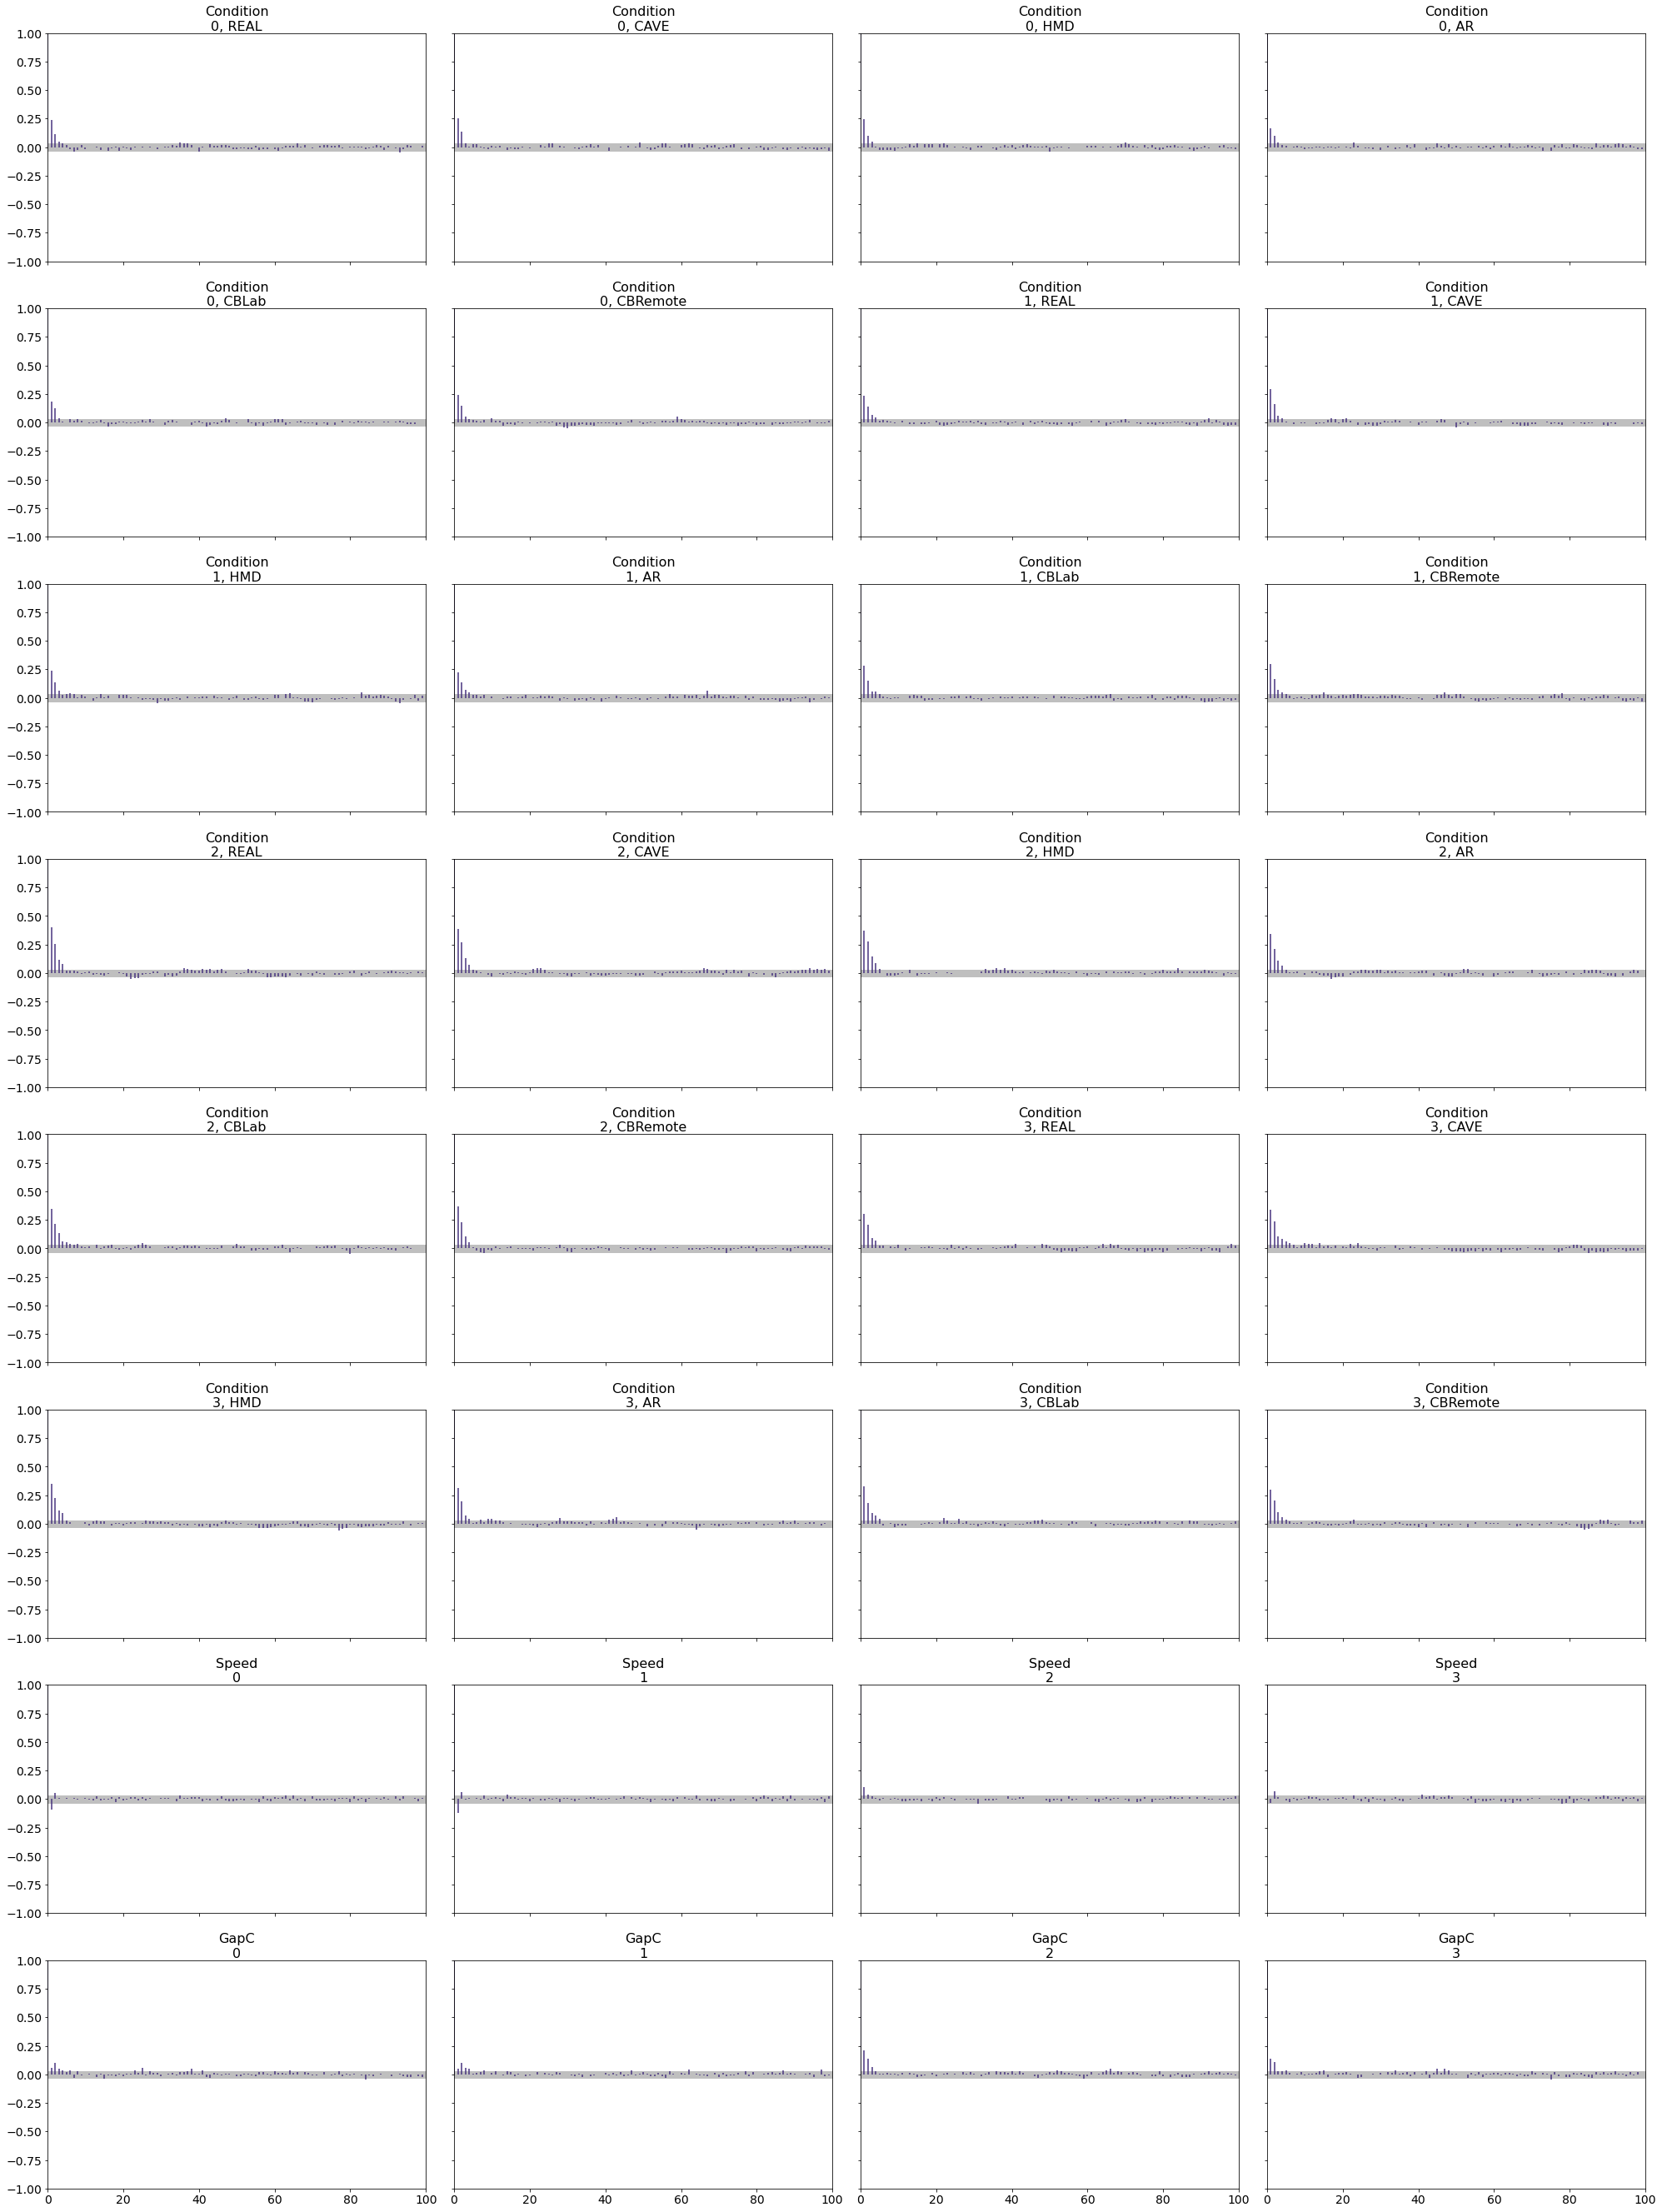

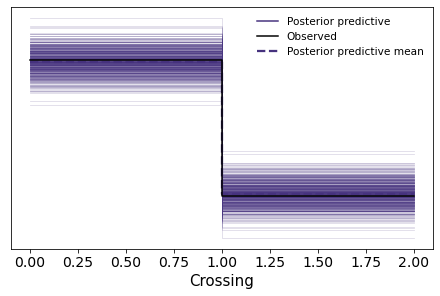

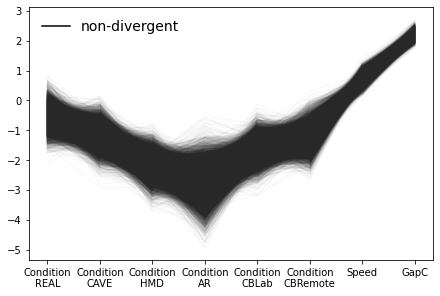

In [20]:
crossing_model.posterior_predictive(crossing_fitted, random_seed=RANDOM_SEED)

az.plot_trace(crossing_fitted,var_names=["~ID"], filter_vars="regex",legend=True, compact=True);
az.plot_autocorr(crossing_fitted,var_names=["~ID"], filter_vars="regex", combined = False);
az.plot_ppc(crossing_fitted);
az.plot_parallel(crossing_fitted,var_names=["~ID"], filter_vars="regex", legend = True);

### Inference

#### Posteriors

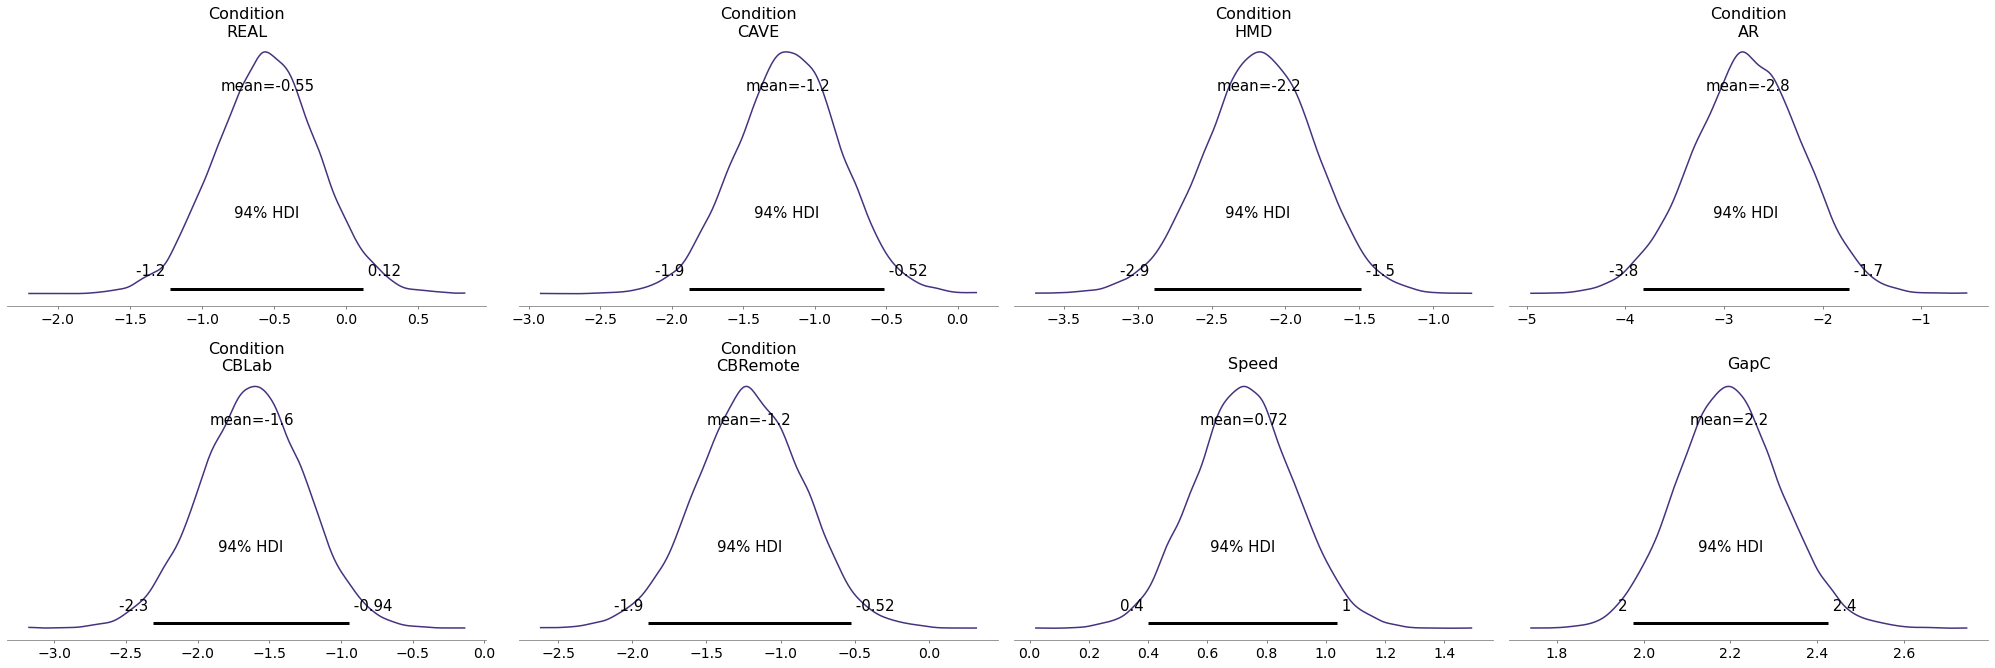

In [21]:
az.plot_posterior(crossing_fitted,var_names=["~ID"], filter_vars="regex");

#### Differences

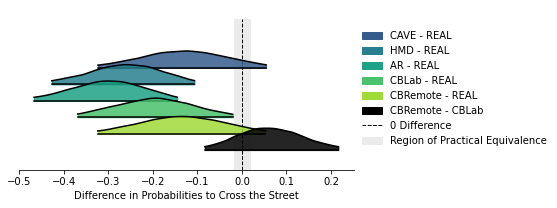

In [22]:
#Calculate differences of posterior distributions
Conditions = ['REAL','CAVE','HMD','AR','CBLab','CBRemote']
REAL, CAVE, HMD, AR, CBLab, CBRemote = [crossing_fitted.posterior['Condition'][:,:,x].values for x in [0,1,2,3,4,5]]
pREAL, pCAVE, pHMD, pAR, pCBLab, pCBRemote = [plogis(crossing_fitted.posterior['Condition'][:,:,x].values) for x in [0,1,2,3,4,5]]
crossing_std = df.groupby('ID')['Crossing'].mean().std()

#Plot
fig, ax = plt.subplots(figsize=(6, 3))
colors = sns.color_palette(palette = 'viridis')
colors.append('#000000')

ax.vlines(0,-10,18,'black', 'dashed', zorder=-10,lw=1)
az.plot_forest([pCAVE - pREAL,pHMD - pREAL,pAR - pREAL,pCBLab - pREAL,pCBRemote - pREAL, pCBRemote - pCBLab],
                model_names = ['Cave - Real','HMD - Real','AR - Real','CBLab - Real','CBRemote - Real','CBRemote - CBLab'],
                kind='ridgeplot',
                combined=True,
                ridgeplot_overlap=3,
                ridgeplot_alpha=0.85,
                colors=colors,
                ax=ax)
ax.spines['top'].set_color('white')
ax.add_patch(matplotlib.patches.Rectangle((-0.1*crossing_std,-10), 0.2*crossing_std, 28, zorder=-100,color="#ebebeb"))
ax.set_yticks([])
ax.set(xlabel='Difference in Probabilities to Cross the Street')

#Creating the Legend
cave_patch = mpatches.Patch(color=colors[1], label='CAVE - REAL')
hmd_patch = mpatches.Patch(color=colors[2], label='HMD - REAL')
ar_patch = mpatches.Patch(color=colors[3], label='AR - REAL')
cblab_patch = mpatches.Patch(color=colors[4], label='CBLab - REAL')
cbremote_patch = mpatches.Patch(color=colors[5], label='CBRemote - REAL')
cbdiff_patch = mpatches.Patch(color=colors[6], label='CBRemote - CBLab')
line = Line2D([0], [0], color='black',ls='dashed', lw=1, label='0 Difference')

rope_patch = mpatches.Patch(color="#ebebeb", label='Region of Practical Equivalence')
ax.legend(handles=[cave_patch,hmd_patch,ar_patch,cblab_patch,cbremote_patch,cbdiff_patch,line,rope_patch], 
          bbox_to_anchor=(1.3, 0.5),loc='center');

In [23]:
#Values of highest density intervals (HDIs)
HDIs = pd.DataFrame(np.array([np.concatenate((['pCAVE - pREAL'],az.hdi(az.convert_to_dataset(pCAVE - pREAL)).x.data)),
                       np.concatenate((['pHMD - pREAL'],az.hdi(az.convert_to_dataset(pHMD - pREAL)).x.data)),
                       np.concatenate((['pAR - pREAL'],az.hdi(az.convert_to_dataset(pAR - pREAL)).x.data)),
                       np.concatenate((['pCBLab - pREAL'],az.hdi(az.convert_to_dataset(pCBLab - pREAL)).x.data)),
                       np.concatenate((['pCBRemote - pREAL'],az.hdi(az.convert_to_dataset(pCBRemote - pREAL)).x.data)),
                       np.concatenate((['pCBRemote - pCBLab'],az.hdi(az.convert_to_dataset(pCBRemote - pCBLab)).x.data)),
                             ['ROPE',df.groupby('ID')['Crossing'].mean().std()*-0.1,df.groupby('ID')['Crossing'].mean().std()*0.1]]),
             columns=['Comparison', 'lowHDI', 'highHDI'])
HDIs = HDIs.astype({"lowHDI": 'float',"highHDI": 'float'})
HDIs.round(3)

Comparison  lowHDI  highHDI
0       pCAVE - pREAL  -0.324    0.055
1        pHMD - pREAL  -0.428   -0.105
2         pAR - pREAL  -0.469   -0.144
3      pCBLab - pREAL  -0.369   -0.019
4   pCBRemote - pREAL  -0.325    0.053
5  pCBRemote - pCBLab  -0.084    0.217
6                ROPE  -0.018    0.018

## Crossing Initiation Time (CIT)

### Models

In [24]:
cit_model = bmb.Model("CrossingInitiationTime ~ 0 + Condition + Speed + GapC + (1|ID)",df, dropna=True,
                     categorical=["Condition","Speed"],family="gaussian")
cit_fitted = cit_model.fit(draws=4000, target_accept=0.99, random_seed=RANDOM_SEED)
az.summary(cit_fitted,var_names=["~ID"], filter_vars="regex",)#.to_latex("cit_model_summary.tex")

Automatically removing 995/1628 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CrossingInitiationTime_sigma, 1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 152 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Condition[0]                 -0.437  0.073  -0.578   -0.303      0.001   
Condition[1]                  0.224  0.076   0.081    0.369      0.001   
Condition[2]                  0.015  0.077  -0.134    0.156      0.001   
Condition[3]                  0.212  0.121  -0.011    0.442      0.001   
Condition[4]                  0.050  0.078  -0.099    0.195      0.001   
Condition[5]                  0.154  0.077   0.013    0.302      0.001   
Speed                         0.212  0.025   0.165    0.258      0.000   
GapC                          0.057  0.016   0.028    0.087      0.000   
CrossingInitiationTime_sigma  0.300  0.010   0.281    0.318      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Condition[0]                    0.001    5512.0    8769.0    1.0  
Condition[1]                    0.001    5890.0    8499.0    1.0  
Condition[2]                    0.001    6729.0   10100.0    1.0  
Condition[3]                    0.001    7324.0    9783.0    1.0  
Condition[4]                    0.001    6086.0    8330.0    1.0  
Condition[5]                    0.001    5928.0   10118.0    1.0  
Speed                           0.000   29229.0   12922.0    1.0  
GapC                            0.000   23346.0   12697.0    1.0  
CrossingInitiationTime_sigma    0.000   13841.0   12538.0    1.0

In [25]:
cit_model_interactions = bmb.Model("CrossingInitiationTime ~ 0 + Condition + Speed + GapC + Condition:Speed + Condition:GapC + (1|ID)",
                                   df, dropna=True,categorical=["Condition","Speed"],family="gaussian")
cit_fitted_interactions = cit_model_interactions.fit(draws=4000, target_accept=0.99, random_seed=RANDOM_SEED)
az.summary(cit_fitted_interactions,var_names=["~ID"], filter_vars="regex")

Automatically removing 995/1628 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CrossingInitiationTime_sigma, 1|ID_offset, 1|ID_sigma, Condition:GapC, Condition:Speed, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 176 seconds.
The number of effective samples is smaller than 25% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Condition[0]                 -0.415  0.082  -0.572   -0.267      0.002   
Condition[1]                  0.102  0.088  -0.066    0.267      0.002   
Condition[2]                  0.012  0.103  -0.179    0.207      0.001   
Condition[3]                  0.147  0.183  -0.204    0.483      0.002   
Condition[4]                  0.061  0.096  -0.119    0.241      0.001   
Condition[5]                  0.327  0.102   0.134    0.517      0.001   
Speed                         0.222  0.051   0.127    0.319      0.001   
GapC                          0.034  0.031  -0.022    0.092      0.000   
Condition:Speed[0]            0.131  0.074  -0.009    0.271      0.001   
Condition:Speed[1]            0.024  0.079  -0.121    0.173      0.001   
Condition:Speed[2]            0.014  0.116  -0.198    0.235      0.001   
Condition:Speed[3]           -0.092  0.078  -0.234    0.058      0.001   
Condition:Speed[4]           -0.146  0.079  -0.299   -0.002      0.001   
Condition:GapC[0]             0.059  0.043  -0.019    0.143      0.001   
Condition:GapC[1]             0.011  0.053  -0.088    0.112      0.001   
Condition:GapC[2]             0.058  0.085  -0.099    0.220      0.001   
Condition:GapC[3]             0.053  0.048  -0.035    0.145      0.001   
Condition:GapC[4]            -0.044  0.052  -0.139    0.056      0.001   
CrossingInitiationTime_sigma  0.297  0.010   0.279    0.316      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Condition[0]                    0.001    2806.0    5667.0    1.0  
Condition[1]                    0.001    3437.0    7299.0    1.0  
Condition[2]                    0.001    4914.0    8841.0    1.0  
Condition[3]                    0.002    5654.0    8196.0    1.0  
Condition[4]                    0.001    4142.0    7410.0    1.0  
Condition[5]                    0.001    4706.0    7506.0    1.0  
Speed                           0.001    5023.0    7923.0    1.0  
GapC                            0.000    5426.0    8826.0    1.0  
Condition:Speed[0]              0.001    7321.0    9478.0    1.0  
Condition:Speed[1]              0.001    7732.0   10980.0    1.0  
Condition:Speed[2]              0.001    9289.0   10901.0    1.0  
Condition:Speed[3]              0.001    7148.0    9992.0    1.0  
Condition:Speed[4]              0.001    7068.0   10586.0    1.0  
Condition:GapC[0]               0.000    6815.0    9914.0    1.0  
Condition:GapC[1]               0.000    7686.0    9066.0    1.0  
Condition:GapC[2]               0.001    9765.0   11419.0    1.0  
Condition:GapC[3]               0.000    7059.0   10719.0    1.0  
Condition:GapC[4]               0.000    7681.0   10758.0    1.0  
CrossingInitiationTime_sigma    0.000   12151.0   12268.0    1.0

In [26]:
cit_model_slope_gap = bmb.Model("CrossingInitiationTime ~ 0 + Condition + Speed + GapC + (GapC|ID)",df, dropna=True,
                                  categorical=["Condition","Speed"],family="gaussian")
cit_fitted_slope_gap = cit_model_slope_gap.fit(cores=4,draws=4000, target_accept=0.99, random_seed=RANDOM_SEED)
az.summary(cit_fitted_slope_gap,var_names=["~ID"], filter_vars="regex")

Automatically removing 995/1628 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CrossingInitiationTime_sigma, GapC|ID_offset, GapC|ID_sigma, 1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 149 seconds.
The number of effective samples is smaller than 10% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Condition[0]                 -0.437  0.072  -0.571   -0.300      0.001   
Condition[1]                  0.222  0.075   0.083    0.365      0.001   
Condition[2]                  0.013  0.078  -0.135    0.158      0.001   
Condition[3]                  0.213  0.121  -0.018    0.438      0.002   
Condition[4]                  0.049  0.076  -0.091    0.196      0.001   
Condition[5]                  0.155  0.077   0.014    0.302      0.001   
Speed                         0.213  0.024   0.168    0.260      0.000   
GapC                          0.057  0.016   0.027    0.088      0.000   
CrossingInitiationTime_sigma  0.298  0.010   0.280    0.317      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Condition[0]                    0.001    4067.0    6629.0    1.0  
Condition[1]                    0.001    3737.0    7156.0    1.0  
Condition[2]                    0.001    4466.0    7806.0    1.0  
Condition[3]                    0.001    5703.0    8291.0    1.0  
Condition[4]                    0.001    4435.0    8336.0    1.0  
Condition[5]                    0.001    4520.0    8057.0    1.0  
Speed                           0.000   23108.0   12679.0    1.0  
GapC                            0.000   14670.0   12748.0    1.0  
CrossingInitiationTime_sigma    0.000   10265.0   11834.0    1.0

In [27]:
cit_model_slope_speed = bmb.Model("CrossingInitiationTime ~ 0 + Condition + Speed + GapC + (Speed|ID)",df, dropna=True,
                                  categorical=["Condition","Speed"],family="gaussian")
cit_fitted_slope_speed = cit_model_slope_speed.fit(draws=4000, target_accept=0.99, random_seed=RANDOM_SEED)
az.summary(cit_fitted_slope_speed,var_names=["~ID"], filter_vars="regex")

Automatically removing 995/1628 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CrossingInitiationTime_sigma, Speed[50]|ID_offset, Speed[50]|ID_sigma, 1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 153 seconds.
The number of effective samples is smaller than 25% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Condition[0]                 -0.440  0.074  -0.578   -0.299      0.001   
Condition[1]                  0.219  0.076   0.075    0.363      0.001   
Condition[2]                  0.016  0.079  -0.129    0.168      0.001   
Condition[3]                  0.213  0.123  -0.012    0.446      0.002   
Condition[4]                  0.052  0.078  -0.096    0.194      0.001   
Condition[5]                  0.158  0.078   0.008    0.304      0.001   
Speed                         0.212  0.025   0.165    0.259      0.000   
GapC                          0.057  0.016   0.027    0.086      0.000   
CrossingInitiationTime_sigma  0.296  0.010   0.277    0.316      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Condition[0]                    0.001    3868.0    7163.0    1.0  
Condition[1]                    0.001    4270.0    7546.0    1.0  
Condition[2]                    0.001    3805.0    7547.0    1.0  
Condition[3]                    0.001    5353.0    8864.0    1.0  
Condition[4]                    0.001    4458.0    7570.0    1.0  
Condition[5]                    0.001    4399.0    7821.0    1.0  
Speed                           0.000   20819.0   13532.0    1.0  
GapC                            0.000   15618.0   12362.0    1.0  
CrossingInitiationTime_sigma    0.000    6368.0    8392.0    1.0

In [28]:
#Model comparison
compare_dict = {"No Interactions": cit_fitted,
                "Interactions": cit_fitted_interactions,
                "Random Slope Gap": cit_fitted_slope_gap,
                "Random Slope Speed":cit_fitted_slope_speed}
compare_cit = az.compare(compare_dict, ic="loo",seed = RANDOM_SEED)
compare_cit

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work 

rank         loo       p_loo     d_loo        weight  \
Random Slope Speed     0 -223.274175  151.125808  0.000000  5.221210e-01   
Interactions           1 -224.506407  149.784368  1.232232  4.778790e-01   
No Interactions        2 -225.105002  143.977839  1.830827  2.110342e-15   
Random Slope Gap       3 -225.284875  148.637365  2.010700  0.000000e+00   

                           se       dse  warning loo_scale  
Random Slope Speed  33.949787  0.000000     True       log  
Interactions        34.656551  5.514370     True       log  
No Interactions     34.519799  1.387606     True       log  
Random Slope Gap    34.218193  1.508959     True       log

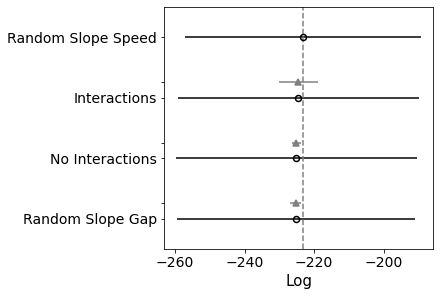

In [29]:
#Model comparison plot
az.plot_compare(compare_cit, insample_dev=False);

In [30]:
#Select model for further analysis
cit_model = cit_model
cit_fitted = cit_fitted

### Diagnostics

#### Priors

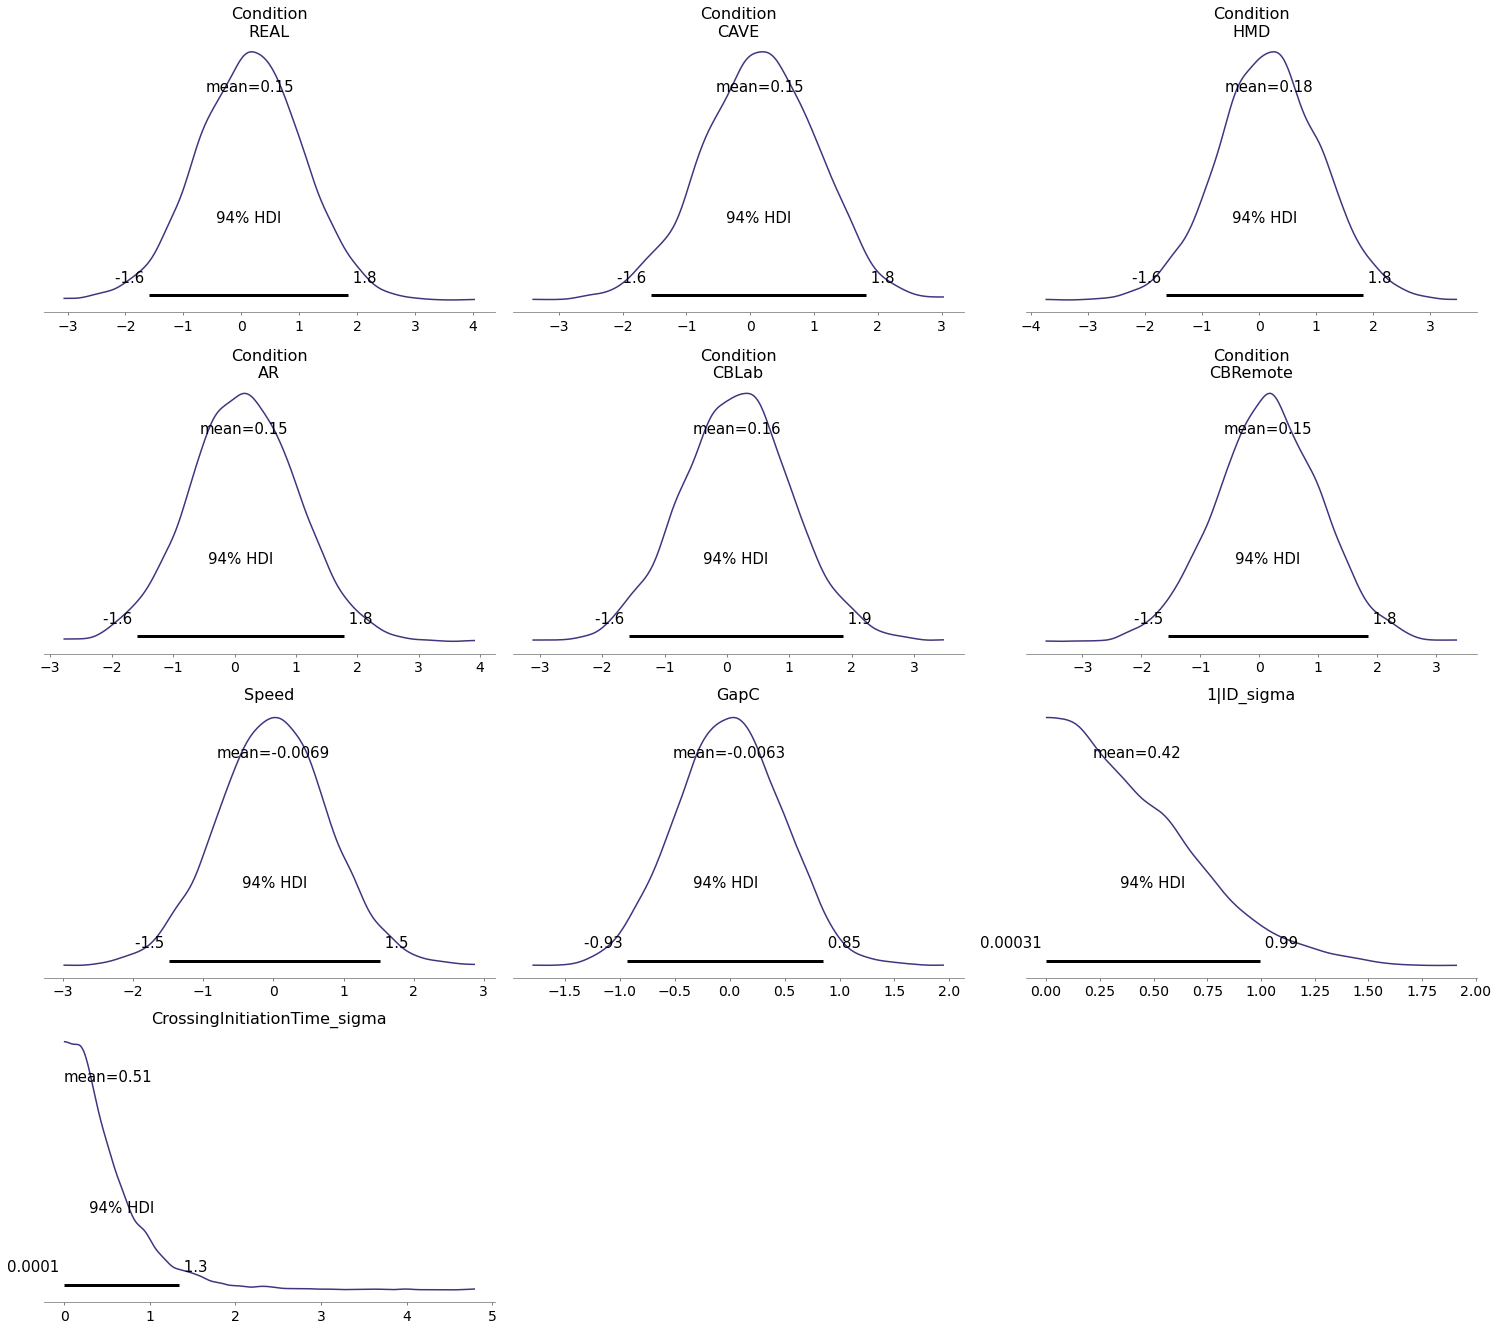

In [31]:
cit_model.plot_priors();

In [32]:
cit_model

Formula: CrossingInitiationTime ~ 0 + Condition + Speed + GapC + (1|ID)
Family name: Gaussian
Link: identity
Observations: 633
Priors:
  Condition ~ Normal(mu: 0.15890205, sigma: 0.89545075)
  Speed ~ Normal(mu: 0, sigma: 0.78679452)
  GapC ~ Normal(mu: 0, sigma: 0.48447313)
  1|ID ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.51698873))
  sigma ~ HalfStudentT(nu: 4, sigma: 0.51529765)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

#### Fitting

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


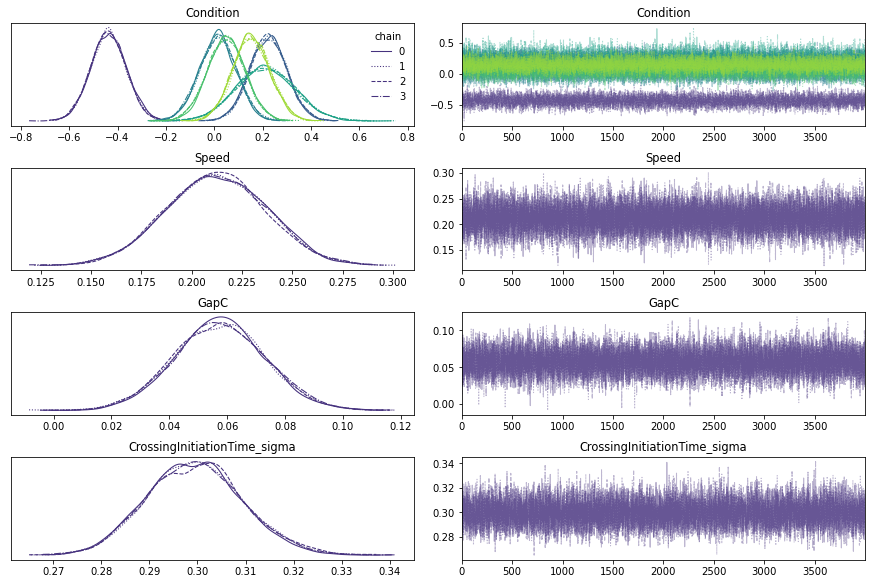

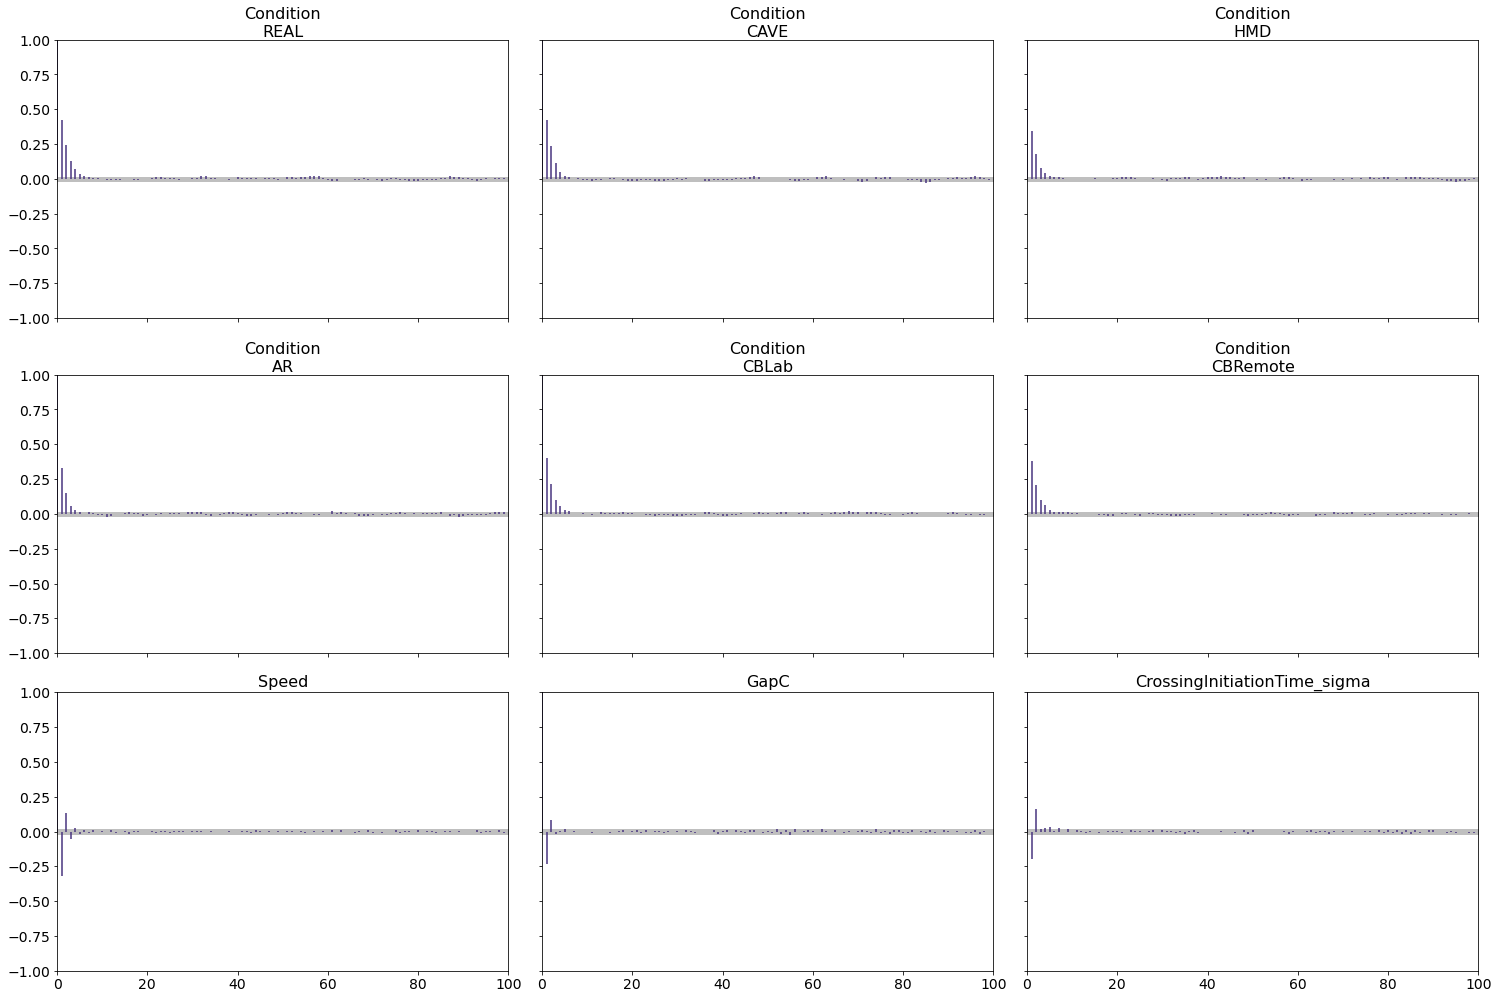

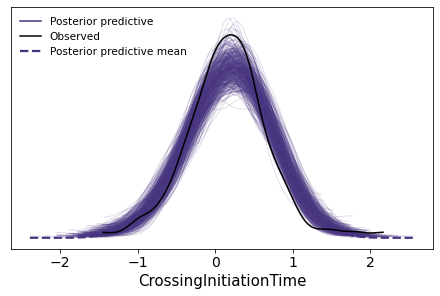

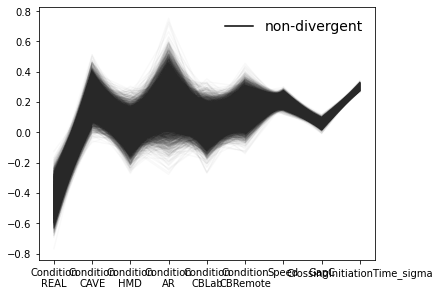

In [33]:
posterior_predictive = cit_model.posterior_predictive(cit_fitted, random_seed=RANDOM_SEED)
az.plot_trace(cit_fitted,var_names=["~ID"], filter_vars="regex",
              legend=True, compact=True);
az.plot_autocorr(cit_fitted,var_names=["~ID"], filter_vars="regex", combined = True);
az.plot_ppc(cit_fitted);
az.plot_parallel(cit_fitted,var_names=["~ID"], filter_vars="regex", legend = True);

#### High influential data points

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


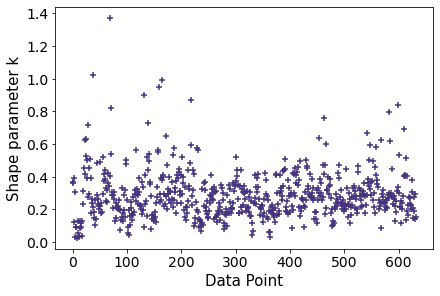

In [34]:
# compute pointwise LOO
loo = az.loo(cit_fitted, pointwise=True)
# plot kappa values
az.plot_khat(loo.pareto_k);

In [35]:
df[df['CrossingInitiationTime'].notnull()].reset_index()[loo.pareto_k.values>=0.7]

index  Trial Speed  Gap  Crossing  CrossingInitiationTime Condition  \
28      67     10    30    5         1                  -1.001      CAVE   
38     109     12    30    5         1                   1.967      CAVE   
69     182      5    50    4         1                   2.166      CAVE   
70     186      9    30    5         1                  -0.668      CAVE   
132    311     11    50    4         1                   1.503       HMD   
138    335      5    50    5         1                   1.771       HMD   
159    389      9    30    5         1                   1.415       HMD   
164    408      8    50    5         1                  -0.769       HMD   
217    565      7    50    4         1                   1.374       HMD   
462   1156     11    50    4         1                  -0.056  CBRemote   
583   1501      6    50    5         1                   0.058  CBRemote   
599   1552      7    30    5         1                   2.134  CBRemote   

              ID  GapC  
28       14_CAVE     2  
38       20_CAVE     2  
69       41_CAVE     1  
70       41_CAVE     2  
132       62_HMD     1  
138       33_HMD     2  
159        8_HMD     2  
164        9_HMD     2  
217       29_HMD     1  
462  13_CBRemote     1  
583  48_CBRemote     2  
599  53_CBRemote     2

### Inference

#### Posteriors

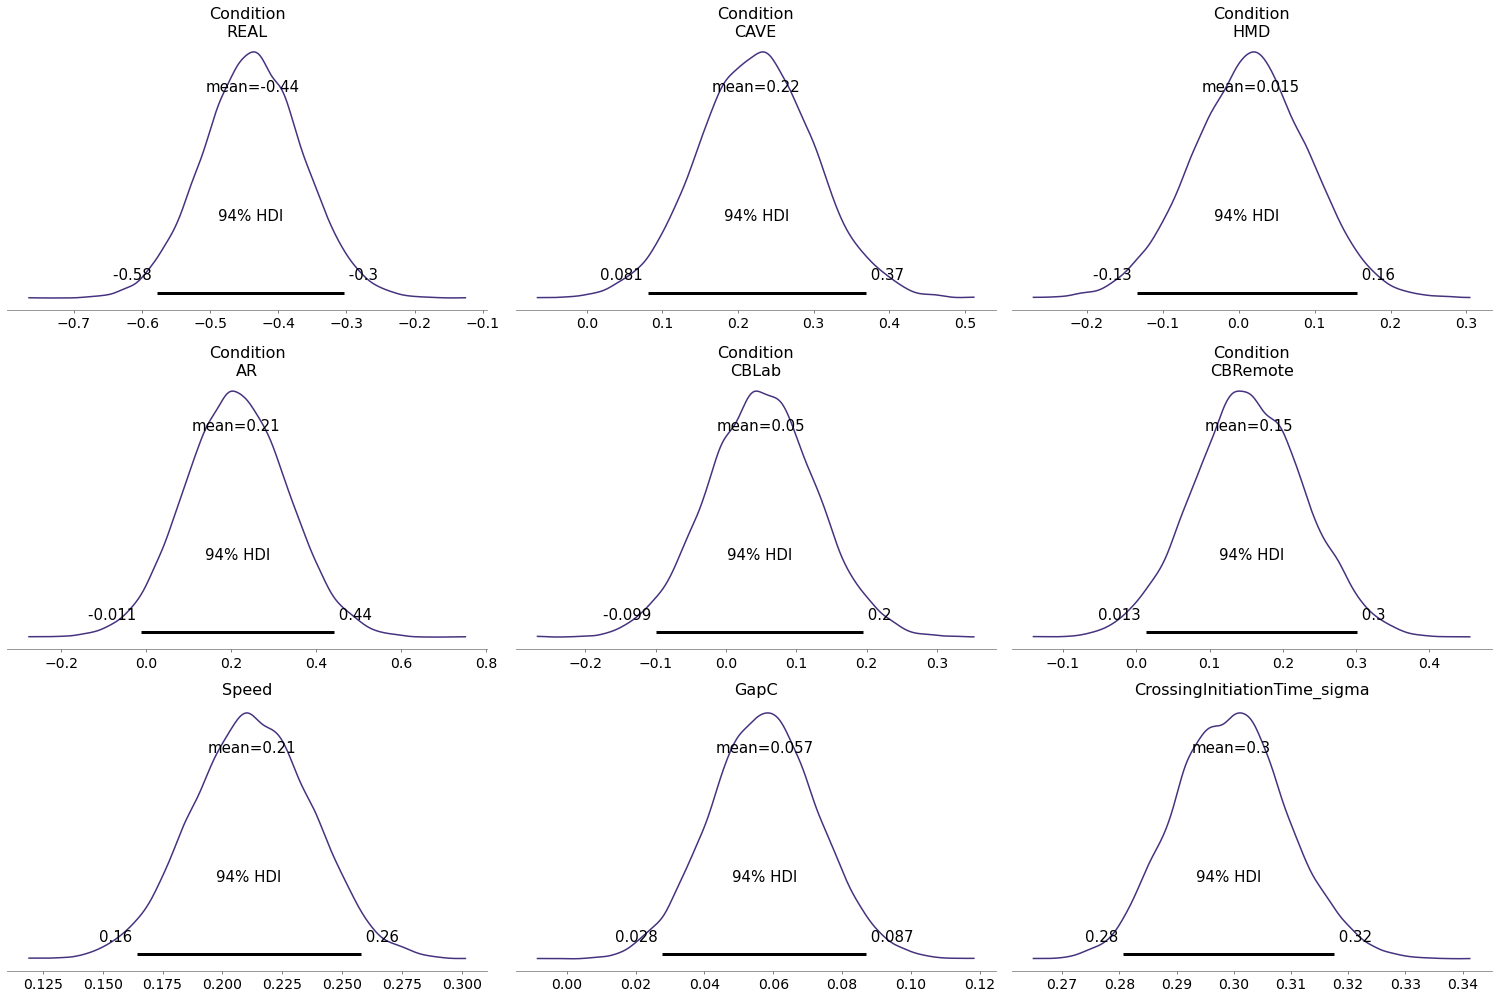

In [36]:
az.plot_posterior(cit_fitted,var_names=["~ID"], filter_vars="regex");

#### Differences

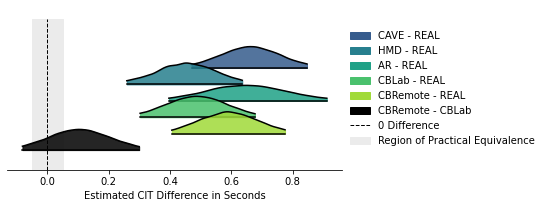

In [37]:
#Posterior distributions for conditions
Conditions = ['REAL','CAVE','HMD','AR','CBLab','CBRemote']
REAL, CAVE, HMD, AR, CBLab, CBRemote = [cit_fitted.posterior['Condition'][:,:,diff].values for diff in [0,1,2,3,4,5]]

#CIT sd to define the ROPE
cit_sd = df['CrossingInitiationTime'].std()

#Plot
fig, ax = plt.subplots(figsize=(6, 3))
colors = sns.color_palette(palette = 'viridis')
colors.append('#000000')

ax.vlines(0,-10,18,'black', 'dashed', zorder=-10,lw=1)
az.plot_forest([CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL, CBRemote - CBLab],
                model_names = ['Cave - Real','HMD - Real','AR - Real','CBLab - Real','CBRemote - Real','CBRemote - CBLab'],
                kind='ridgeplot',
                combined=True,
                ridgeplot_overlap=3,
                ridgeplot_alpha=0.85,
                colors=colors,
                ax=ax)
ax.spines['top'].set_color('white')
ax.add_patch(matplotlib.patches.Rectangle((-0.1*cit_sd,-10), 0.2*cit_sd, 28, zorder=-100,color="#ebebeb"))
ax.set_yticks([])
ax.set(xlabel='Estimated CIT Difference in Seconds')

#Legend
cave_patch = mpatches.Patch(color=colors[1], label='CAVE - REAL')
hmd_patch = mpatches.Patch(color=colors[2], label='HMD - REAL')
ar_patch = mpatches.Patch(color=colors[3], label='AR - REAL')
cblab_patch = mpatches.Patch(color=colors[4], label='CBLab - REAL')
cbremote_patch = mpatches.Patch(color=colors[5], label='CBRemote - REAL')
cbdiff_patch = mpatches.Patch(color=colors[6], label='CBRemote - CBLab')
line = Line2D([0], [0], color='black',ls='dashed', lw=1, label='0 Difference')

rope_patch = mpatches.Patch(color="#ebebeb", label='Region of Practical Equivalence')
ax.legend(handles=[cave_patch,hmd_patch,ar_patch,cblab_patch,cbremote_patch,cbdiff_patch,line,rope_patch], 
          bbox_to_anchor=(1.3, 0.5),loc='center');

In [38]:
#HDI values 
HDIs = pd.DataFrame(np.array([np.concatenate((['CAVE - REAL'],az.hdi(az.convert_to_dataset(CAVE - REAL)).x.data)),
                       np.concatenate((['HMD - REAL'],az.hdi(az.convert_to_dataset(HMD - REAL)).x.data)),
                       np.concatenate((['AR - REAL'],az.hdi(az.convert_to_dataset(AR - REAL)).x.data)),
                       np.concatenate((['CBLab - REAL'],az.hdi(az.convert_to_dataset(CBLab - REAL)).x.data)),
                       np.concatenate((['CBRemote - REAL'],az.hdi(az.convert_to_dataset(CBRemote - REAL)).x.data)),
                       np.concatenate((['CBRemote - CBLab'],az.hdi(az.convert_to_dataset(CBRemote - CBLab)).x.data)),
                             ['ROPE',cit_sd*-0.1,cit_sd*0.1]]),
             columns=['Comparison', 'lowHDI', 'highHDI'])
HDIs = HDIs.astype({"lowHDI": 'float',"highHDI": 'float'})
HDIs.round(3)

Comparison  lowHDI  highHDI
0       CAVE - REAL   0.471    0.849
1        HMD - REAL   0.258    0.637
2         AR - REAL   0.395    0.914
3      CBLab - REAL   0.302    0.678
4   CBRemote - REAL   0.406    0.777
5  CBRemote - CBLab  -0.082    0.300
6              ROPE  -0.052    0.052

## Subjective Data

Q1: How safe would it have been to cross the street?

Q2: How likely would a collision have been?

Q3: How dangerous would a collision have been?

Q4: How similar to real world traffic was your behavior in cases when you crossed the street?

Q5: How similar to real world traffic was your behavior in cases when you did not cross the street?

Q6: Compared to usual, my choices were safe / unsafe

Q7: Compared to usual, deciding to cross the street was easy / difficult

Q8: Compared to usual, making a decision took longer / shorter

In [39]:
#Create Dummy codes for Simulator Conditions
dummies = pd.get_dummies(df_subjectives['Condition'])

#Function to show HDIs of later comparisons
def printHDIs(q):  
    HDIs = pd.DataFrame(np.array([np.concatenate((['CAVE - REAL'],az.hdi(az.convert_to_dataset(CAVE - REAL)).x.data)),
                           np.concatenate((['HMD - REAL'],az.hdi(az.convert_to_dataset(HMD - REAL)).x.data)),
                           np.concatenate((['AR - REAL'],az.hdi(az.convert_to_dataset(AR - REAL)).x.data)),
                           np.concatenate((['CBLab - REAL'],az.hdi(az.convert_to_dataset(CBLab - REAL)).x.data)),
                           np.concatenate((['CBRemote - REAL'],az.hdi(az.convert_to_dataset(CBRemote - REAL)).x.data)),
                           np.concatenate((['CBRemote - CBLab'],az.hdi(az.convert_to_dataset(CBRemote - CBLab)).x.data)),
                                 ['ROPE',df_subjectives[q].std()*-0.1,df_subjectives[q].std()*0.1]]),
                 columns=['Comparison', 'lowHDI', 'highHDI'])
    HDIs = HDIs.astype({"lowHDI": 'float',"highHDI": 'float'})
    HDIs["Result"] = ""
    for index, row in HDIs.iterrows():
        result = 'inconclusive'
        if (row.lowHDI>df_subjectives[q].std()*-0.1 and row.highHDI < df_subjectives[q].std()*0.1):
            result = 'equal'
        if (row.lowHDI>df_subjectives[q].std()*0.1):
            result = 'larger'
        if (row.highHDI<df_subjectives[q].std()*-0.1):
            result = 'smaller'
        HDIs.iat[index, 3] = result
    display(HDIs.round(3))

### How safe would it have been to cross the street?

In [40]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q1"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

1   -4.39
2   -1.71
3    1.19
4     inf
Name: Q1, dtype: float64

In [41]:
#c.f. https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_12.ipynb Code 12.24
with pm.Model() as Q1_model:
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=3,
        testval=np.arange(3),
    )
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies.CBRemote.values)
    
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)

    Q1 = pm.OrderedLogistic("Q1", eta, cutpoints, observed=df_subjectives["Q1"].values -1)
    
    trace_Q1 = pm.sample(return_inferencedata=True, tune = 1000, target_accept=0.85, random_seed=RANDOM_SEED)


REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q1.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]
Q1_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

az.summary(trace_Q1, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL         0.81  0.34    0.18     1.48       0.01     0.00   3894.41   
bCAVE        -0.33  0.34   -0.99     0.27       0.01     0.00   3997.02   
bHMD          0.03  0.34   -0.61     0.65       0.01     0.01   3982.64   
bAR           0.28  0.41   -0.49     1.02       0.01     0.01   4351.62   
bCBLab       -0.52  0.34   -1.17     0.11       0.01     0.00   3793.10   
bCBRemote     0.18  0.34   -0.47     0.78       0.01     0.00   4212.81   
cutpoints[0] -3.95  0.53   -4.93    -2.96       0.01     0.01   3001.34   
cutpoints[1] -1.67  0.28   -2.21    -1.16       0.00     0.00   3160.10   
cutpoints[2]  1.32  0.27    0.78     1.80       0.00     0.00   3020.97   

              ess_tail  r_hat  
bREAL          2883.32    1.0  
bCAVE          2926.13    1.0  
bHMD           2732.10    1.0  
bAR            2390.01    1.0  
bCBLab         2834.48    1.0  
bCBRemote      3020.49    1.0  
cutpoints[0]   2087.57    1.0  
cutpoints[1]   2798.43    1.0  
cutpoints[2]   2890.46    1.0

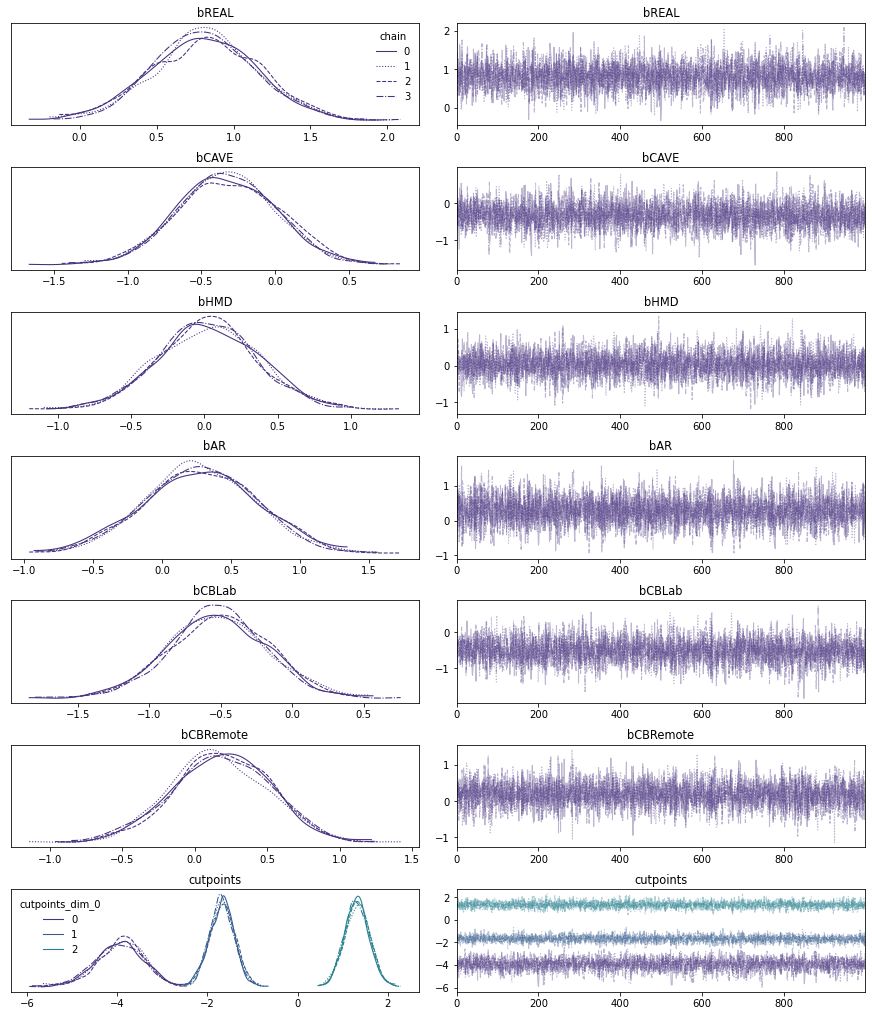

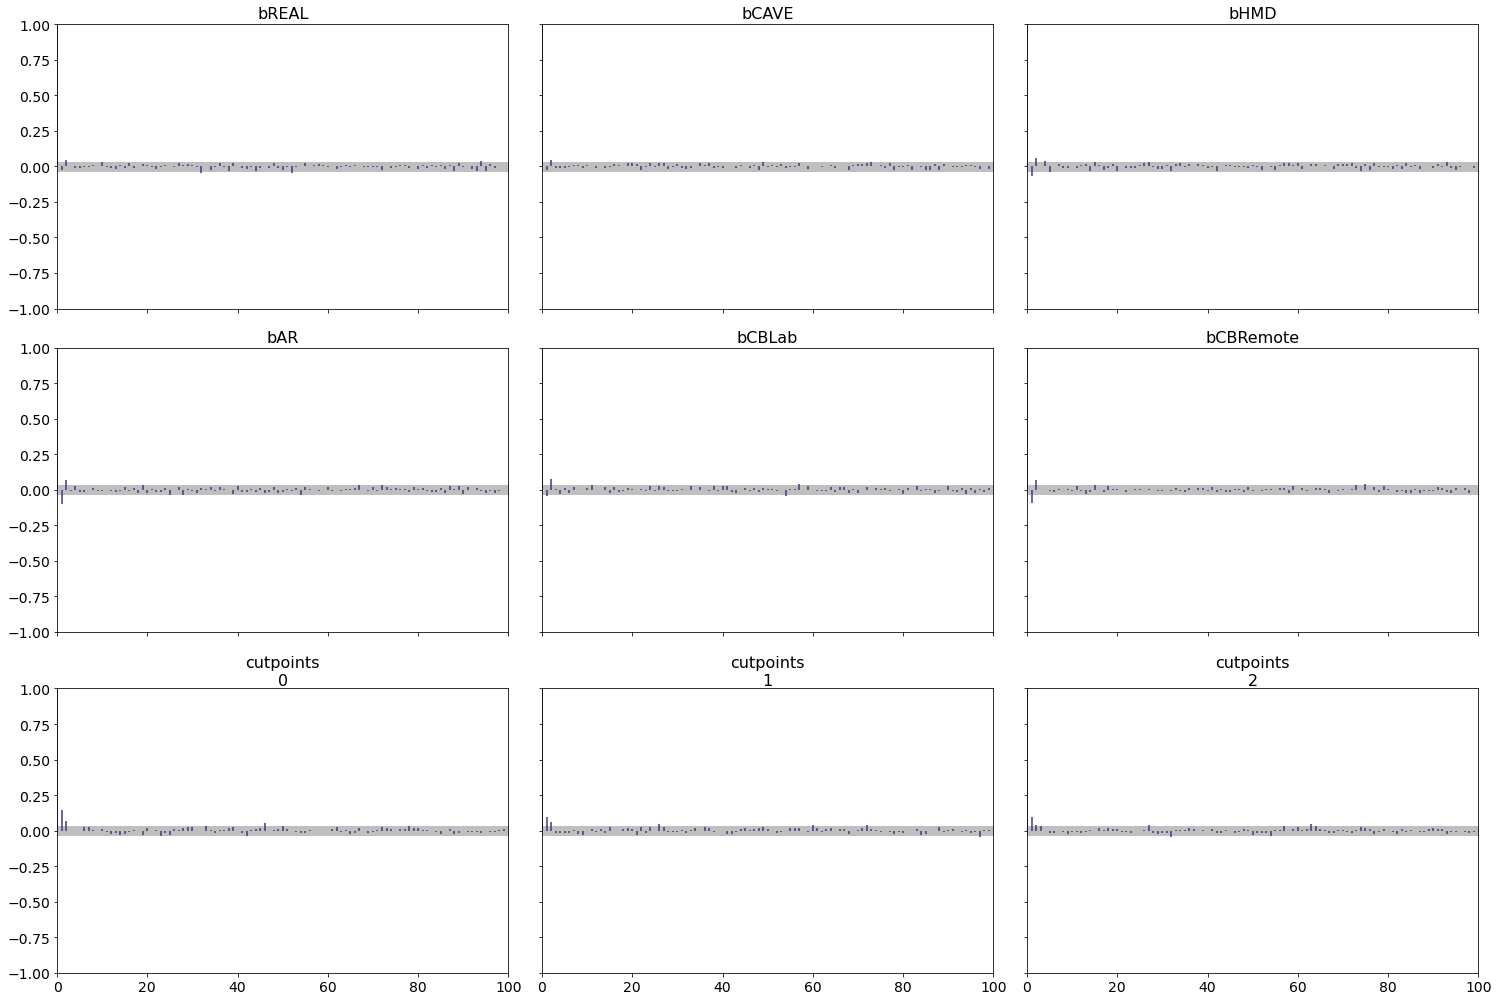

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


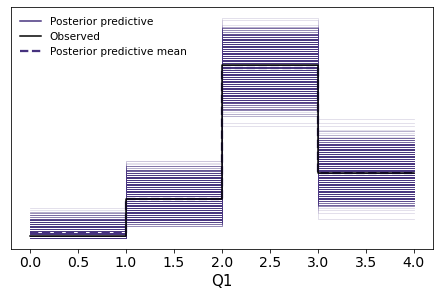

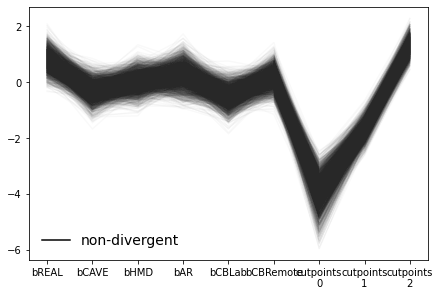

In [42]:
with Q1_model:
    ppc = pm.sample_posterior_predictive(trace_Q1, random_seed=RANDOM_SEED)

az.plot_trace(trace_Q1,var_names=["~eta"], filter_vars="regex",legend=True, compact=True);
az.plot_autocorr(trace_Q1,var_names=["~eta"], filter_vars="regex", combined = True);
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q1_model));
az.plot_parallel(trace_Q1,var_names=["~eta"], filter_vars="regex", legend = True);

In [43]:
printHDIs('Q1')

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -1.886   -0.353       smaller
1        HMD - REAL  -1.585   -0.013  inconclusive
2         AR - REAL  -1.468    0.340  inconclusive
3      CBLab - REAL  -2.119   -0.539       smaller
4   CBRemote - REAL  -1.419    0.155  inconclusive
5  CBRemote - CBLab  -0.111    1.481  inconclusive
6              ROPE  -0.065    0.065  inconclusive

### How likely would a collision have been?

In [44]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q2"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

1   -0.57
2    2.03
3    3.45
4     inf
Name: Q2, dtype: float64

In [45]:
with pm.Model() as Q2_model:
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=3,
        testval=np.arange(3),
    )
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies.CBRemote.values)
    
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)

    Q2 = pm.OrderedLogistic("Q2", eta, cutpoints, observed=df_subjectives["Q2"].values -1)
    
    trace_Q2 = pm.sample(return_inferencedata=True, tune = 1000, target_accept=0.85, random_seed=RANDOM_SEED)


REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q2.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]
Q2_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

az.summary(trace_Q2, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL        -0.22  0.34   -0.88     0.40       0.01     0.00   4085.87   
bCAVE         0.30  0.33   -0.35     0.89       0.01     0.00   3813.54   
bHMD          0.25  0.33   -0.37     0.85       0.00     0.00   4400.71   
bAR          -0.48  0.40   -1.22     0.26       0.01     0.00   5868.24   
bCBLab       -0.03  0.34   -0.65     0.61       0.01     0.01   3746.01   
bCBRemote    -0.31  0.33   -0.93     0.31       0.00     0.00   4635.88   
cutpoints[0] -0.64  0.26   -1.09    -0.13       0.00     0.00   3104.34   
cutpoints[1]  1.95  0.31    1.35     2.51       0.00     0.00   4367.20   
cutpoints[2]  3.29  0.44    2.52     4.15       0.01     0.00   5734.66   

              ess_tail  r_hat  
bREAL          3393.15    1.0  
bCAVE          3241.99    1.0  
bHMD           3366.32    1.0  
bAR            2877.50    1.0  
bCBLab         2875.08    1.0  
bCBRemote      3132.19    1.0  
cutpoints[0]   3249.66    1.0  
cutpoints[1]   3425.49    1.0  
cutpoints[2]   3086.23    1.0

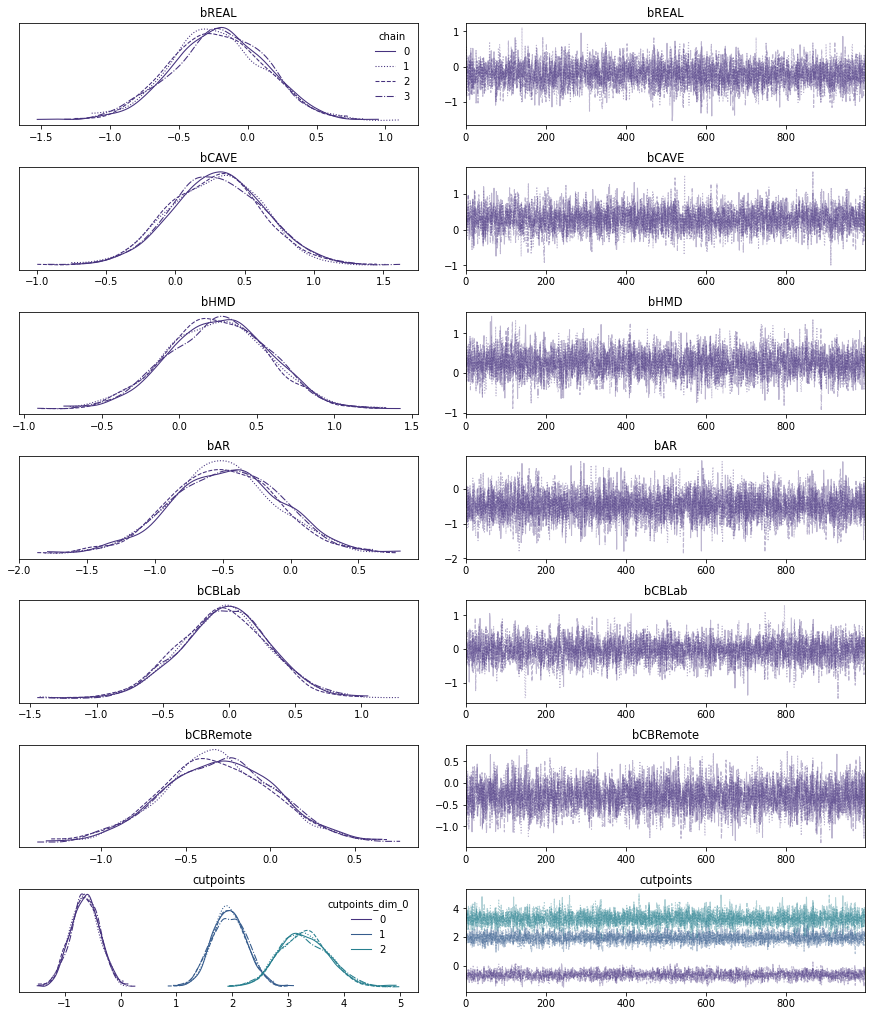

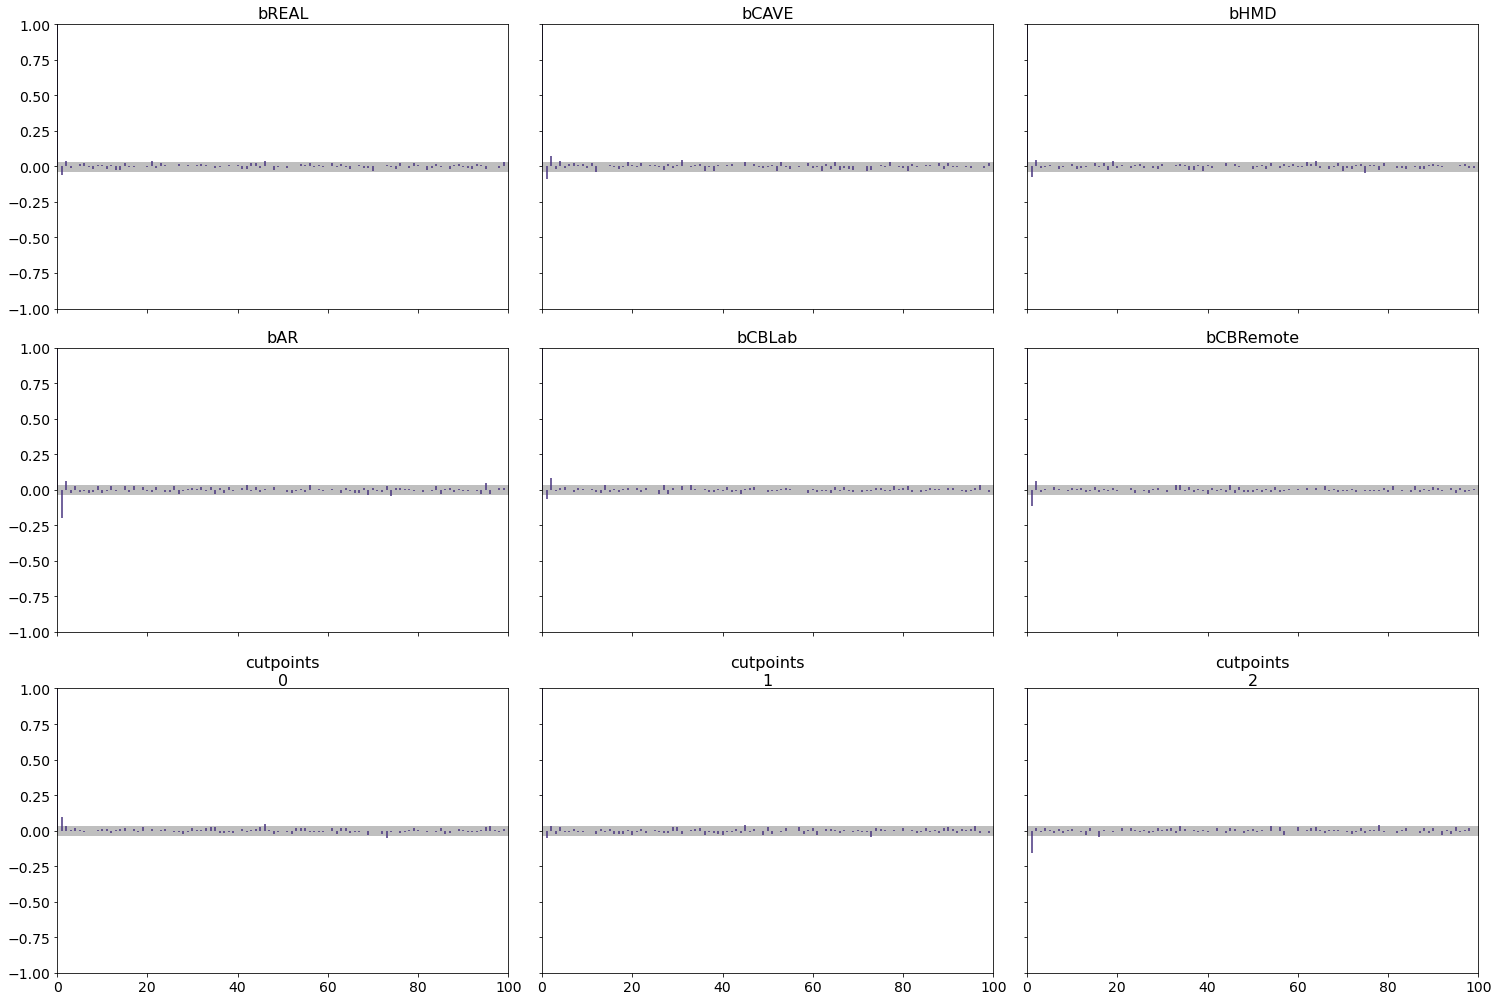

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


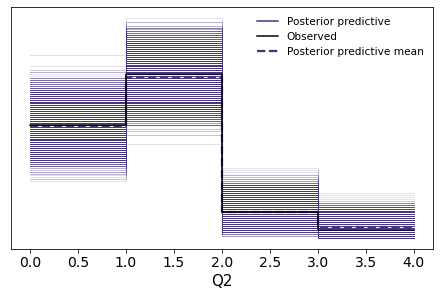

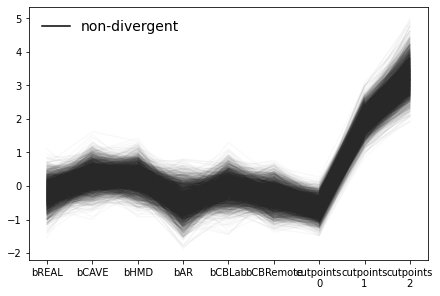

In [46]:
with Q2_model:
    ppc = pm.sample_posterior_predictive(trace_Q2, random_seed=RANDOM_SEED)

az.plot_trace(trace_Q2,var_names=["~eta"], filter_vars="regex",legend=True, compact=True);
az.plot_autocorr(trace_Q2,var_names=["~eta"], filter_vars="regex", combined = True);
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q2_model));
az.plot_parallel(trace_Q2,var_names=["~eta"], filter_vars="regex", legend = True);

In [47]:
printHDIs('Q2')

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -0.219    1.303  inconclusive
1        HMD - REAL  -0.333    1.206  inconclusive
2         AR - REAL  -1.139    0.692  inconclusive
3      CBLab - REAL  -0.605    0.923  inconclusive
4   CBRemote - REAL  -0.852    0.678  inconclusive
5  CBRemote - CBLab  -1.032    0.523  inconclusive
6              ROPE  -0.073    0.073  inconclusive

### How dangerous would a collision have been?

In [48]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q3"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

2.0   -1.12
1.0   -0.89
3.0    1.40
4.0     inf
Name: Q3, dtype: float64

In [49]:
#delete nan rows
nanIDX = np.argwhere(np.isnan(df_subjectives["Q3"].values))[0][0]
obs = np.delete(df_subjectives["Q3"].values, nanIDX)
dummies_ = dummies.drop([nanIDX])

In [50]:
with pm.Model() as Q3_model:
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=3,
        testval=np.arange(3),
    )
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies_.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies_.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies_.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies_.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies_.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies_.CBRemote.values)
    
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)

    Q3 = pm.OrderedLogistic("Q3", eta, cutpoints, observed=obs -1)
    
    trace_Q3 = pm.sample(return_inferencedata=True, tune = 1000, random_seed=RANDOM_SEED)


REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q3.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]
Q3_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

az.summary(trace_Q3, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL         0.22  0.33   -0.40     0.84       0.01     0.00   3252.36   
bCAVE        -0.47  0.33   -1.06     0.16       0.01     0.00   2674.22   
bHMD         -0.19  0.32   -0.79     0.40       0.01     0.00   2824.10   
bAR           0.43  0.40   -0.41     1.12       0.01     0.01   3418.23   
bCBLab        0.26  0.33   -0.36     0.85       0.01     0.00   2731.69   
bCBRemote     0.03  0.33   -0.58     0.64       0.01     0.01   3301.59   
cutpoints[0] -3.03  0.40   -3.81    -2.32       0.01     0.01   1811.62   
cutpoints[1] -0.90  0.26   -1.36    -0.39       0.01     0.00   2068.33   
cutpoints[2]  1.44  0.27    0.97     1.98       0.01     0.00   2457.94   

              ess_tail  r_hat  
bREAL          3113.83    1.0  
bCAVE          2670.88    1.0  
bHMD           2752.75    1.0  
bAR            2512.16    1.0  
bCBLab         2426.97    1.0  
bCBRemote      2712.17    1.0  
cutpoints[0]   1741.95    1.0  
cutpoints[1]   2706.51    1.0  
cutpoints[2]   2487.59    1.0

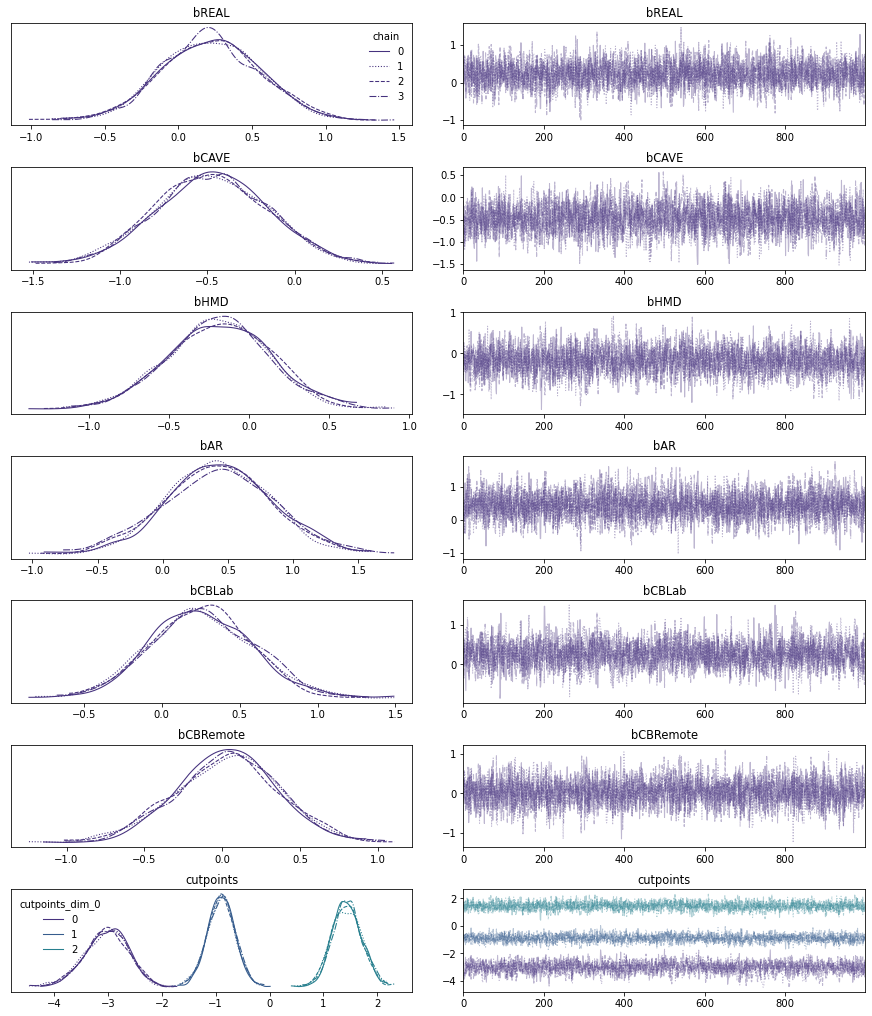

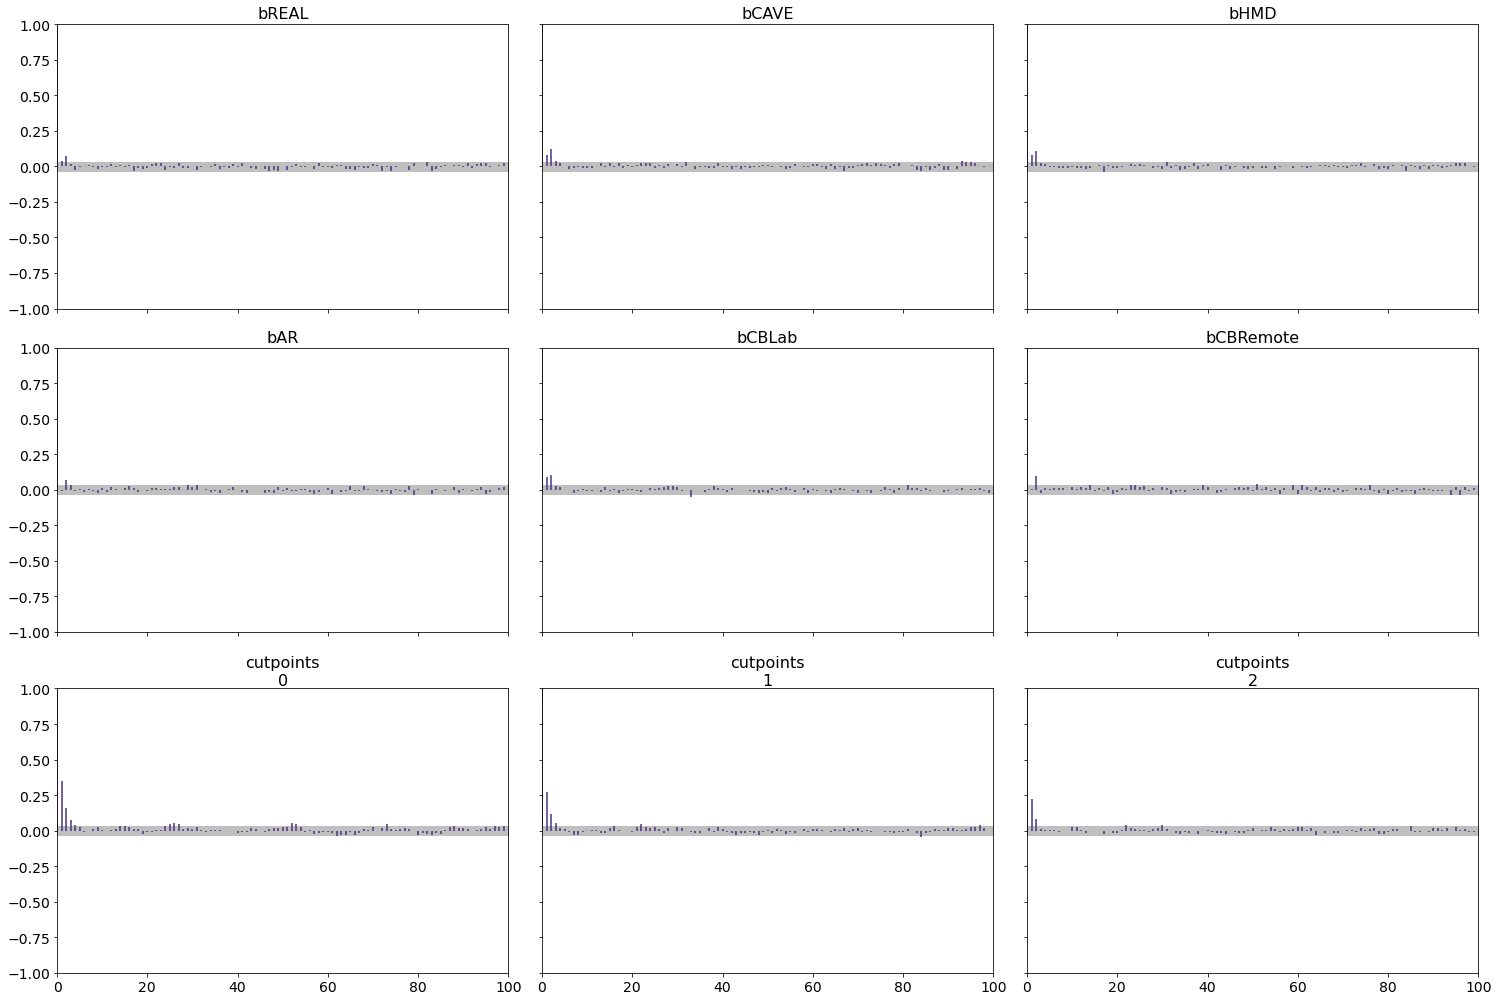

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


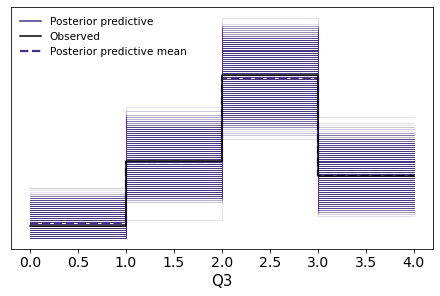

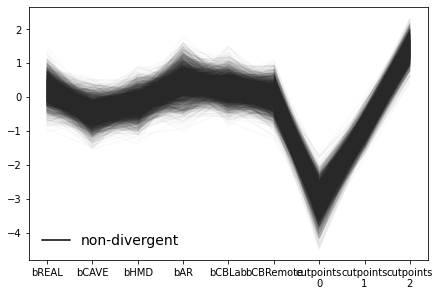

In [51]:
with Q3_model:
    ppc = pm.sample_posterior_predictive(trace_Q3, random_seed=RANDOM_SEED)

az.plot_trace(trace_Q3,var_names=["~eta"], filter_vars="regex",legend=True, compact=True);
az.plot_autocorr(trace_Q3,var_names=["~eta"], filter_vars="regex", combined = True);
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q3_model));
az.plot_parallel(trace_Q3,var_names=["~eta"], filter_vars="regex", legend = True);

In [52]:
printHDIs('Q3')

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -1.459    0.123  inconclusive
1        HMD - REAL  -1.119    0.386  inconclusive
2         AR - REAL  -0.709    1.159  inconclusive
3      CBLab - REAL  -0.690    0.806  inconclusive
4   CBRemote - REAL  -0.932    0.633  inconclusive
5  CBRemote - CBLab  -0.952    0.487  inconclusive
6              ROPE  -0.078    0.078  inconclusive

### How similar to real world traffic was your behavior in cases when you crossed the street?

In [53]:
Q4_model = bmb.Model("Q4 ~ 0+ Condition",df_subjectives, dropna=True,categorical="Condition")
Q4_fitted = Q4_model.fit(random_seed=RANDOM_SEED)
REAL, CAVE, HMD, AR, CBLab, CBRemote = [Q4_fitted.posterior['Condition'][:,:,x].values for x in [0,1,2,3,4,5]]
Q4_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

Automatically removing 7/163 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q4_sigma, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


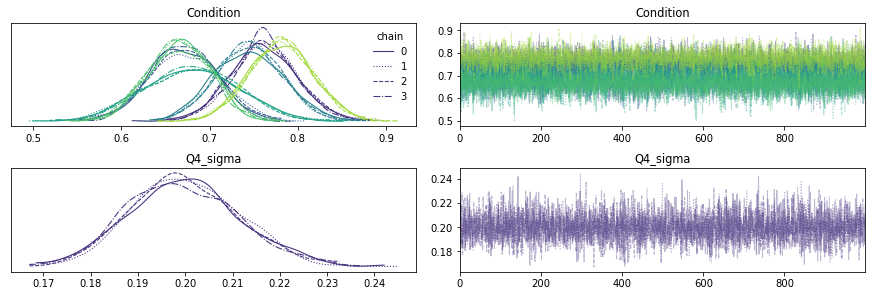

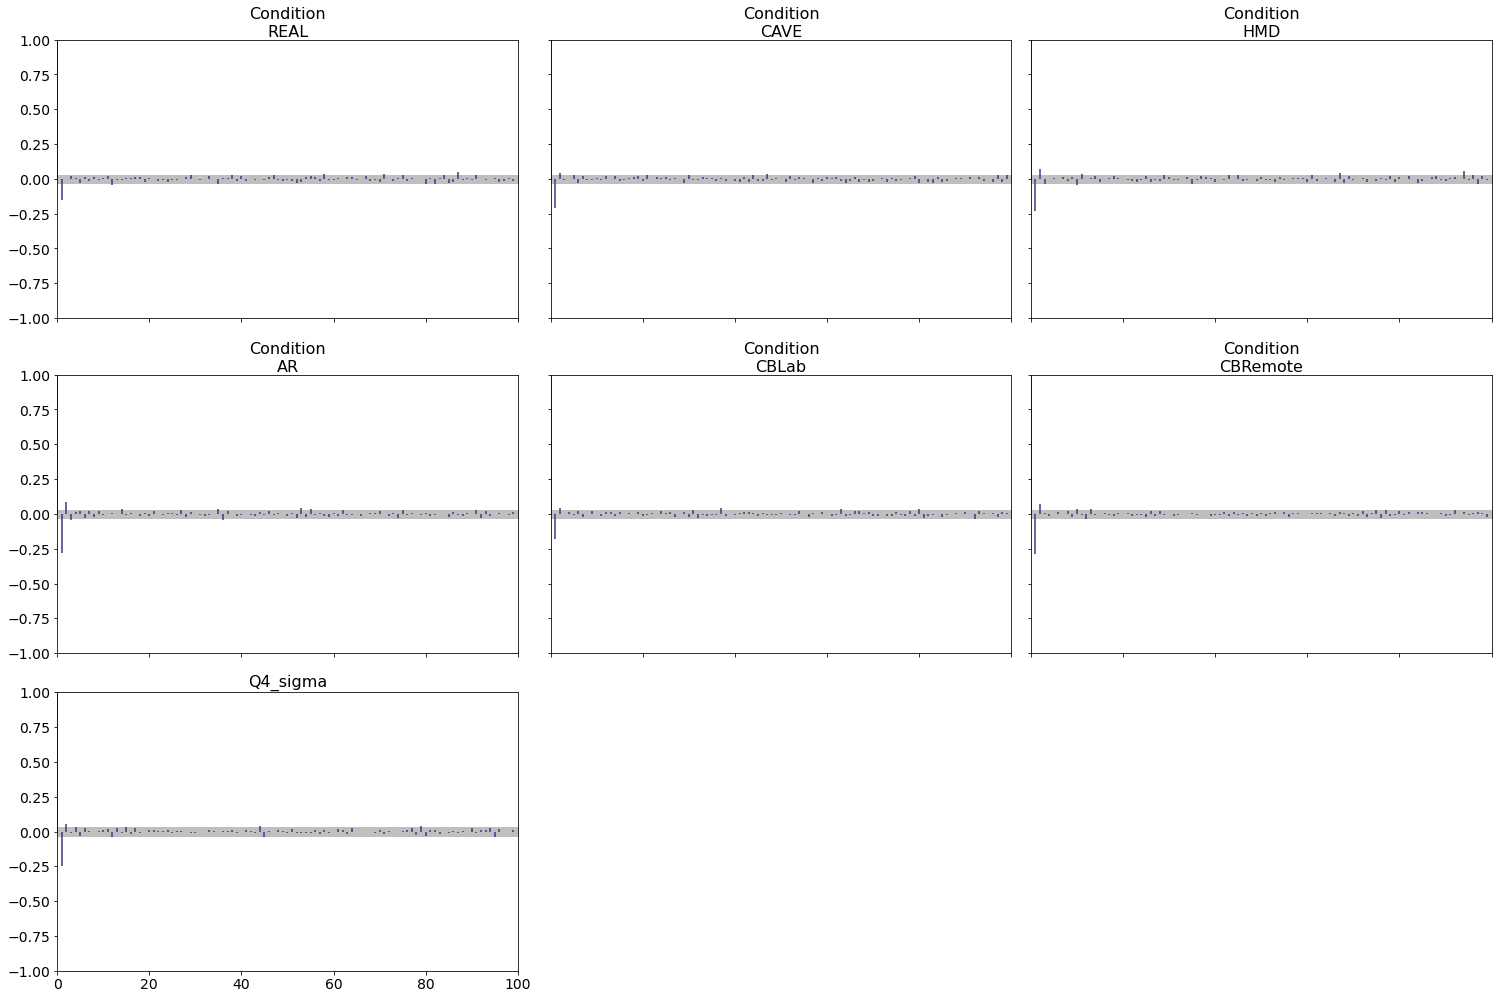

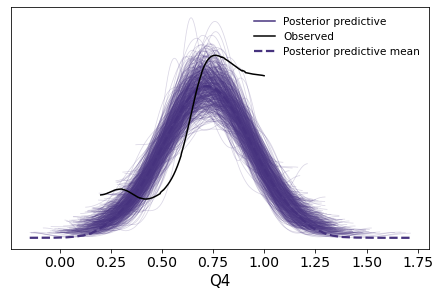

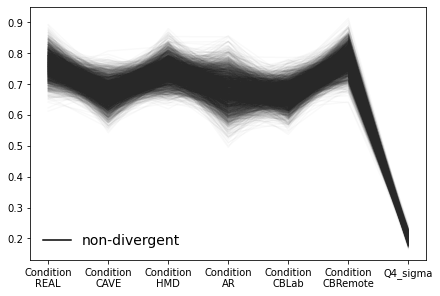

In [54]:
posterior_predictive = Q4_model.posterior_predictive(Q4_fitted,random_seed = RANDOM_SEED)

az.plot_trace(Q4_fitted,legend=True, compact=True);    
az.plot_autocorr(Q4_fitted, combined = True);
az.plot_ppc(Q4_fitted);
az.plot_parallel(Q4_fitted, legend = True);

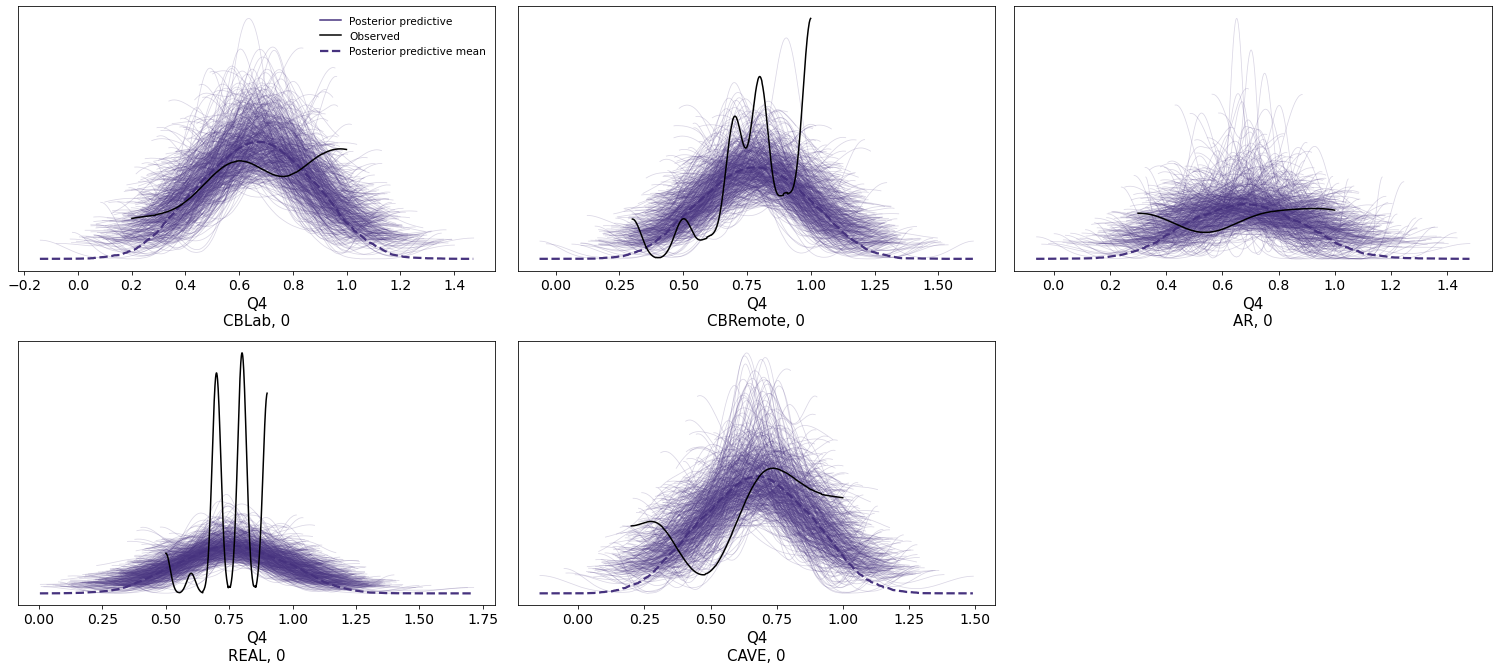

In [55]:
conditions = df_subjectives[["Q4","Condition"]].dropna().Condition.values
Q4_fitted = Q4_fitted.assign_coords(Q4_dim_0=conditions, groups="observed_vars")
az.plot_ppc(Q4_fitted, coords={'Q4_dim_0': ['REAL', 'CAVE', 'HDM', 'AR', 'CBLab', 'CBRemote']}, flatten=[]);

**Models with Gamma and Wald Function**
c.f. https://bambinos.github.io/bambi/master/notebooks/wald_gamma_glm.html

In [56]:
df_subjectives['Q4_i'] = abs(df_subjectives['Q4']-1) #inverse
df_subjectives['Q4_i'] += 1 #add one, otherwise model fails 

In [57]:
Q4_model_gaussian = bmb.Model(formula="Q4_i ~ 0+ Condition",
                     data=df_subjectives, dropna=True,
                     categorical="Condition")
Q4_fitted_gaussian = Q4_model_gaussian.fit(random_seed=RANDOM_SEED)

Automatically removing 7/163 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q4_i_sigma, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


In [58]:
Q4_model_wald = bmb.Model(formula="Q4_i ~ 0+ Condition",
                     data=df_subjectives, dropna=True,
                     family = "wald", link = "log",
                     categorical="Condition")
Q4_fitted_wald = Q4_model_wald.fit(random_seed=RANDOM_SEED)

Automatically removing 7/163 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q4_i_lam, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.


In [59]:
Q4_model_gamma = bmb.Model(formula="Q4_i ~ 0+ Condition",
                     data=df_subjectives, dropna=True,
                     family = "gamma", link = "log",
                     categorical="Condition")
Q4_fitted_gamma = Q4_model_gamma.fit(random_seed=RANDOM_SEED)

Automatically removing 7/163 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q4_i_alpha, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


In [60]:
models = {"wald": Q4_fitted_wald, "gamma": Q4_fitted_gamma, "gaussian": Q4_fitted_gaussian}
df_compare = az.compare(models)
df_compare

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank        loo     p_loo     d_loo        weight        se  \
wald         0  35.172445  6.858674  0.000000  1.000000e+00  8.932562   
gamma        1  32.662214  7.025922  2.510231  9.886536e-14  8.955556   
gaussian     2  26.471130  7.068289  8.701316  0.000000e+00  9.063985   

               dse  warning loo_scale  
wald      0.000000    False       log  
gamma     0.413282    False       log  
gaussian  1.345025    False       log

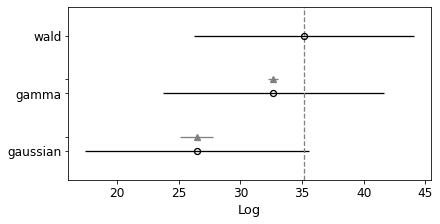

In [61]:
az.plot_compare(df_compare, insample_dev=False);

In [62]:
Q4_model = Q4_model_wald
Q4_fitted = Q4_fitted_wald
REAL, CAVE, HMD, AR, CBLab, CBRemote = [Q4_fitted.posterior['Condition'][:,:,x].values for x in [0,1,2,3,4,5]]
Q4_diffs = [(CAVE - REAL)*-1,(HMD - REAL)*-1,(AR - REAL)*-1,(CBLab - REAL)*-1,(CBRemote - REAL)*-1,(CBRemote - CBLab)*-1]
az.summary(Q4_fitted)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0]   0.215  0.027   0.164    0.263      0.000    0.000    5856.0   
Condition[1]   0.285  0.030   0.229    0.341      0.000    0.000    5817.0   
Condition[2]   0.228  0.029   0.173    0.280      0.000    0.000    5489.0   
Condition[3]   0.281  0.041   0.204    0.357      0.000    0.000    6931.0   
Condition[4]   0.290  0.028   0.238    0.343      0.000    0.000    7295.0   
Condition[5]   0.200  0.027   0.145    0.248      0.000    0.000    7095.0   
Q4_i_lam      56.387  6.418  44.536   68.551      0.089    0.064    5200.0   

              ess_tail  r_hat  
Condition[0]    3185.0    1.0  
Condition[1]    3453.0    1.0  
Condition[2]    3000.0    1.0  
Condition[3]    3384.0    1.0  
Condition[4]    3334.0    1.0  
Condition[5]    2858.0    1.0  
Q4_i_lam        3342.0    1.0

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


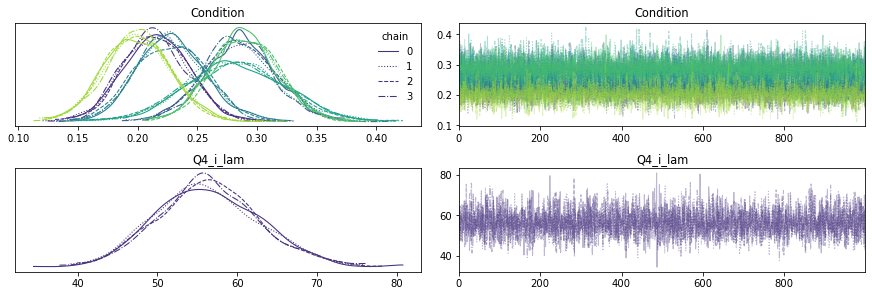

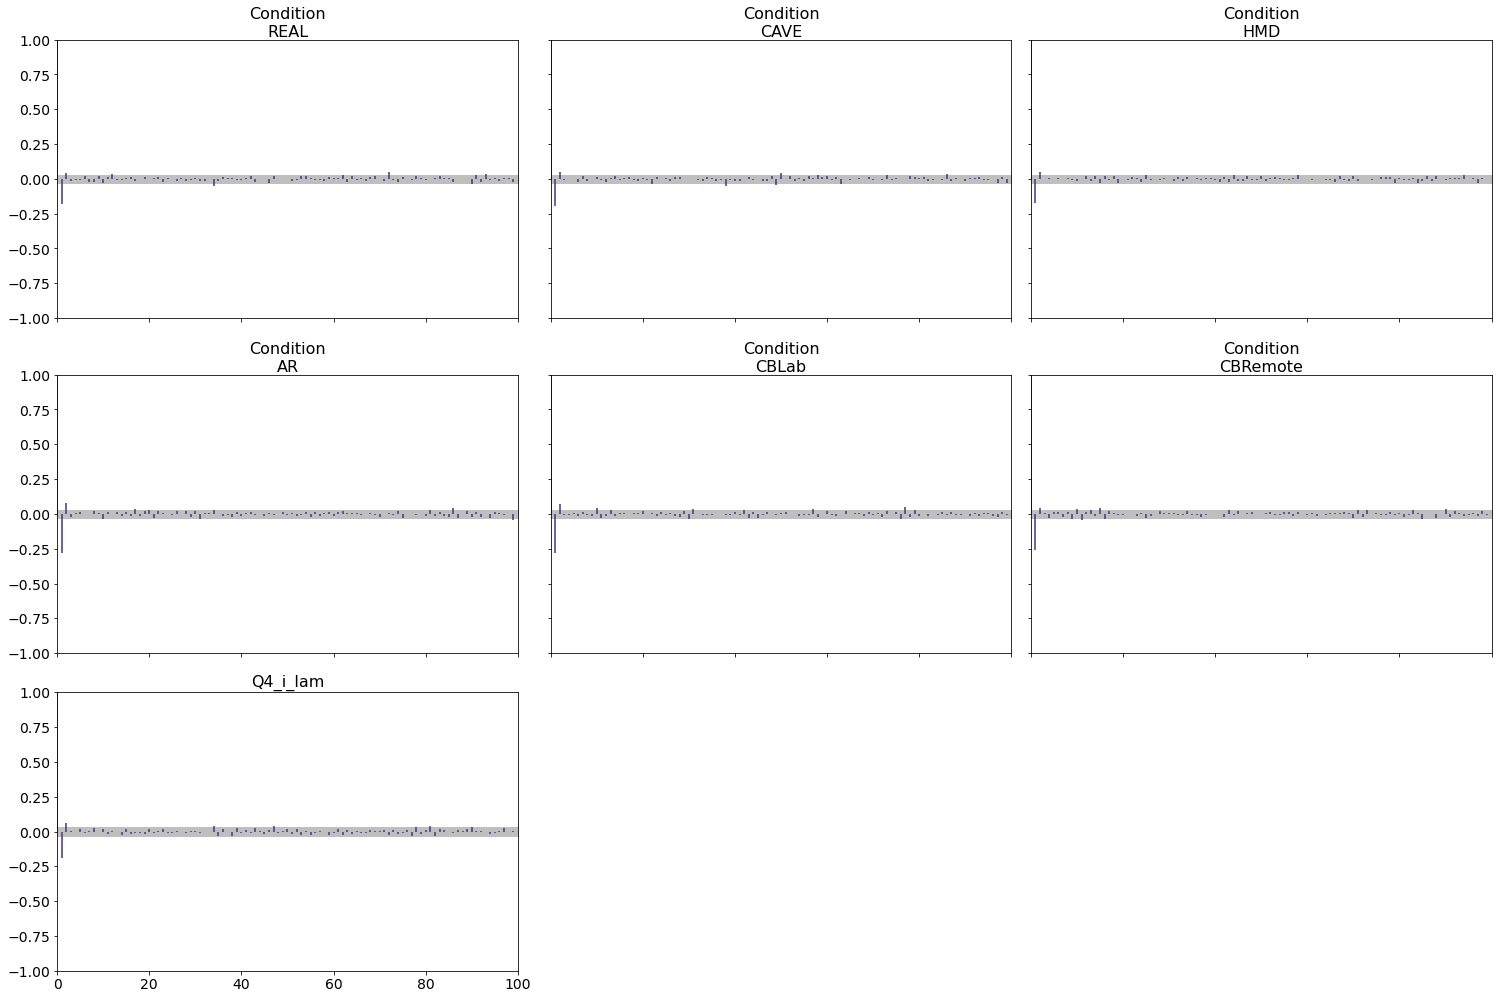

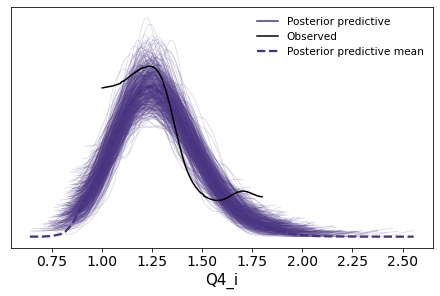

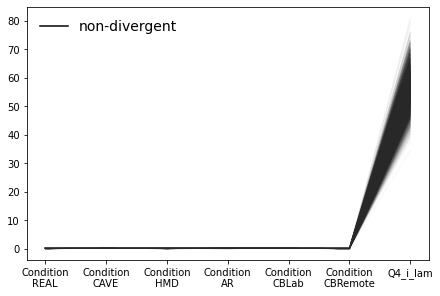

In [63]:
posterior_predictive = Q4_model.posterior_predictive(Q4_fitted,random_seed = RANDOM_SEED)

az.plot_trace(Q4_fitted,legend=True, compact=True);    
az.plot_autocorr(Q4_fitted, combined = True);
az.plot_ppc(Q4_fitted);
az.plot_parallel(Q4_fitted, legend = True);

In [64]:
HDIs = pd.DataFrame(np.array([np.concatenate((['CAVE - REAL'],az.hdi(az.convert_to_dataset(CAVE - REAL)).x.data)),
                           np.concatenate((['HMD - REAL'],az.hdi(az.convert_to_dataset(HMD - REAL)).x.data)),
                           np.concatenate((['AR - REAL'],az.hdi(az.convert_to_dataset(AR - REAL)).x.data)),
                           np.concatenate((['CBLab - REAL'],az.hdi(az.convert_to_dataset(CBLab - REAL)).x.data)),
                           np.concatenate((['CBRemote - REAL'],az.hdi(az.convert_to_dataset(CBRemote - REAL)).x.data)),
                           np.concatenate((['CBRemote - CBLab'],az.hdi(az.convert_to_dataset(CBRemote - CBLab)).x.data)),
                                 ['ROPE',df_subjectives['Q4'].std()*-0.1,df_subjectives['Q4'].std()*0.1]]),
                 columns=['Comparison', 'lowHDI', 'highHDI'])
HDIs = HDIs.astype({"lowHDI": 'float',"highHDI": 'float'})
HDIs["Result"] = ""
for index, row in HDIs.iterrows():
    result = 'inconclusive'
    if (row.lowHDI>df_subjectives['Q4'].std()*-0.1 and row.highHDI < df_subjectives['Q4'].std()*0.1):
        result = 'equal'
    if (row.lowHDI>df_subjectives['Q4'].std()*0.1):
        result = 'smaller'
    if (row.highHDI<df_subjectives['Q4'].std()*-0.1):
        result = 'larger'
    HDIs.iat[index, 3] = result
display(HDIs.round(3))

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -0.011    0.147  inconclusive
1        HMD - REAL  -0.058    0.092  inconclusive
2         AR - REAL  -0.023    0.159  inconclusive
3      CBLab - REAL   0.002    0.149  inconclusive
4   CBRemote - REAL  -0.092    0.053  inconclusive
5  CBRemote - CBLab  -0.168   -0.017  inconclusive
6              ROPE  -0.020    0.020  inconclusive

### How similar to real world traffic was your behavior in cases  you did not cross the street?

In [65]:
Q5_model = bmb.Model("Q5 ~ 0+ Condition",df_subjectives, dropna=True,categorical="Condition")
Q5_fitted = Q5_model.fit(random_seed=RANDOM_SEED)
REAL, CAVE, HMD, AR, CBLab, CBRemote = [Q5_fitted.posterior['Condition'][:,:,x].values for x in [0,1,2,3,4,5]]
Q5_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]
az.summary(Q5_fitted)

Automatically removing 9/163 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q5_sigma, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0]  0.767  0.039   0.689    0.836      0.001    0.000    6040.0   
Condition[1]  0.803  0.043   0.722    0.882      0.001    0.000    5923.0   
Condition[2]  0.800  0.043   0.719    0.878      0.001    0.000    5828.0   
Condition[3]  0.673  0.065   0.549    0.794      0.001    0.001    6001.0   
Condition[4]  0.715  0.040   0.638    0.783      0.000    0.000    6787.0   
Condition[5]  0.863  0.040   0.786    0.936      0.000    0.000    6822.0   
Q5_sigma      0.222  0.013   0.198    0.245      0.000    0.000    5792.0   

              ess_tail  r_hat  
Condition[0]    3269.0    1.0  
Condition[1]    3286.0    1.0  
Condition[2]    3155.0    1.0  
Condition[3]    3331.0    1.0  
Condition[4]    3384.0    1.0  
Condition[5]    3411.0    1.0  
Q5_sigma        3362.0    1.0

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


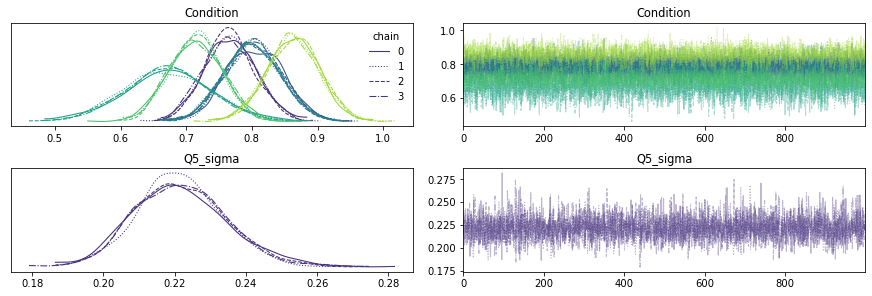

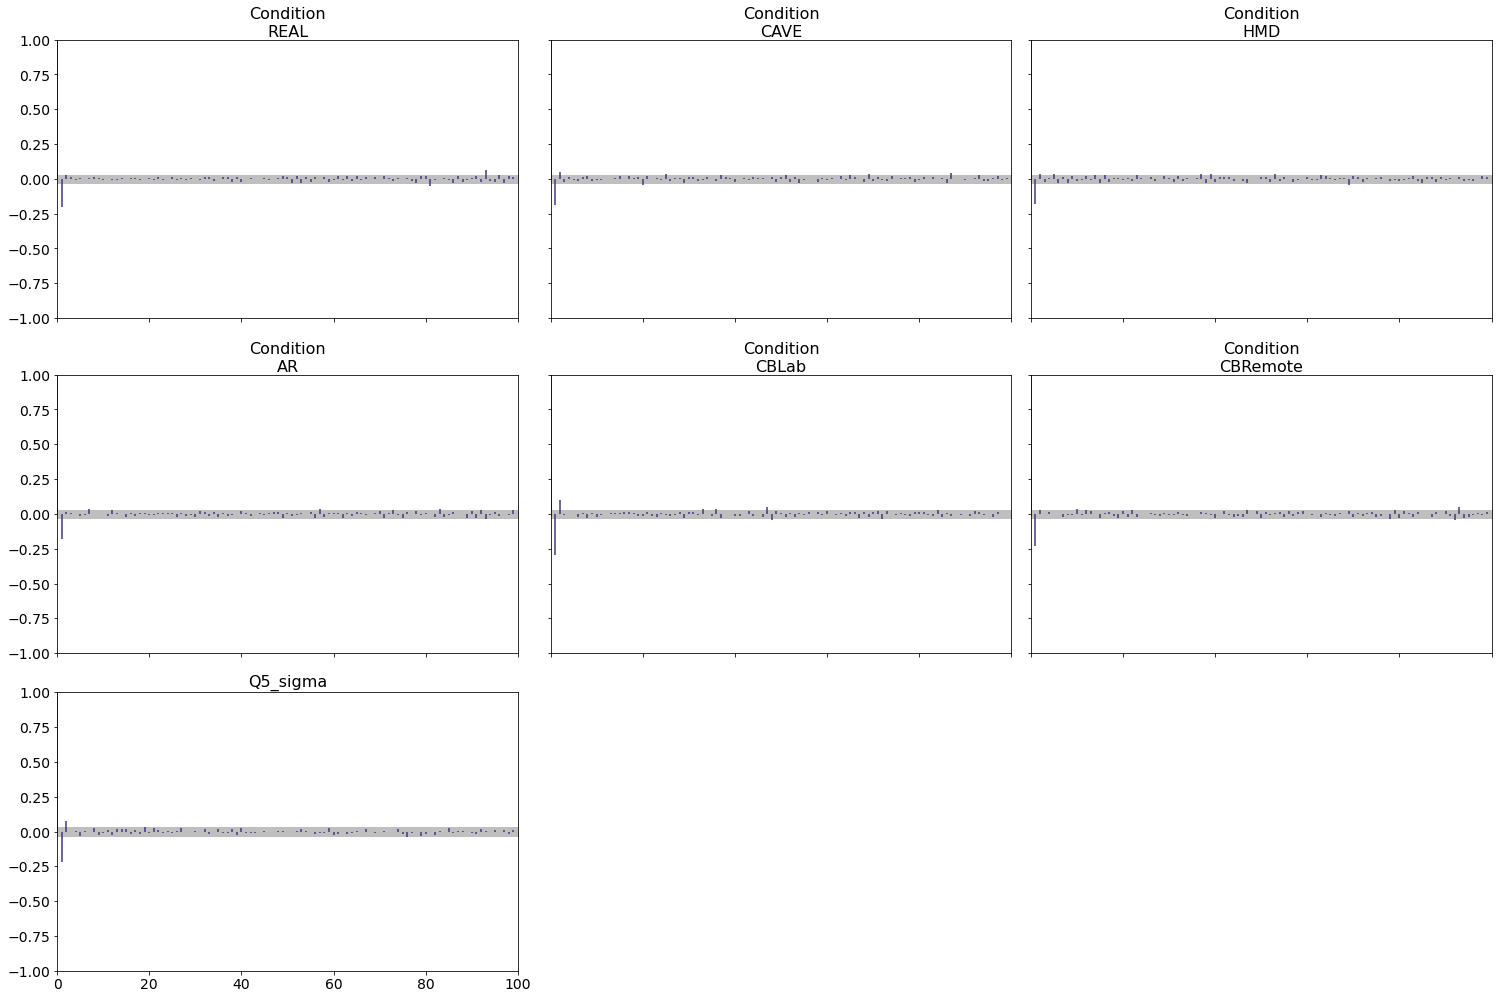

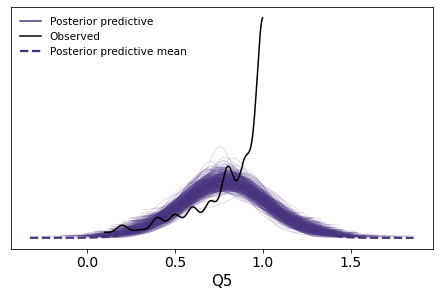

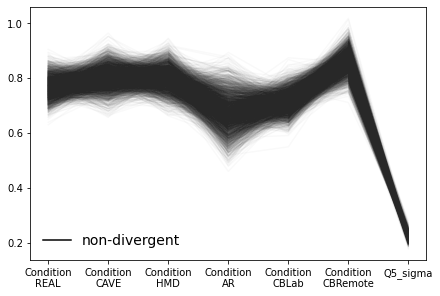

In [66]:
posterior_predictive = Q5_model.posterior_predictive(Q5_fitted,random_seed = RANDOM_SEED)

az.plot_trace(Q5_fitted,legend=True, compact=True);    
az.plot_autocorr(Q5_fitted, combined = True);
az.plot_ppc(Q5_fitted);
az.plot_parallel(Q5_fitted, legend = True);

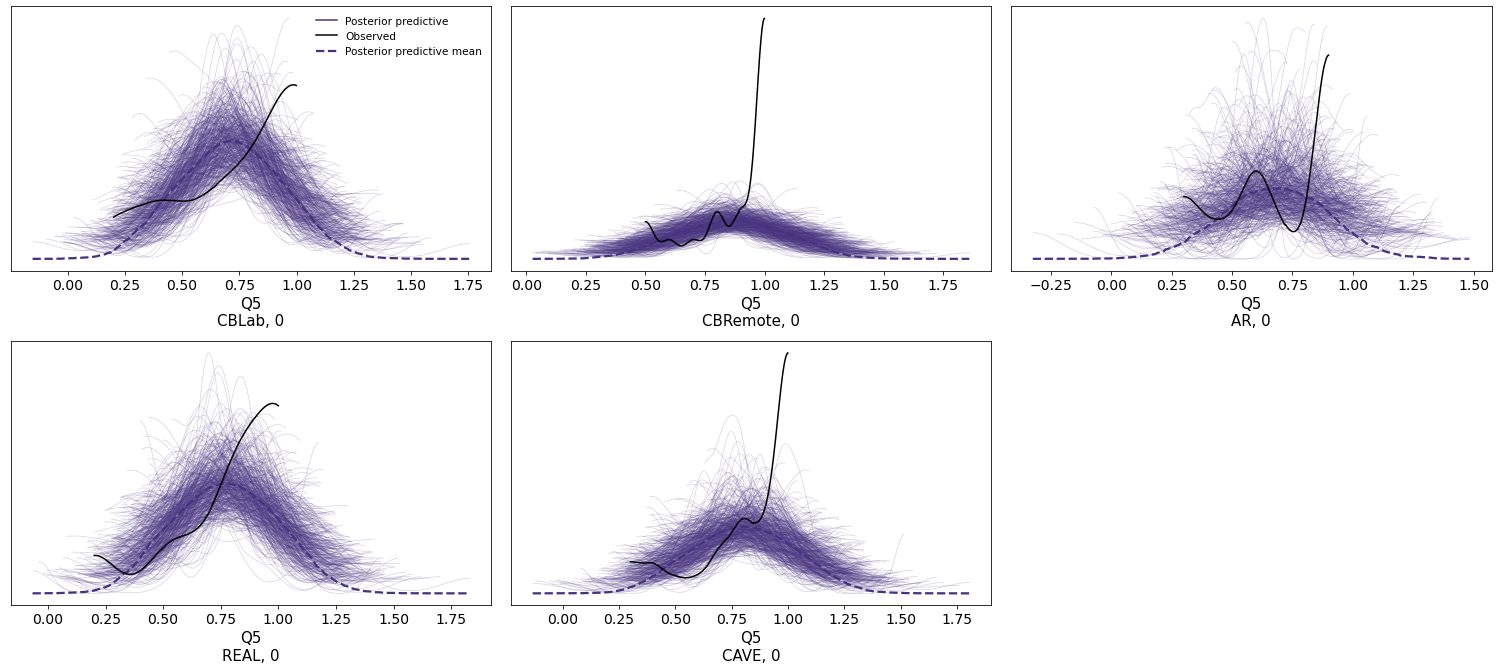

In [67]:
conditions = df_subjectives[["Q5","Condition"]].dropna().Condition.values
Q5_fitted = Q5_fitted.assign_coords(Q5_dim_0=conditions, groups="observed_vars")
az.plot_ppc(Q5_fitted, coords={'Q5_dim_0': ['REAL', 'CAVE', 'HDM', 'AR', 'CBLab', 'CBRemote']}, flatten=[]);

**Model fitting with Wald and Gamma distributions to account for skewed data**

https://bambinos.github.io/bambi/master/notebooks/wald_gamma_glm.html

In [68]:
df_subjectives['Q5_i'] = abs(df_subjectives['Q5']-1) #inverse
df_subjectives['Q5_i'] += 1

In [69]:
Q5_model_gaussian = bmb.Model(formula="Q5_i ~ 0+ Condition",
                     data=df_subjectives, dropna=True,
                     categorical="Condition")
Q5_fitted_gaussian = Q5_model_gaussian.fit(random_seed=RANDOM_SEED)

Automatically removing 9/163 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q5_i_sigma, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


In [70]:
Q5_model_wald = bmb.Model(formula="Q5_i ~ 0+ Condition",
                     data=df_subjectives, dropna=True,
                     family = "wald", link = "log",
                     categorical="Condition")
Q5_fitted_wald = Q5_model_wald.fit(random_seed=RANDOM_SEED)

Automatically removing 9/163 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q5_i_lam, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


In [71]:
Q5_model_gamma = bmb.Model(formula="Q5_i ~ 0+ Condition",
                     data=df_subjectives, dropna=True,
                     family = "gamma", link = "log",
                     categorical="Condition")
Q5_fitted_gamma = Q5_model_gamma.fit(random_seed=RANDOM_SEED)

Automatically removing 9/163 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q5_i_alpha, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


In [72]:
models = {"wald": Q5_fitted_wald, "gamma": Q5_fitted_gamma, "gaussian": Q5_fitted_gaussian}
df_compare = az.compare(models)
df_compare

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank        loo     p_loo      d_loo        weight        se  \
wald         0  23.057841  6.849919   0.000000  1.000000e+00  9.664909   
gamma        1  19.217216  6.916876   3.840625  0.000000e+00  9.687624   
gaussian     2   9.861390  6.954060  13.196451  8.231194e-13  9.845629   

              dse  warning loo_scale  
wald      0.00000    False       log  
gamma     0.63804    False       log  
gaussian  1.98655    False       log

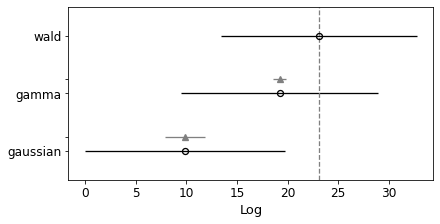

In [73]:
az.plot_compare(df_compare, insample_dev=False);

In [74]:
Q5_model = Q5_model_wald
Q5_fitted = Q5_fitted_wald
REAL, CAVE, HMD, AR, CBLab, CBRemote = [Q5_fitted.posterior['Condition'][:,:,x].values for x in [0,1,2,3,4,5]]
Q5_diffs = [(CAVE - REAL)*-1,(HMD - REAL)*-1,(AR - REAL)*-1,(CBLab - REAL)*-1,(CBRemote - REAL)*-1,(CBRemote - CBLab)*-1]
az.summary(Q5_fitted)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0]   0.211  0.031   0.153    0.267      0.000    0.000    6446.0   
Condition[1]   0.180  0.034   0.121    0.247      0.000    0.000    5107.0   
Condition[2]   0.184  0.033   0.125    0.247      0.000    0.000    5717.0   
Condition[3]   0.286  0.053   0.186    0.384      0.001    0.001    5570.0   
Condition[4]   0.251  0.031   0.194    0.314      0.000    0.000    6254.0   
Condition[5]   0.129  0.031   0.071    0.187      0.000    0.000    7304.0   
Q5_i_lam      41.508  4.788  32.737   50.825      0.064    0.046    5539.0   

              ess_tail  r_hat  
Condition[0]    3316.0    1.0  
Condition[1]    3401.0    1.0  
Condition[2]    3063.0    1.0  
Condition[3]    2930.0    1.0  
Condition[4]    3512.0    1.0  
Condition[5]    3405.0    1.0  
Q5_i_lam        3239.0    1.0

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


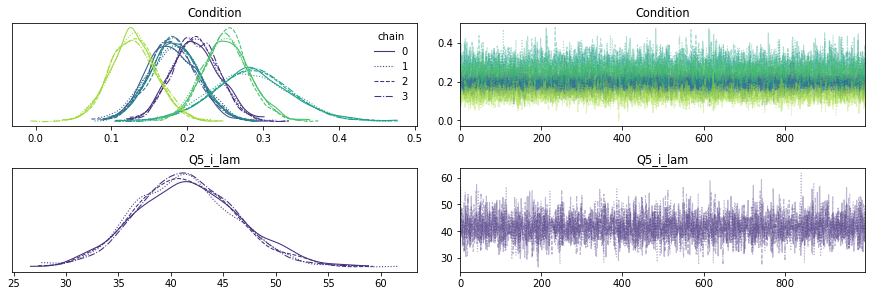

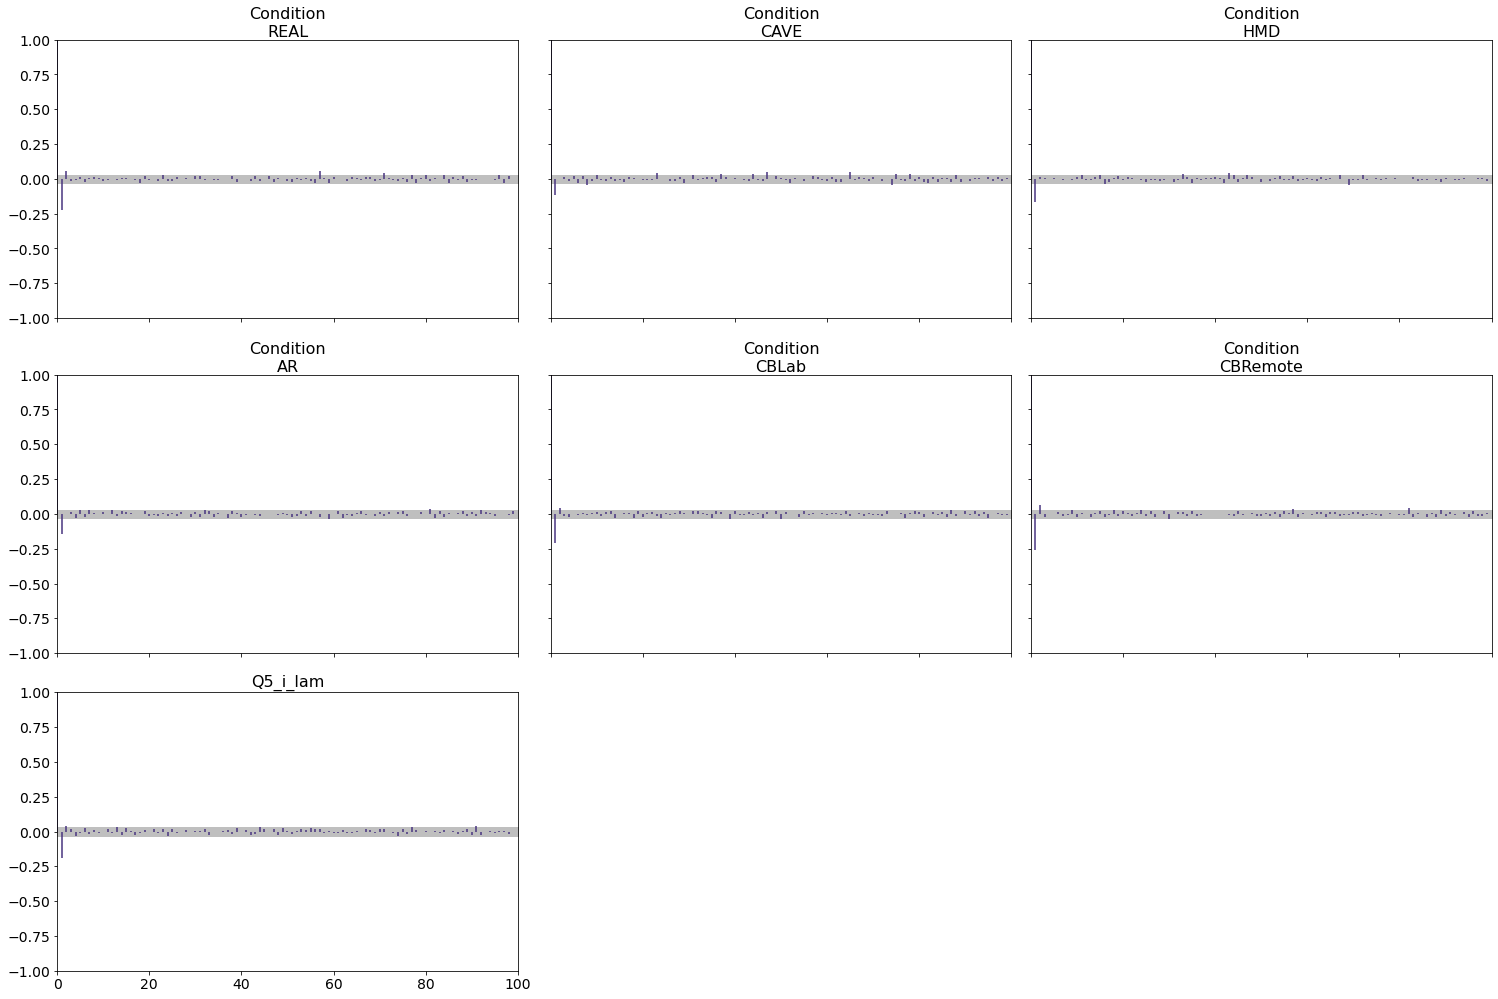

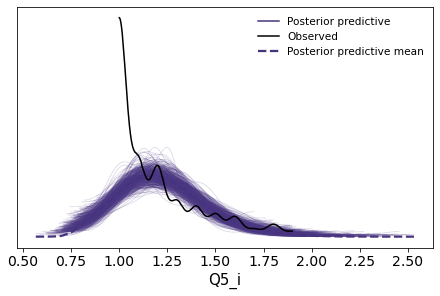

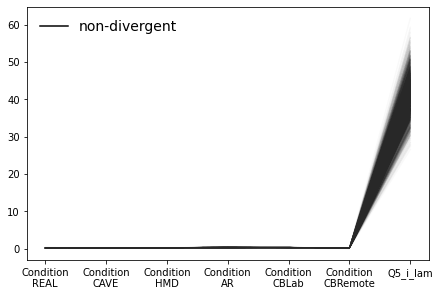

In [75]:
posterior_predictive = Q5_model.posterior_predictive(Q5_fitted,random_seed = RANDOM_SEED)

az.plot_trace(Q5_fitted,legend=True, compact=True);    
az.plot_autocorr(Q5_fitted, combined = True);
az.plot_ppc(Q5_fitted);
az.plot_parallel(Q5_fitted, legend = True);

In [76]:
HDIs = pd.DataFrame(np.array([np.concatenate((['CAVE - REAL'],az.hdi(az.convert_to_dataset(CAVE - REAL)).x.data)),
                           np.concatenate((['HMD - REAL'],az.hdi(az.convert_to_dataset(HMD - REAL)).x.data)),
                           np.concatenate((['AR - REAL'],az.hdi(az.convert_to_dataset(AR - REAL)).x.data)),
                           np.concatenate((['CBLab - REAL'],az.hdi(az.convert_to_dataset(CBLab - REAL)).x.data)),
                           np.concatenate((['CBRemote - REAL'],az.hdi(az.convert_to_dataset(CBRemote - REAL)).x.data)),
                           np.concatenate((['CBRemote - CBLab'],az.hdi(az.convert_to_dataset(CBRemote - CBLab)).x.data)),
                                 ['ROPE',df_subjectives['Q5'].std()*-0.1,df_subjectives['Q5'].std()*0.1]]),
                 columns=['Comparison', 'lowHDI', 'highHDI'])
HDIs = HDIs.astype({"lowHDI": 'float',"highHDI": 'float'})
HDIs["Result"] = ""
for index, row in HDIs.iterrows():
    result = 'inconclusive'
    if (row.lowHDI>df_subjectives['Q5'].std()*-0.1 and row.highHDI < df_subjectives['Q5'].std()*0.1):
        result = 'equal'
    if (row.lowHDI>df_subjectives['Q5'].std()*0.1):
        result = 'smaller'
    if (row.highHDI<df_subjectives['Q5'].std()*-0.1):
        result = 'larger'
    HDIs.iat[index, 3] = result
display(HDIs.round(3))

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -0.115    0.052  inconclusive
1        HMD - REAL  -0.108    0.060  inconclusive
2         AR - REAL  -0.043    0.187  inconclusive
3      CBLab - REAL  -0.043    0.124  inconclusive
4   CBRemote - REAL  -0.161    0.004  inconclusive
5  CBRemote - CBLab  -0.209   -0.041        larger
6              ROPE  -0.023    0.023  inconclusive

### Compared to usual, my choices were safe / unsafe

In [77]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q6"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

 0.0    0.05
 2.0    0.12
-2.0    0.17
 1.0    1.48
-1.0     inf
Name: Q6, dtype: float64

In [78]:
#delete empty rows
nanIDX = np.argwhere(np.isnan(df_subjectives["Q6"].values))[0][0]
obs = np.delete(df_subjectives["Q6"].values, nanIDX)
dummies_ = dummies.drop([nanIDX])

In [79]:
with pm.Model() as Q6_model:
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=4,
        testval=np.arange(4),
    )
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies_.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies_.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies_.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies_.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies_.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies_.CBRemote.values)
    
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)

    Q6 = pm.OrderedLogistic("Q6", eta, cutpoints, observed = obs + 2)
    
    trace_Q6 = pm.sample(return_inferencedata=True, tune = 1000, random_seed=RANDOM_SEED, target_accept=0.9)


REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q6.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]
Q6_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

az.summary(trace_Q6, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL        -0.40  0.33   -1.02     0.21       0.01     0.00   3914.71   
bCAVE        -0.07  0.33   -0.68     0.56       0.01     0.01   3632.96   
bHMD          0.50  0.33   -0.15     1.13       0.01     0.00   4082.37   
bAR           0.10  0.38   -0.62     0.77       0.01     0.01   4402.50   
bCBLab        0.07  0.33   -0.55     0.66       0.01     0.00   3536.65   
bCBRemote    -0.12  0.32   -0.78     0.44       0.01     0.00   3299.01   
cutpoints[0] -3.94  0.54   -4.96    -2.95       0.01     0.01   2704.54   
cutpoints[1] -1.40  0.28   -1.94    -0.88       0.01     0.00   2588.89   
cutpoints[2]  0.89  0.26    0.42     1.39       0.00     0.00   2860.39   
cutpoints[3]  3.71  0.50    2.82     4.68       0.01     0.01   3897.93   

              ess_tail  r_hat  
bREAL          2963.28    1.0  
bCAVE          2537.88    1.0  
bHMD           2887.94    1.0  
bAR            3117.75    1.0  
bCBLab         3192.80    1.0  
bCBRemote      3018.06    1.0  
cutpoints[0]   2609.64    1.0  
cutpoints[1]   2935.55    1.0  
cutpoints[2]   3277.89    1.0  
cutpoints[3]   2853.69    1.0

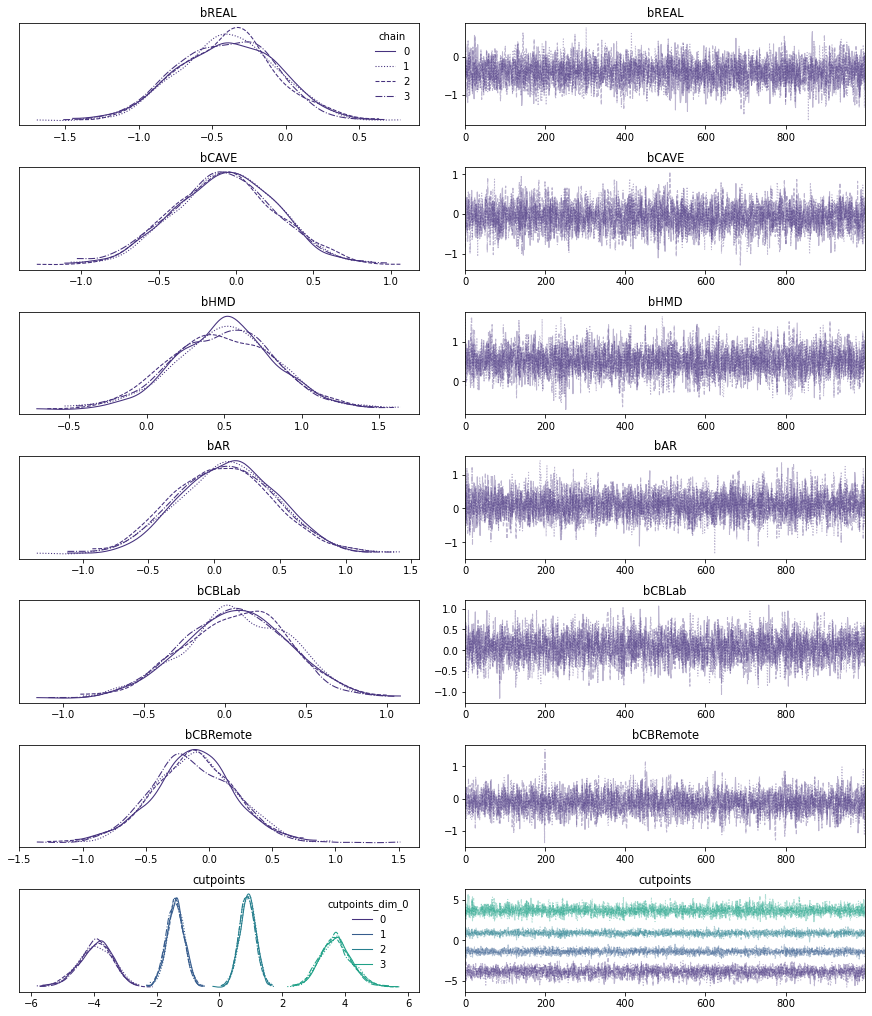

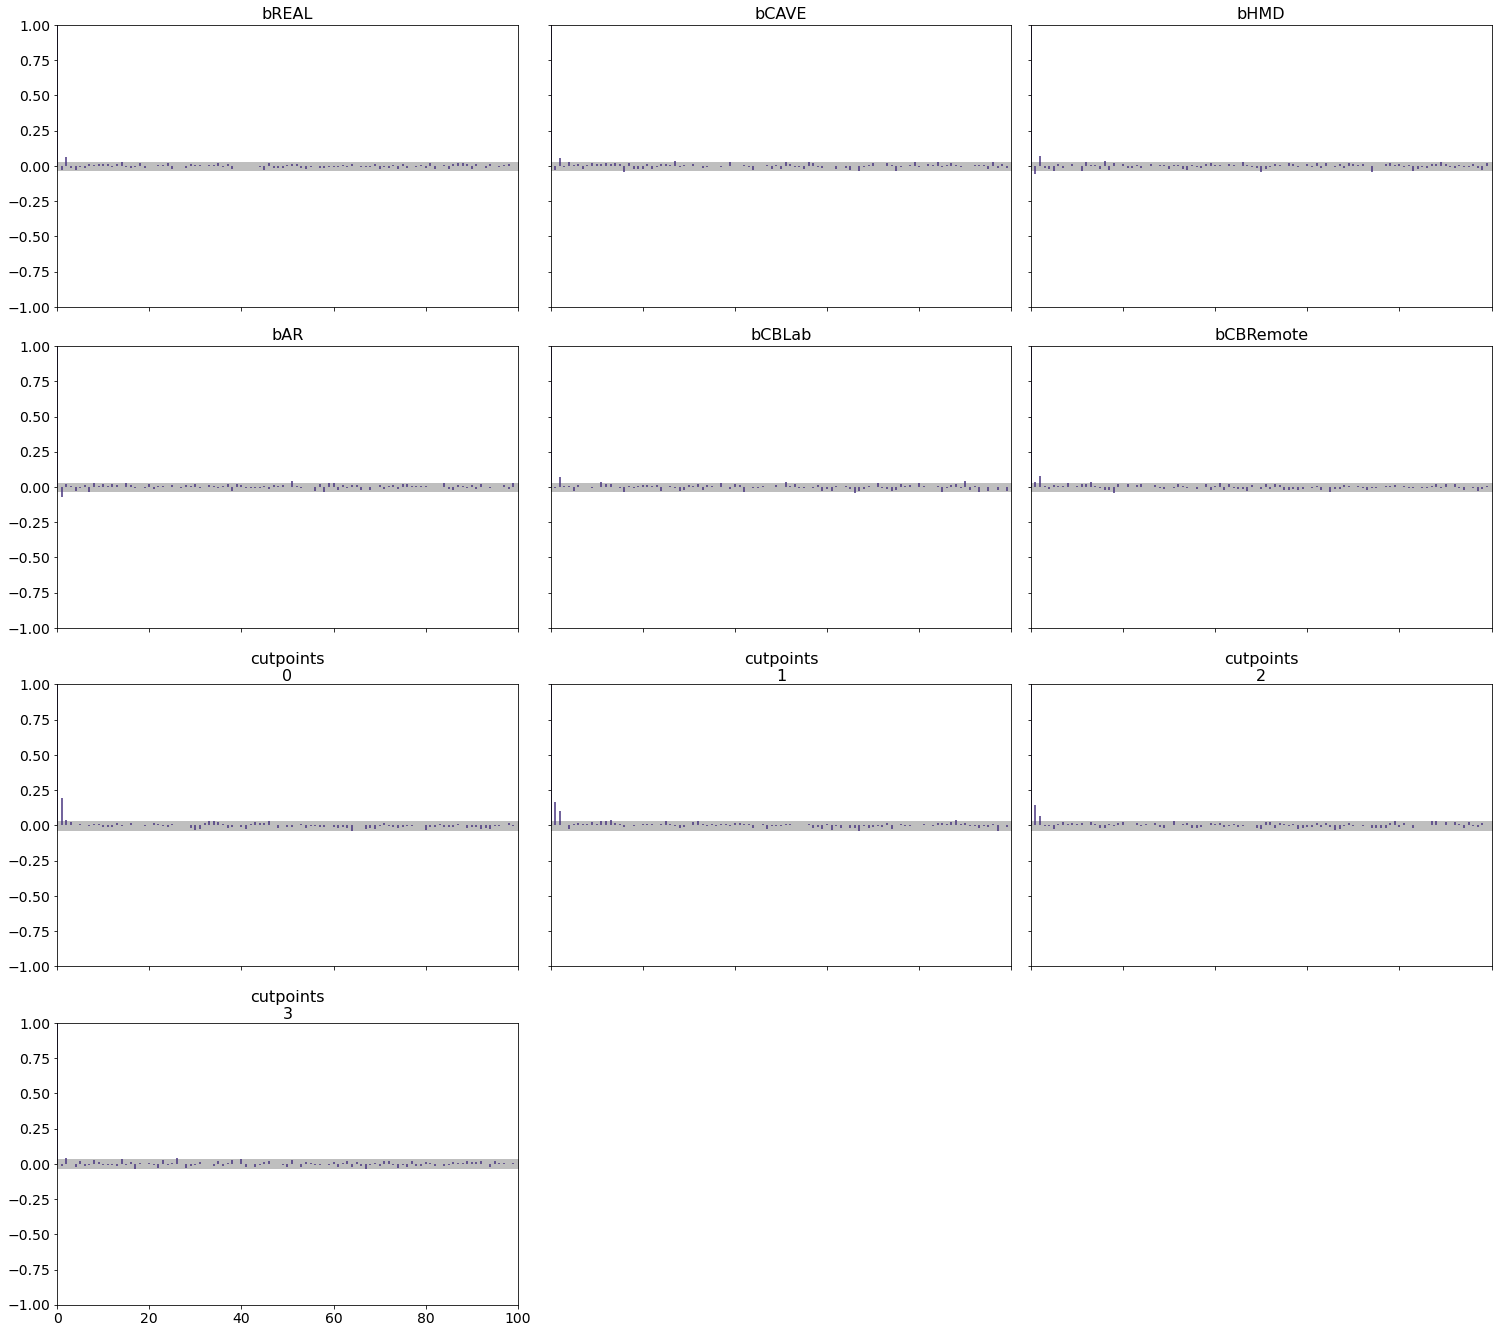

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


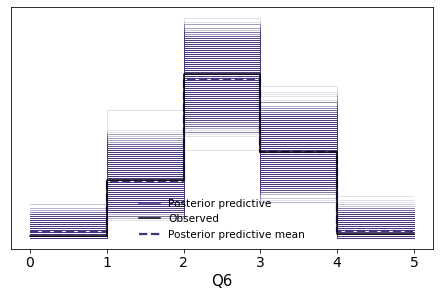

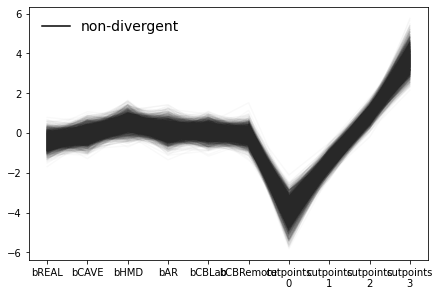

In [80]:
with Q6_model:
    ppc = pm.sample_posterior_predictive(trace_Q6, random_seed=RANDOM_SEED)

az.plot_trace(trace_Q6,var_names=["~eta"], filter_vars="regex",legend=True, compact=True);
az.plot_autocorr(trace_Q6,var_names=["~eta"], filter_vars="regex", combined = True);
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q6_model));
az.plot_parallel(trace_Q6,var_names=["~eta"], filter_vars="regex", legend = True);

In [81]:
printHDIs('Q6')

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -0.391    1.136  inconclusive
1        HMD - REAL   0.066    1.631  inconclusive
2         AR - REAL  -0.315    1.398  inconclusive
3      CBLab - REAL  -0.266    1.237  inconclusive
4   CBRemote - REAL  -0.450    1.014  inconclusive
5  CBRemote - CBLab  -0.962    0.538  inconclusive
6              ROPE  -0.076    0.076  inconclusive

### Compared to usual, deciding to cross the street was easy / difficult

In [82]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q7"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

 0.0   -1.02
 2.0   -0.45
-2.0   -0.37
 1.0    2.14
-1.0     inf
Name: Q7, dtype: float64

In [83]:
#delete empty rows
nanIDX = np.argwhere(np.isnan(df_subjectives["Q7"].values))[0][0]
obs = np.delete(df_subjectives["Q7"].values, nanIDX)
dummies_ = dummies.drop([nanIDX])

In [84]:
with pm.Model() as Q7_model:
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=4,
        testval=np.arange(4),
    )
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies_.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies_.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies_.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies_.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies_.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies_.CBRemote.values)
    
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)

    Q7 = pm.OrderedLogistic("Q7", eta, cutpoints, observed = obs + 2)
    
    trace_Q7 = pm.sample(return_inferencedata=True, tune = 1000, random_seed=RANDOM_SEED, target_accept=0.9)


REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q7.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]
Q7_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

az.summary(trace_Q7, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL        -0.28  0.32   -0.88     0.33       0.01     0.00   4045.45   
bCAVE        -0.47  0.32   -1.03     0.15       0.01     0.00   3982.51   
bHMD          0.08  0.33   -0.54     0.70       0.01     0.00   3645.00   
bAR           0.38  0.38   -0.34     1.10       0.01     0.00   5079.79   
bCBLab        0.42  0.32   -0.19     1.00       0.00     0.00   4242.94   
bCBRemote     0.31  0.33   -0.31     0.93       0.00     0.00   4679.82   
cutpoints[0] -3.69  0.50   -4.63    -2.77       0.01     0.01   2443.64   
cutpoints[1] -1.89  0.29   -2.42    -1.34       0.01     0.00   3161.40   
cutpoints[2] -0.39  0.25   -0.88     0.05       0.00     0.00   2908.67   
cutpoints[3]  2.06  0.30    1.48     2.62       0.00     0.00   4068.95   

              ess_tail  r_hat  
bREAL          3131.73    1.0  
bCAVE          3048.85    1.0  
bHMD           2867.64    1.0  
bAR            2664.28    1.0  
bCBLab         3264.97    1.0  
bCBRemote      3331.75    1.0  
cutpoints[0]   1966.06    1.0  
cutpoints[1]   3111.16    1.0  
cutpoints[2]   2918.47    1.0  
cutpoints[3]   2957.57    1.0

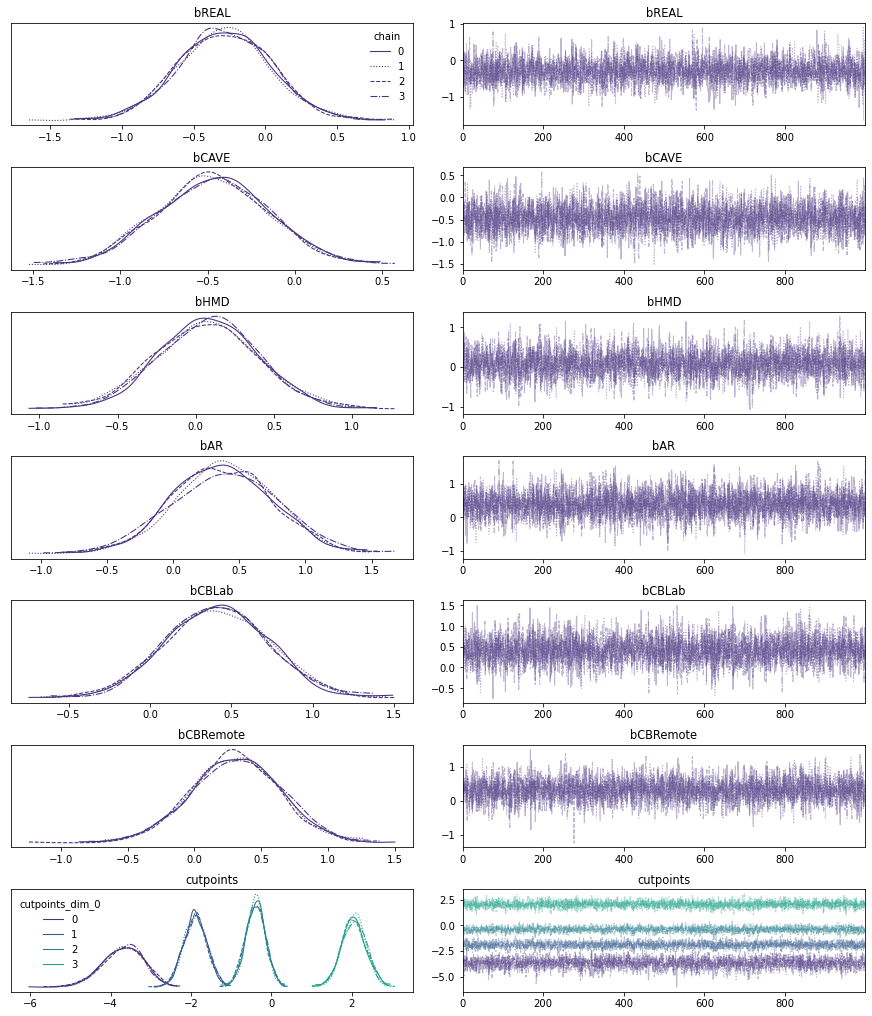

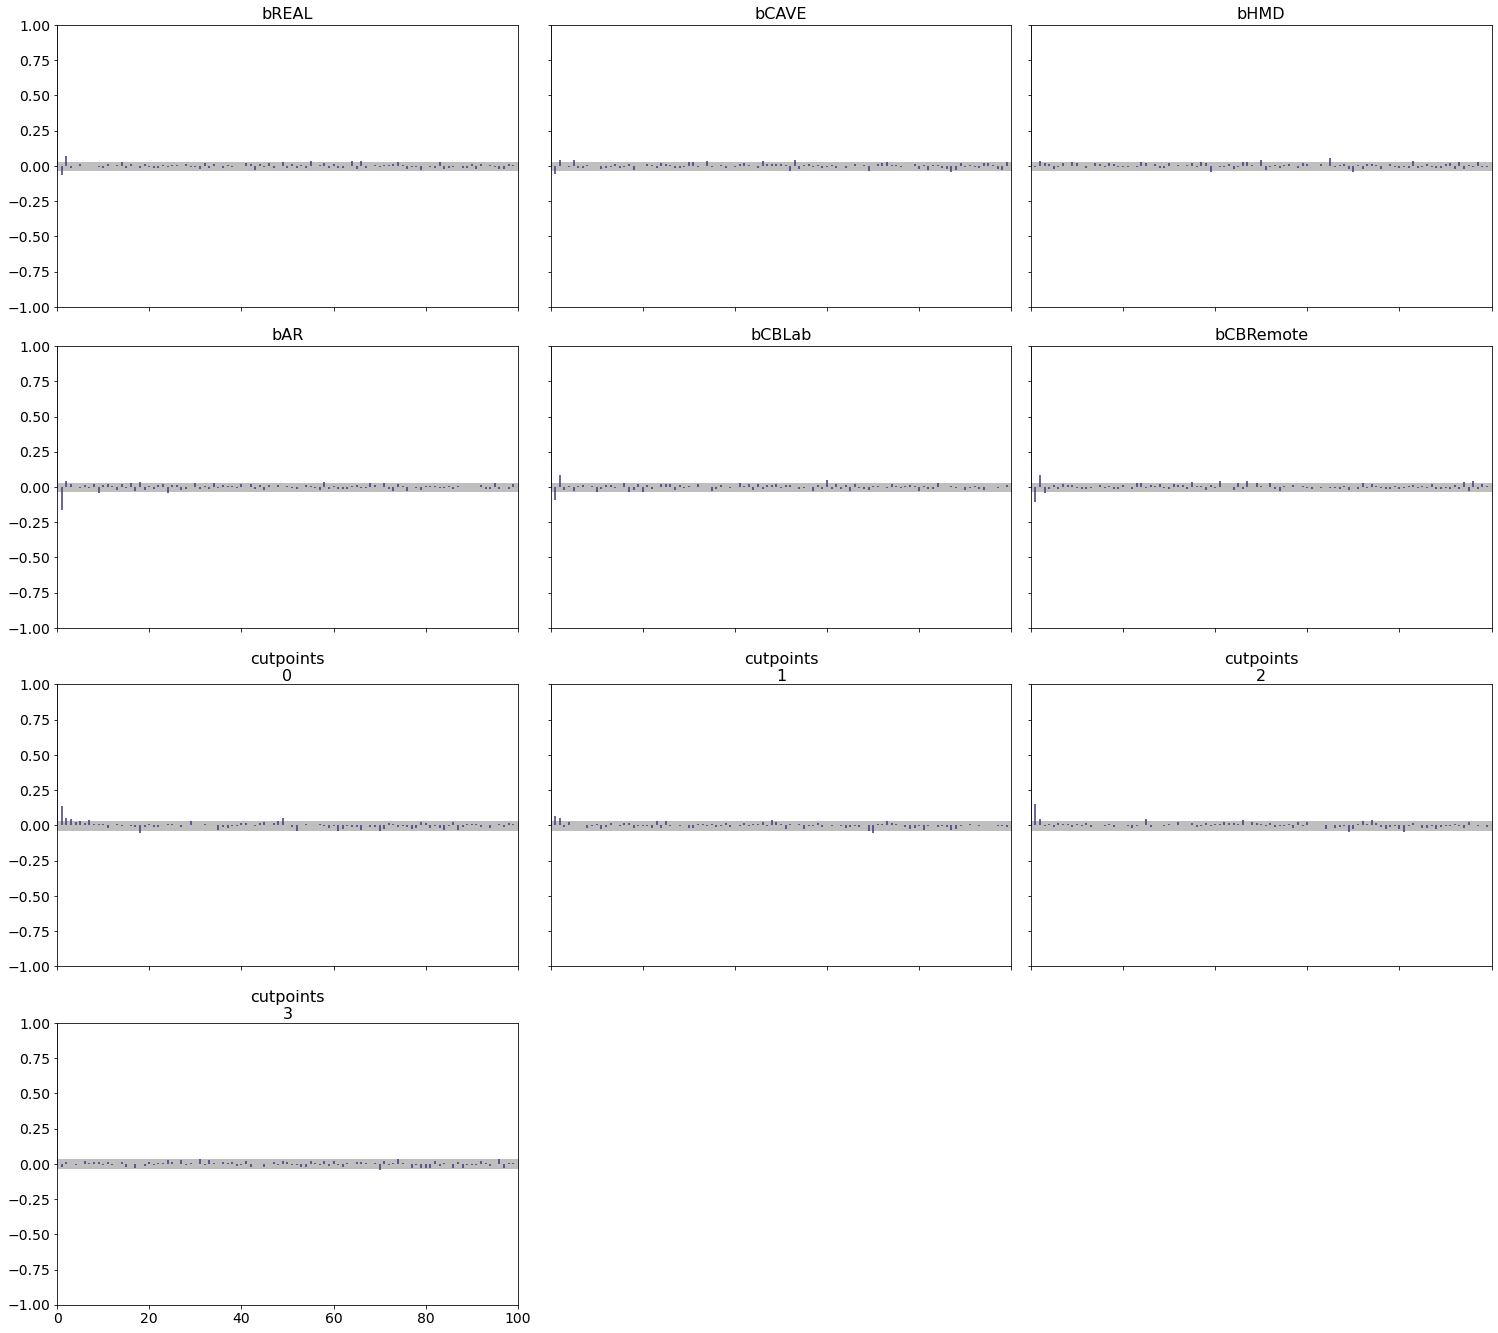

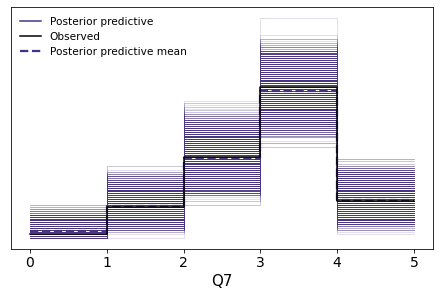

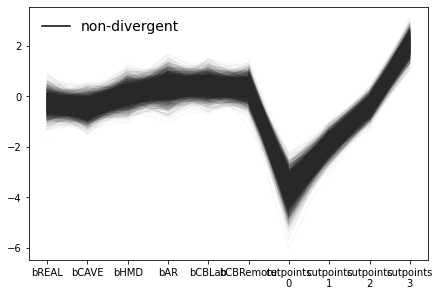

In [85]:
with Q7_model:
    ppc = pm.sample_posterior_predictive(trace_Q7, random_seed=RANDOM_SEED)

az.plot_trace(trace_Q7,var_names=["~eta"], filter_vars="regex",legend=True, compact=True);
az.plot_autocorr(trace_Q7,var_names=["~eta"], filter_vars="regex", combined = True);
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q7_model));
az.plot_parallel(trace_Q7,var_names=["~eta"], filter_vars="regex", legend = True);

In [86]:
printHDIs('Q7')

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -0.932    0.551  inconclusive
1        HMD - REAL  -0.348    1.106  inconclusive
2         AR - REAL  -0.205    1.584  inconclusive
3      CBLab - REAL  -0.050    1.433  inconclusive
4   CBRemote - REAL  -0.163    1.352  inconclusive
5  CBRemote - CBLab  -0.877    0.612  inconclusive
6              ROPE  -0.090    0.090  inconclusive

### Compared to usual, making a decision took longer / shorter

In [87]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q8"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

 0.0   -0.58
 2.0   -0.50
-2.0   -0.30
 1.0    0.02
-1.0     inf
Name: Q8, dtype: float64

In [88]:
#delete empty rows
nanIDX = np.argwhere(np.isnan(df_subjectives["Q8"].values))[0][0]
obs = np.delete(df_subjectives["Q8"].values, nanIDX)
dummies_ = dummies.drop([nanIDX])

In [89]:
with pm.Model() as Q8_model:
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=4,
        testval=np.arange(4),
    )
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies_.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies_.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies_.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies_.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies_.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies_.CBRemote.values)
    
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)

    Q8 = pm.OrderedLogistic("Q8", eta, cutpoints, observed = obs + 2)
    
    trace_Q8 = pm.sample(return_inferencedata=True, tune = 1000, random_seed=RANDOM_SEED)


REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q8.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]
Q8_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

az.summary(trace_Q8, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL         0.06  0.33   -0.52     0.72       0.01     0.00   3477.83   
bCAVE         0.28  0.32   -0.34     0.89       0.01     0.00   2958.43   
bHMD         -0.63  0.33   -1.25    -0.04       0.01     0.00   2982.38   
bAR          -0.21  0.38   -0.95     0.47       0.01     0.01   5097.12   
bCBLab        0.35  0.33   -0.30     0.93       0.01     0.00   3695.42   
bCBRemote    -0.16  0.34   -0.78     0.47       0.01     0.00   3302.06   
cutpoints[0] -2.99  0.38   -3.71    -2.30       0.01     0.01   2065.34   
cutpoints[1]  0.11  0.25   -0.35     0.59       0.01     0.00   2195.41   
cutpoints[2]  2.11  0.31    1.53     2.69       0.01     0.00   3004.50   
cutpoints[3]  3.66  0.50    2.77     4.65       0.01     0.01   4556.23   

              ess_tail  r_hat  
bREAL          3109.37    1.0  
bCAVE          2790.96    1.0  
bHMD           2835.47    1.0  
bAR            3341.19    1.0  
bCBLab         3234.89    1.0  
bCBRemote      3162.64    1.0  
cutpoints[0]   2186.38    1.0  
cutpoints[1]   3212.17    1.0  
cutpoints[2]   3241.44    1.0  
cutpoints[3]   3262.31    1.0

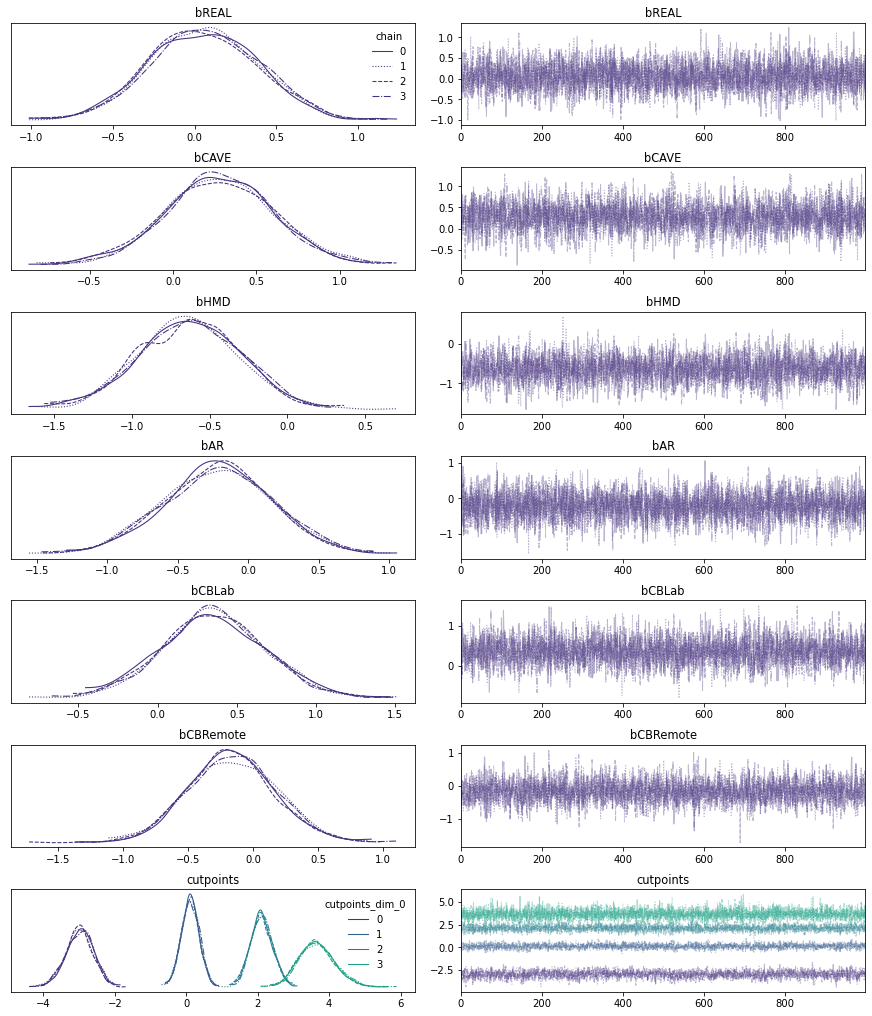

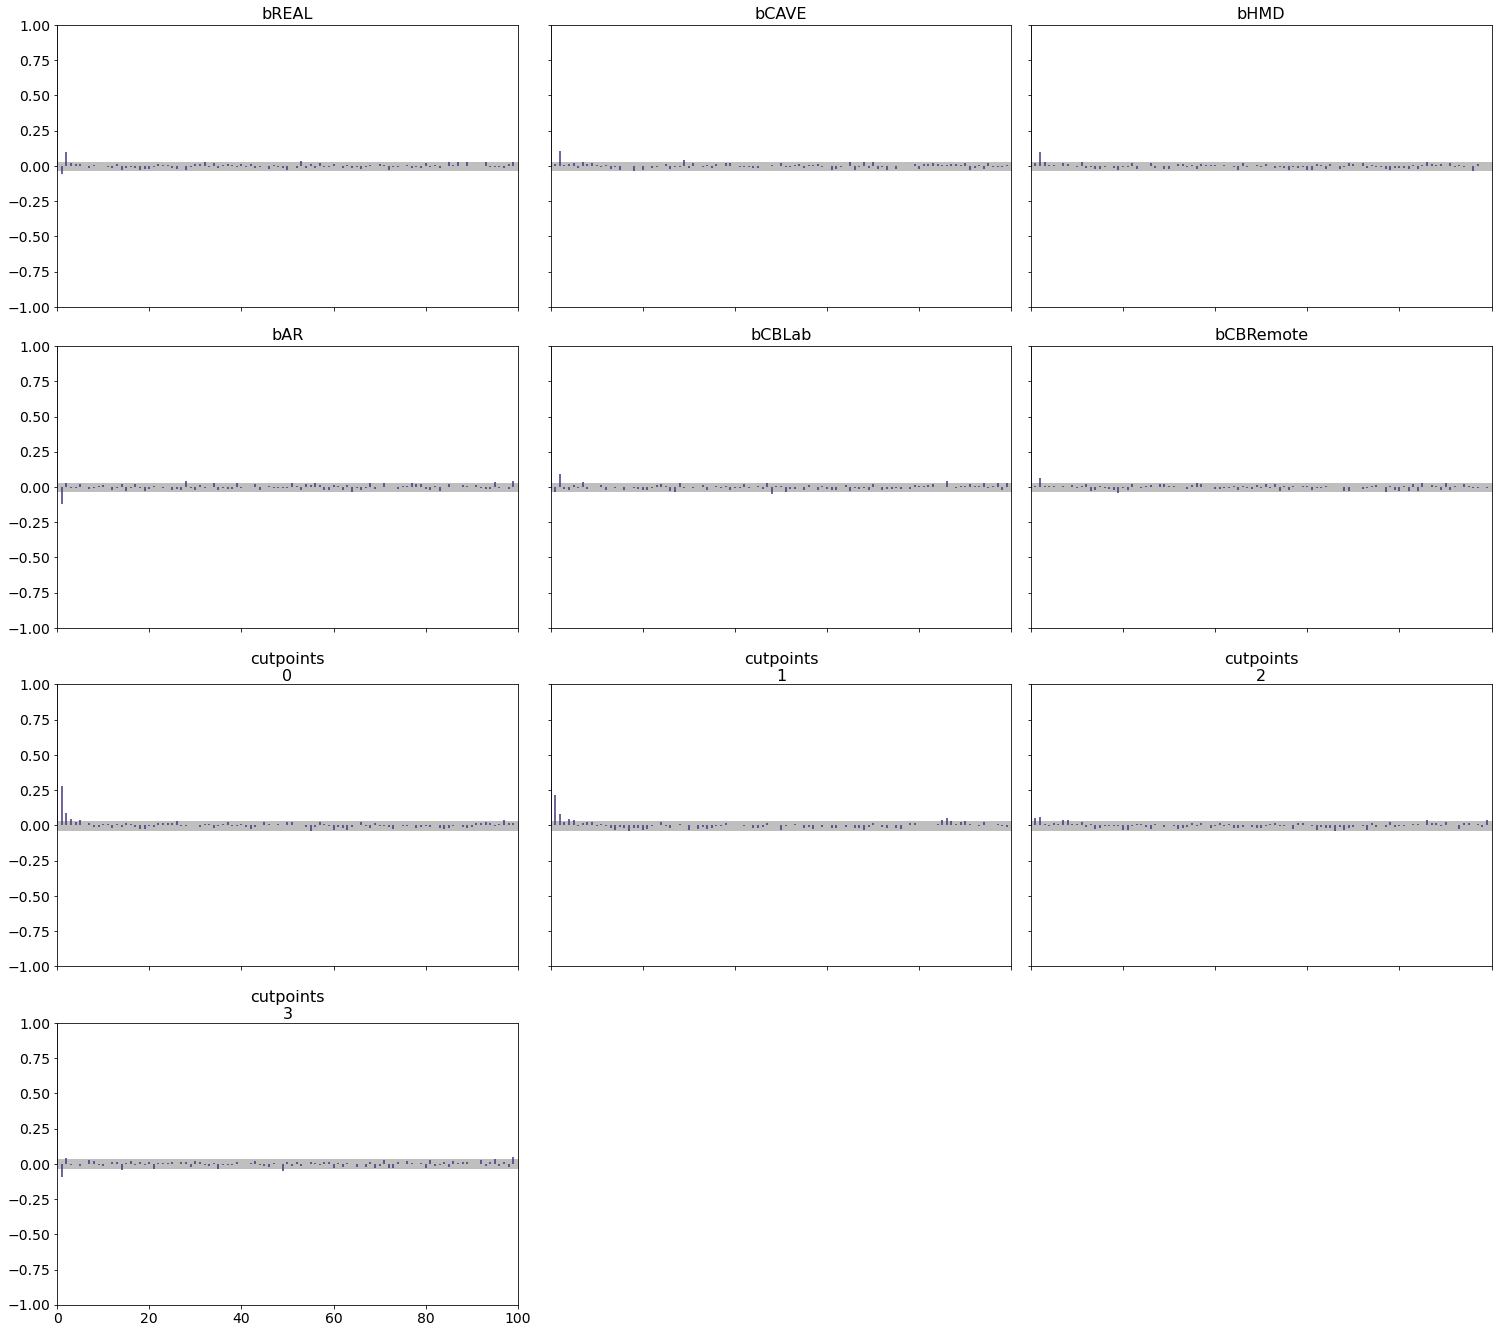

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


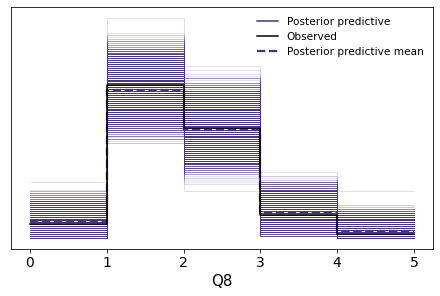

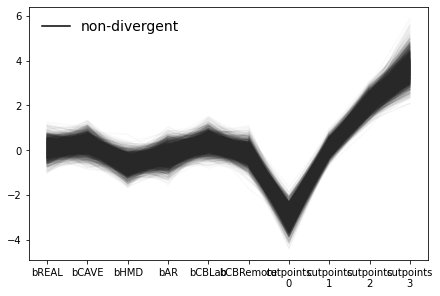

In [90]:
with Q8_model:
    ppc = pm.sample_posterior_predictive(trace_Q8, random_seed=RANDOM_SEED)

az.plot_trace(trace_Q8,var_names=["~eta"], filter_vars="regex",legend=True, compact=True);
az.plot_autocorr(trace_Q8,var_names=["~eta"], filter_vars="regex", combined = True);
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q8_model));
az.plot_parallel(trace_Q8,var_names=["~eta"], filter_vars="regex", legend = True);

In [91]:
printHDIs('Q8')

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -0.535    0.980  inconclusive
1        HMD - REAL  -1.432    0.082  inconclusive
2         AR - REAL  -1.153    0.579  inconclusive
3      CBLab - REAL  -0.448    1.046  inconclusive
4   CBRemote - REAL  -0.968    0.577  inconclusive
5  CBRemote - CBLab  -1.248    0.248  inconclusive
6              ROPE  -0.079    0.079  inconclusive

### Summary

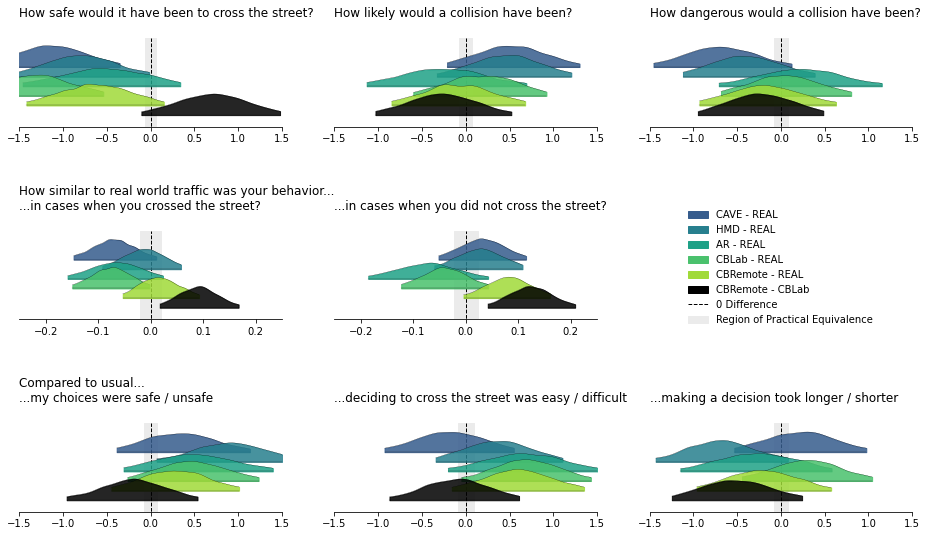

In [92]:
fig, axes = plt.subplots(3,3,figsize=(16, 9))
plt.rcParams.update({'font.size': 10})
colors = sns.color_palette(palette = 'viridis')
colors.append('#000000')

def plotForest(data, ax):
    ax.vlines(0,-10,18,'black', 'dashed', zorder=-10,lw=1)
    az.plot_forest(data,
                   kind='ridgeplot',
                   model_names = ['Cave - Real','HMD - Real','AR - Real','CBLab - Real','CBRemote - Real','CBRemote - CBLab'],
                   combined=True,
                   ax = ax,
                   ridgeplot_overlap=5,
                   linewidth=0.25,
                   colors=colors,
                   ridgeplot_alpha=0.85)
    ax.spines['top'].set_color('white')
    ax.set_yticks([])

axes[0, 0].set_title("How safe would it have been to cross the street?" , loc='left')
axes[0, 0].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q1'].std()*-0.1,-10), df_subjectives['Q1'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q1_diffs, axes[0, 0])
axes[0, 0].set(xlim=(-1.5, 1.5))

axes[0, 1].set_title("How likely would a collision have been?" , loc='left')
axes[0, 1].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q2'].std()*-0.1,-10), df_subjectives['Q2'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q2_diffs, axes[0, 1])
axes[0, 1].set(xlim=(-1.5, 1.5))

axes[0, 2].set_title("How dangerous would a collision have been?" , loc='left')
axes[0, 2].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q3'].std()*-0.1,-10), df_subjectives['Q3'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q3_diffs, axes[0, 2])
axes[0, 2].set(xlim=(-1.5, 1.5))
    
axes[1, 0].set_title("How similar to real world traffic was your behavior... \n...in cases when you crossed the street?" , loc='left')
axes[1, 0].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q4'].std()*-0.1,-10), df_subjectives['Q4'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q4_diffs, axes[1, 0])
axes[1, 0].set(xlim=(-0.25, 0.25))

axes[1, 1].set_title("\n...in cases when you did not cross the street?" , loc='left')
axes[1, 1].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q5'].std()*-0.1,-10), df_subjectives['Q5'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q5_diffs, axes[1, 1])
axes[1, 1].set(xlim=(-0.25, 0.25))

axes[2, 0].set_title("Compared to usual... \n...my choices were safe / unsafe" , loc='left')
axes[2, 0].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q6'].std()*-0.1,-10), df_subjectives['Q6'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q6_diffs, axes[2, 0])
axes[2, 0].set(xlim=(-1.5, 1.5))

axes[2, 1].set_title("\n...deciding to cross the street was easy / difficult" , loc='left')
axes[2, 1].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q7'].std()*-0.1,-10), df_subjectives['Q7'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q7_diffs, axes[2, 1])
axes[2, 1].set(xlim=(-1.5, 1.5))

axes[2, 2].set_title("\n...making a decision took longer / shorter" , loc='left')
axes[2, 2].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q8'].std()*-0.1,-10), df_subjectives['Q8'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q8_diffs, axes[2, 2])
axes[2, 2].set(xlim=(-1.5, 1.5))



cave_patch = mpatches.Patch(color=colors[1], label='CAVE - REAL')
hmd_patch = mpatches.Patch(color=colors[2], label='HMD - REAL')
ar_patch = mpatches.Patch(color=colors[3], label='AR - REAL')
cblab_patch = mpatches.Patch(color=colors[4], label='CBLab - REAL')
cbremote_patch = mpatches.Patch(color=colors[5], label='CBRemote - REAL')
cbdiff_patch = mpatches.Patch(color=colors[6], label='CBRemote - CBLab')
line = Line2D([0], [0], color='black',ls='dashed', lw=1, label='0 Difference')

rope_patch = mpatches.Patch(color="#ebebeb", label='Region of Practical Equivalence')
axes[1, 2].legend(handles=[cave_patch,hmd_patch,ar_patch,cblab_patch,cbremote_patch,cbdiff_patch,line,rope_patch], loc='center')
axes[1, 2].axis('off')

fig.subplots_adjust(hspace=0.85, wspace=0.2)
plt.savefig('11.pdf', bbox_inches="tight")

### SRSI

In [93]:
df_subjective_cb = df_subjectives.loc[df_subjectives['Condition'].isin(['CBLab','CBRemote'])]
df_subjective_cb = df_subjective_cb[['Condition','SRSI']]
df_subjective_cb = df_subjective_cb.astype({"Condition": 'object'})
df_subjective_cb['SRSI'] = abs(df_subjective_cb['SRSI']-100)+1

In [94]:
SRSI_model = bmb.Model(formula="SRSI ~ 0 + Condition",
                     data=df_subjective_cb, dropna=True,
                     categorical="Condition")
SRSI_fitted = SRSI_model.fit(random_seed=RANDOM_SEED)
az.summary(SRSI_fitted)

Automatically removing 1/60 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [SRSI_sigma, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0]  4.435  1.009   2.504    6.247      0.015    0.011    4752.0   
Condition[1]  3.754  1.052   1.759    5.662      0.015    0.011    4646.0   
SRSI_sigma    5.520  0.531   4.639    6.560      0.008    0.005    4942.0   

              ess_tail  r_hat  
Condition[0]    2810.0    1.0  
Condition[1]    2760.0    1.0  
SRSI_sigma      3251.0    1.0

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


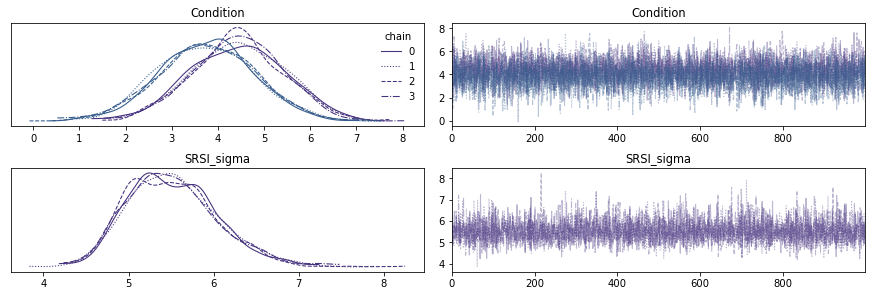

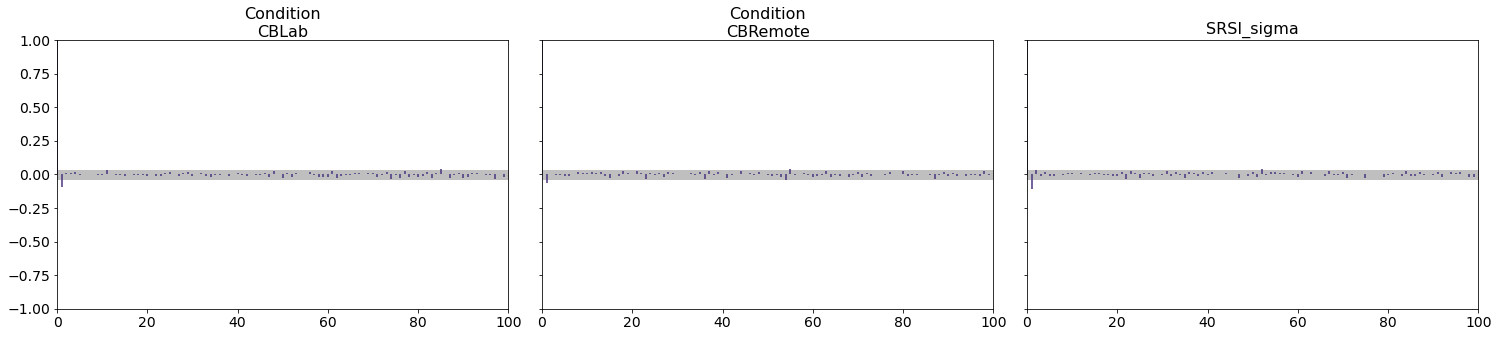

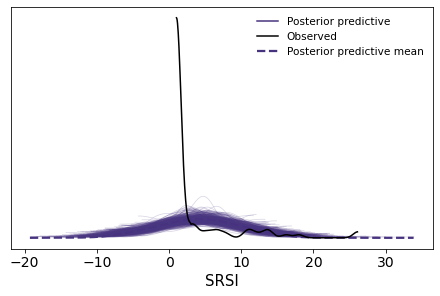

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


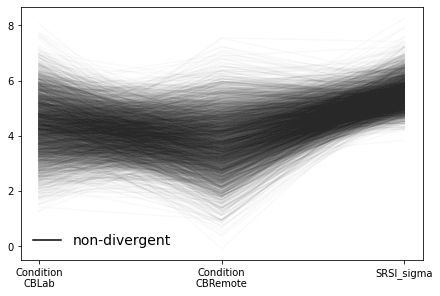

In [95]:
posterior_predictive = SRSI_model.posterior_predictive(SRSI_fitted,random_seed = RANDOM_SEED)

az.plot_trace(SRSI_fitted,legend=True, compact=True);    
az.plot_autocorr(SRSI_fitted, combined = True);
az.plot_ppc(SRSI_fitted);
az.plot_parallel(SRSI_fitted, legend = True);

**Models with Gamma and Wald Function**
c.f. https://bambinos.github.io/bambi/master/notebooks/wald_gamma_glm.html

In [96]:
SRSI_model_wald = bmb.Model(formula="SRSI ~ 0 + Condition",
                     data=df_subjective_cb, dropna=True,
                     family = "wald", link = "log",
                     categorical="Condition")
SRSI_fitted_wald = SRSI_model_wald.fit(random_seed=RANDOM_SEED)
az.summary(SRSI_fitted_wald)

Automatically removing 1/60 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [SRSI_lam, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
The acceptance probability does not match the target. It is 0.8849684050146993, but should be close to 0.8. Try to increase the number of tuning steps.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0]  1.608  0.374   1.028    2.220      0.014    0.011    1665.0   
Condition[1]  1.420  0.290   0.896    1.928      0.007    0.006    2595.0   
SRSI_lam      2.179  0.414   1.457    2.995      0.008    0.006    2414.0   

              ess_tail  r_hat  
Condition[0]     878.0    1.0  
Condition[1]    1294.0    1.0  
SRSI_lam        2404.0    1.0

In [97]:
SRSI_model_gamma = bmb.Model(formula="SRSI ~ 0 + Condition",
                     data=df_subjective_cb, dropna=True,
                     family = "gamma", link = "log",
                     categorical="Condition")
SRSI_fitted_gamma = SRSI_model_wald.fit(random_seed=RANDOM_SEED)
az.summary(SRSI_fitted_gamma)

Automatically removing 1/60 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [SRSI_lam, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
The acceptance probability does not match the target. It is 0.8849684050146993, but should be close to 0.8. Try to increase the number of tuning steps.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0]  1.608  0.374   1.028    2.220      0.014    0.011    1665.0   
Condition[1]  1.420  0.290   0.896    1.928      0.007    0.006    2595.0   
SRSI_lam      2.179  0.414   1.457    2.995      0.008    0.006    2414.0   

              ess_tail  r_hat  
Condition[0]     878.0    1.0  
Condition[1]    1294.0    1.0  
SRSI_lam        2404.0    1.0

In [98]:
#Model comparison
models = {"wald": SRSI_fitted_wald, "gaussian": SRSI_fitted, "gamma": SRSI_fitted_gamma}
df_compare = az.compare(models)
df_compare

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank         loo     p_loo      d_loo        weight         se  \
wald         0 -129.527554  2.153954   0.000000  5.000000e-01  11.695483   
gamma        1 -129.527554  2.153954   0.000000  5.000000e-01  11.695483   
gaussian     2 -187.120640  5.034504  57.593085  3.722300e-11  10.763512   

               dse  warning loo_scale  
wald      0.000000    False       log  
gamma     0.000000    False       log  
gaussian  8.807648     True       log

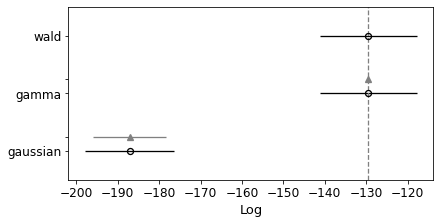

In [99]:
#Comparison plot
az.plot_compare(df_compare, insample_dev=False);

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


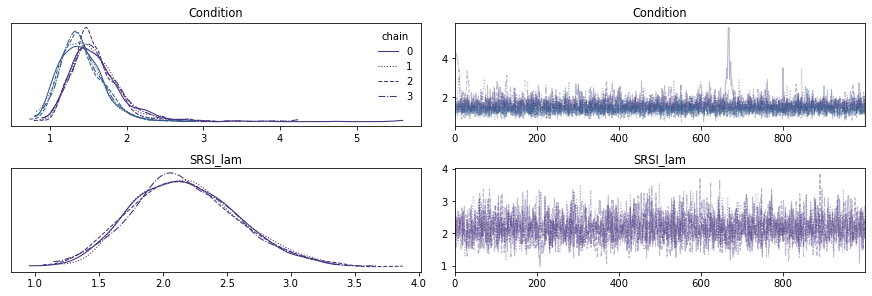

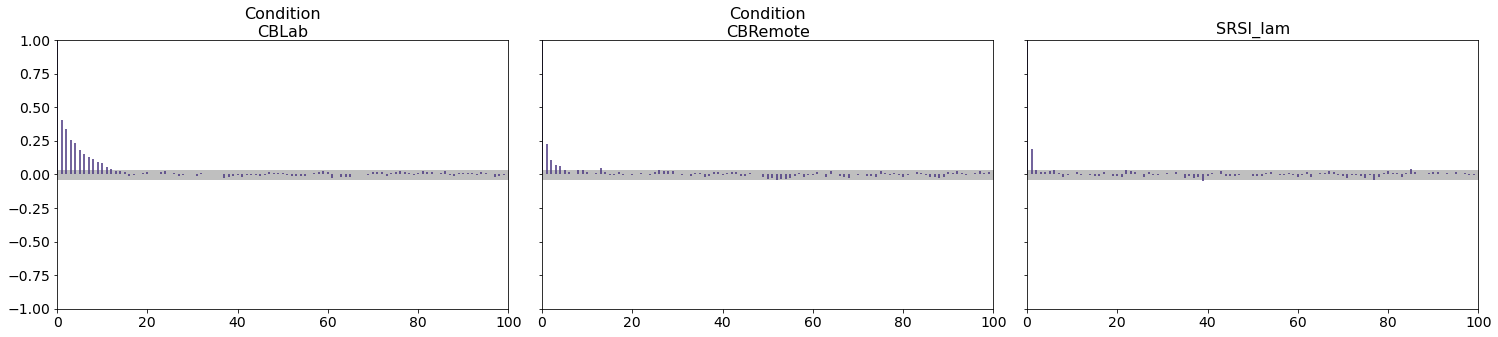

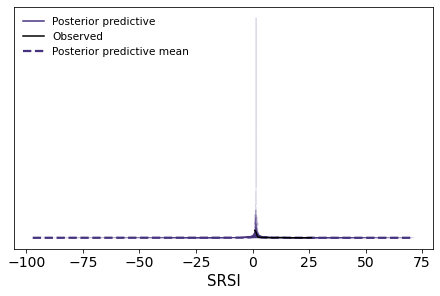

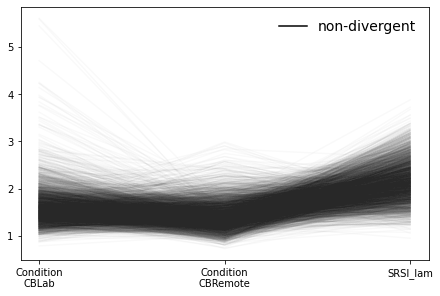

In [100]:
#Checks
posterior_predictive = SRSI_model.posterior_predictive(SRSI_fitted_wald,random_seed = RANDOM_SEED)

az.plot_trace(SRSI_fitted_wald,legend=True, compact=True);    
az.plot_autocorr(SRSI_fitted_wald, combined = True);
az.plot_ppc(SRSI_fitted_wald);
az.plot_parallel(SRSI_fitted_wald, legend = True);

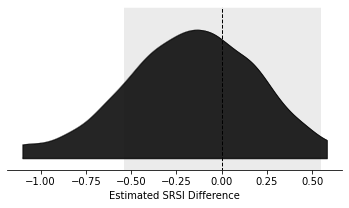

In [101]:
#Calculate posterior distributions
CBLab, CBRemote = [SRSI_fitted_wald.posterior['Condition'][:,:,x].values for x in [0,1]]

#Plot
fig, ax = plt.subplots(figsize=(6, 3))
colors = sns.color_palette(palette = 'viridis')
colors.append('#000000')

ax.vlines(0,-10,18,'black', 'dashed', zorder=-10,lw=1)
az.plot_forest(CBRemote-CBLab,
                   kind='ridgeplot',
                   model_names = ['CBRemote - CBLab'],
                   combined=True,
                   ridgeplot_overlap=5,
                   linewidth=0.25,
                   colors=colors,
                   ax = ax,
                   ridgeplot_alpha=0.85)
ax.spines['top'].set_color('white')
ax.set_yticks([])
ax.set(xlabel='Estimated SRSI Difference')
ax.add_patch(matplotlib.patches.Rectangle((df_subjective_cb['SRSI'].std()*-0.1,-10), df_subjective_cb['SRSI'].std()*0.2, 28, zorder=-100,color="#ebebeb"));

In [102]:
#HDI values
HDIs = pd.DataFrame(np.array([np.concatenate((['CBRemote - CBLab'],az.hdi(az.convert_to_dataset(CBRemote - CBLab)).x.data)),
                             ['ROPE',df_subjective_cb['SRSI'].std()*-0.1,df_subjective_cb['SRSI'].std()*0.1]]),
             columns=['Comparison', 'lowHDI', 'highHDI'])
HDIs = HDIs.astype({"lowHDI": 'float',"highHDI": 'float'})
HDIs.round(3)

Comparison  lowHDI  highHDI
0  CBRemote - CBLab  -1.112    0.589
1              ROPE  -0.541    0.541

In [103]:
#Packages version
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Jun 09 2021

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

bambi     : 0.5.0
pandas    : 1.2.4
matplotlib: 3.3.4
seaborn   : 0.11.1
numpy     : 1.19.2
pymc3     : 3.11.2
scipy     : 1.6.2
arviz     : 0.11.2

Watermark: 2.2.0

